In [1]:
import sys
import os

# Ruta al directorio raíz de tu proyecto
project_root = r"C:\Users\34645\Desktop\projects\GoogleTrends"

# Añadir src al path
sys.path.append(os.path.join(project_root, "src"))
sys.path.append(os.path.join(project_root, "config"))

from trends_processing import construir_panel_global
from keywords_mapping import COUNTRIES_KEYWORDS
from trends_processing import construir_serie_normalizada_con_imputaciones
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from trends_processing import construir_serie_normalizada_con_imputaciones, load_single_keyword_sample
import matplotlib.dates as mdates


Text(0.5, 0, 'Date')

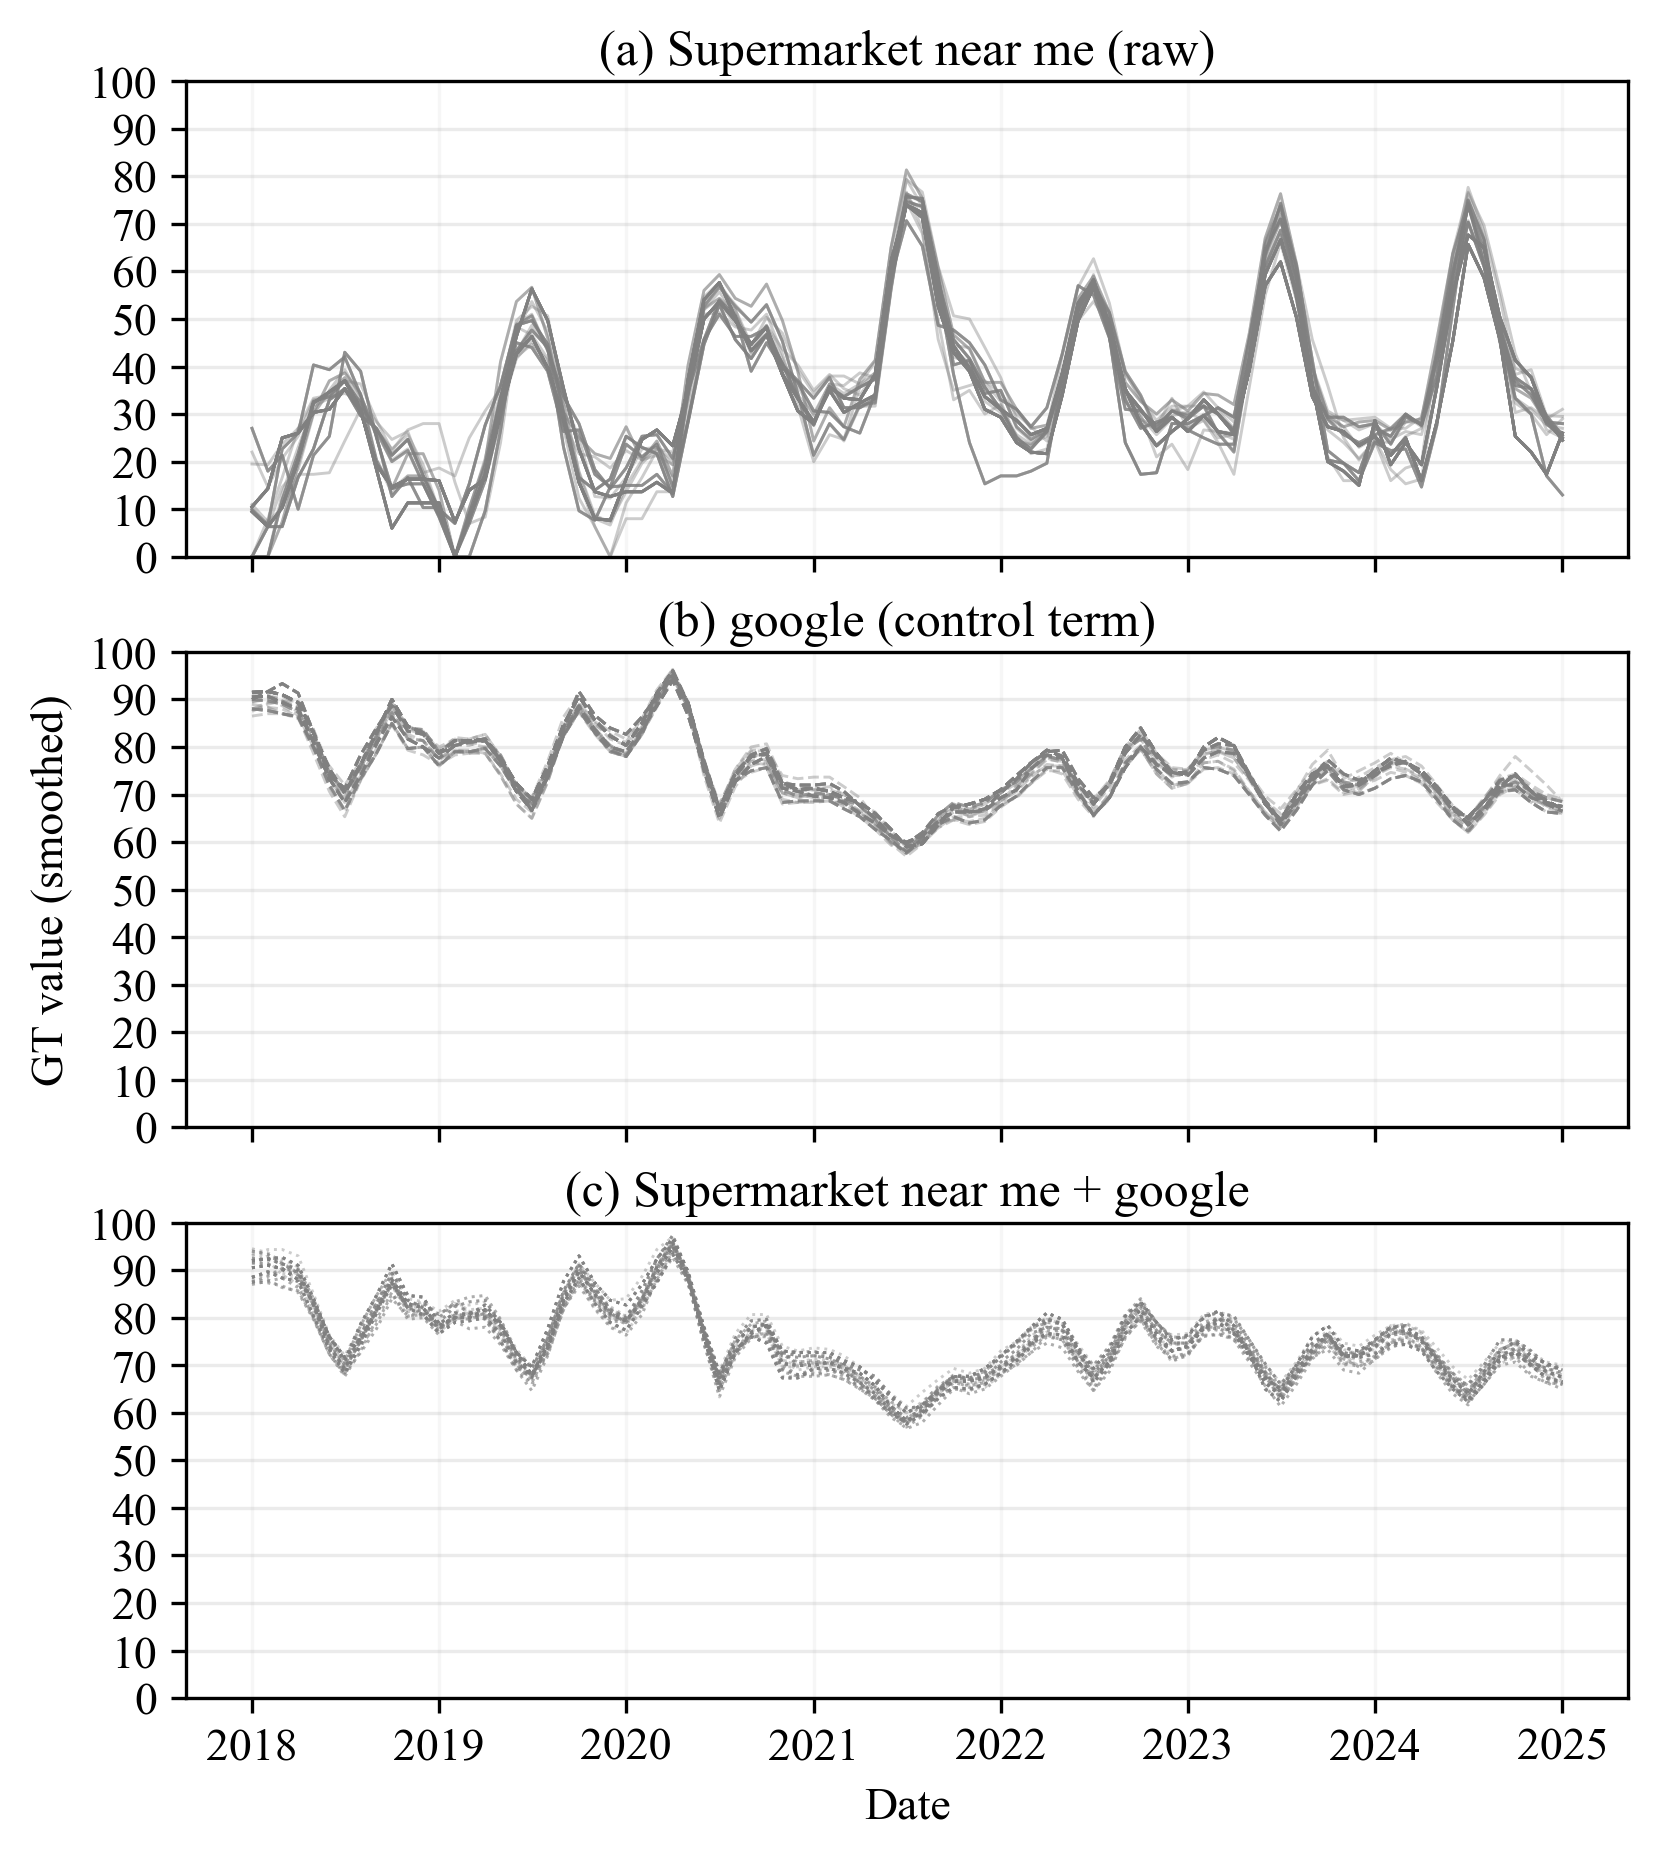

In [2]:

# --- Matplotlib estilo académico ---
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 9,
    "figure.dpi": 300,
})

# --- Parámetros ---
country        = "SE"
keyword        = "mataffär_nära_mig"
control        = "google"
smooth_window  = 3
base_folder    = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_2\x"

def rename_value_column(df):
    if "time [UTC]" in df.columns:
        df = df.rename(columns={"time [UTC]": "date"})
    for c in df.columns:
        if c not in ["date", "keywords", "keyword",
                     "country", "muestra_n", "timestamp", "value"]:
            df = df.rename(columns={c: "value"})
            break
    return df

def load_file(ctry, kw):
    fp = os.path.join(base_folder, f"x_{ctry}_{kw}.csv")
    if not os.path.exists(fp):
        print(f"⚠️ File not found: {fp}")
        return None
    df = pd.read_csv(fp, encoding="utf-8")
    df = rename_value_column(df)
    df["date"] = pd.to_datetime(df["date"], format="mixed", errors="coerce")
    return df

# --- Cargar series ---
df_x  = load_file(country, keyword)
df_xw = load_file(country, f"{keyword}_+_{control}")
df_w  = load_file(country, control)

for name, df in zip(["x", "x+w", "w"], [df_x, df_xw, df_w]):
    if df is None:
        raise FileNotFoundError(f"Google Trends file for “{name}” not found.")

# --- Limitar a las primeras N muestras ---
max_samples = 50
valid_samples = {
    "x": sorted(df_x["muestra_n"].unique())[:max_samples],
    "x+w": sorted(df_xw["muestra_n"].unique())[:max_samples],
    "w": sorted(df_w["muestra_n"].unique())[:max_samples]
}

# --- Limites globales ---
all_vals = pd.concat([df_x["value"], df_xw["value"], df_w["value"]], ignore_index=True)
ymin, ymax = all_vals.min(), all_vals.max()

# --- Crear figura ---
fig, ax = plt.subplots(3, 1, figsize=(6.2, 7), sharex=True)

titles = [
    "(a) Supermarket near me (raw)",
    "(b) google (control term)",
    "(c) Supermarket near me + google"
]
datasets   = [df_x, df_xw, df_w]
linestyles = ["-", "--", ":"]
colors     = ["gray"] * 3  # todas en gris neutro

for i, (df, title, ls) in enumerate(zip(datasets, titles, linestyles)):
    for samp in valid_samples[name]:
        s = df[df["muestra_n"] == samp].sort_values("date")
        values = s["value"].rolling(smooth_window, center=True, min_periods=1).mean()
        ax[i].plot(
            s["date"], values,
            ls, linewidth=0.7, alpha=0.4, color=colors[i]
        )
    ax[i].set_title(title, pad=4)
    ax[i].set_ylim(ymin, ymax)
    ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].grid(axis="y", alpha=0.25)
    ax[i].xaxis.grid(True, alpha=0.1)
    if i == 1:
        ax[i].set_ylabel("GT value (smoothed)")

ax[-1].set_xlabel("Date")




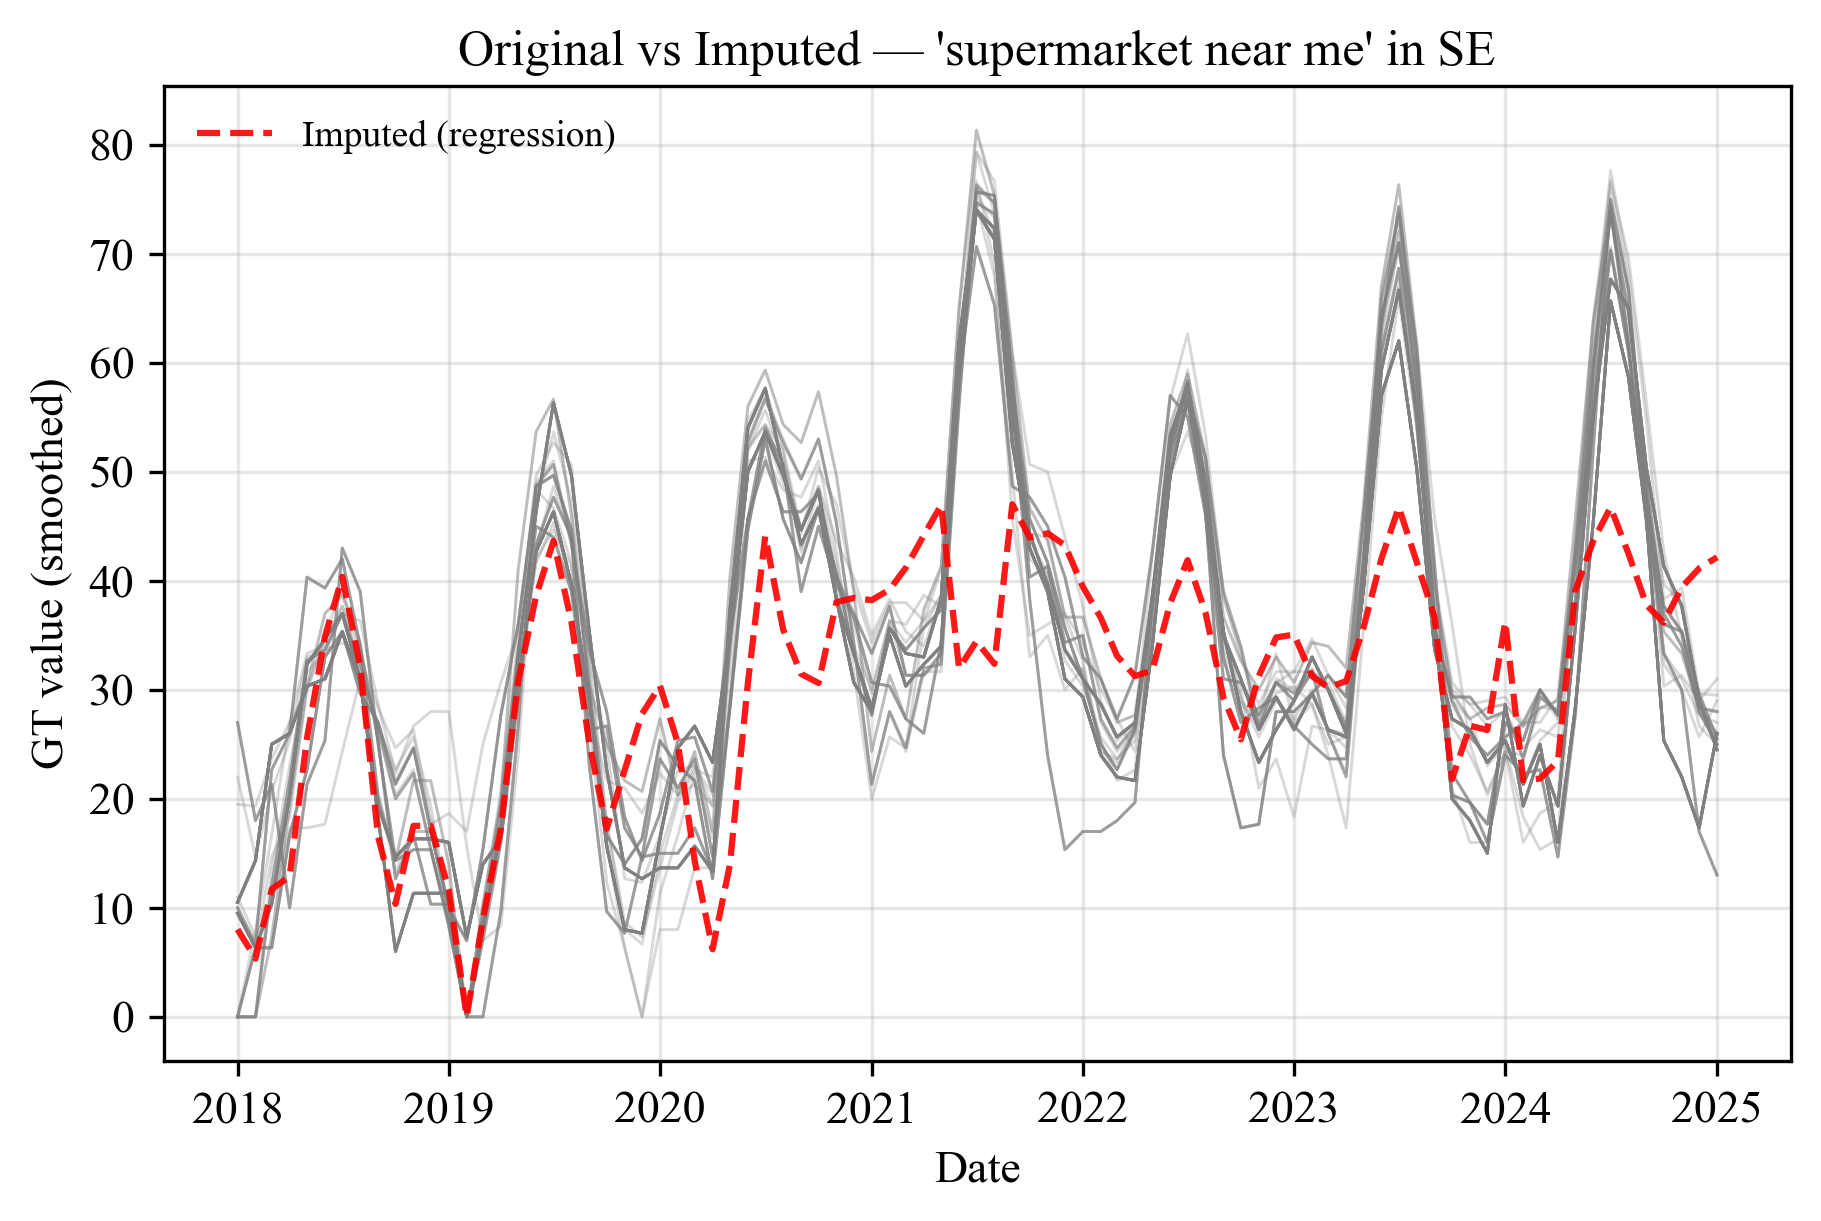

In [5]:
BASE_FOLDER = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_2\x"


# ---------------------- CARGAR TODAS LAS MUESTRAS -------------------------
df_raw = load_single_keyword_sample(BASE_FOLDER, country, keyword)

# Seleccionar primeras 50 muestras disponibles
max_samples = 50
sample_ids = sorted(df_raw["muestra_n"].unique())[:max_samples]

# Cargar serie imputada
df_imputed = construir_serie_normalizada_con_imputaciones(
    base_folder=BASE_FOLDER,
    country=country,
    keyword=keyword,
    control_term=control
)[["date", "imputed"]]

# ---------------------- GRAFICAR FIGURA -----------------------------------
fig, ax = plt.subplots(figsize=(6.2, 4.2))

# Agregar curvas de cada muestra original
for sample_id in sample_ids:
    df_sample = df_raw[df_raw["muestra_n"] == sample_id][["date", "value"]].rename(columns={"value": "original"})
    df_compare = df_sample.merge(df_imputed, on="date", how="outer").sort_values("date")
    df_compare["original_smooth"] = df_compare["original"].rolling(window=smooth_window, center=True, min_periods=1).mean()

    ax.plot(df_compare["date"], df_compare["original_smooth"],
            alpha=0.3, color="gray", linewidth=0.7)

# Agregar curva imputada (única)
df_imputed["imputed_smooth"] = df_imputed["imputed"].rolling(window=smooth_window, center=True, min_periods=1).mean()
ax.plot(df_imputed["date"], df_imputed["imputed_smooth"],
        label="Imputed (regression)", alpha=0.9, color="red", linestyle="--", linewidth=1.5)


# ---------------------- FORMATO FINAL --------------------------------------
ax.set_title(f"Original vs Imputed — 'supermarket near me' in {country}", pad=5)
ax.set_ylabel("GT value (smoothed)")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left", frameon=False)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()



In [6]:

df_panel = construir_panel_global(
    base_folder=r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_2\x",
    country_keywords=COUNTRIES_KEYWORDS,
    control_term="google"
)



📦 Procesando país: GB
  🔍 Keyword: car
  🔍 Keyword: taxi
  🔍 Keyword: bicycle
  🔍 Keyword: bus
  🔍 Keyword: work from home
  🔍 Keyword: supermarket near me
  🔍 Keyword: restaurant near me
  🔍 Keyword: online shopping
  🔍 Keyword: electric car
  🔍 Keyword: petrol consumption
  🔍 Keyword: hybrid car
  🔍 Keyword: parking
  🔍 Keyword: traffic
  🔍 Keyword: car sharing
  🔍 Keyword: uber

📦 Procesando país: ES
  🔍 Keyword: coche
  🔍 Keyword: taxi
  🔍 Keyword: bicicleta
  🔍 Keyword: autobús
  🔍 Keyword: teletrabajo
  🔍 Keyword: supermercado cerca
  🔍 Keyword: restaurante cerca
  🔍 Keyword: compra online
  🔍 Keyword: coche eléctrico
  🔍 Keyword: consumo gasolina
  🔍 Keyword: coche híbrido
  🔍 Keyword: aparcamiento
  🔍 Keyword: trafico
  🔍 Keyword: car sharing
  🔍 Keyword: uber
  🔍 Keyword: cabify

📦 Procesando país: PT
  🔍 Keyword: carro
  🔍 Keyword: táxi
  🔍 Keyword: bicicleta
  🔍 Keyword: autocarro
  🔍 Keyword: trabalho remoto
  🔍 Keyword: supermercado perto
  🔍 Keyword: restaurante perto
  

In [7]:
df_panel_grouped = df_panel.groupby(["country", "date", "keyword_common"]).agg({
    "imputed": "mean",
    "zscore": "mean"
}).reset_index()

In [8]:
# Paso 1: Transformar y preparar datos (como en tu `preparar_panel_para_pca`)
df_panel_pivot = df_panel_grouped.pivot_table(
    index=["date", "country"],
    columns="keyword_common",
    values="zscore"
).reset_index()

In [9]:
# Total de NaN por columna
nan_per_series = df_panel_pivot.isna().sum().sort_values(ascending=False)

# Porcentaje de NaN por serie
nan_pct = (nan_per_series / len(df_panel_pivot)) * 100

# Mostrar series con más del 10% de NaN, por ejemplo
print(nan_pct[nan_pct > 10])


Series([], dtype: float64)


In [10]:
df_panel_grouped.head()
df_panel_grouped["country"].unique()
df_panel_grouped["keyword_common"].value_counts()


keyword_common
bike                1275
bus                 1275
car                 1275
car_sharing         1275
electric_car        1275
fuel_consumption    1275
hybrid_car          1275
online_shopping     1275
parking             1275
remote_work         1275
restaurant          1275
ride_hailing        1275
supermarket         1275
taxi                1275
traffic             1275
Name: count, dtype: int64

In [11]:
def remove_seasonality(series):
    try:
        stl = STL(series, period=12, robust=True)
        result = stl.fit()
        return result.resid
    except:
        return series  # Si falla, retorna original

In [12]:
# Asume que df_panel_pivot tiene columnas: date, country, [keywords...]
df_deseasonalized = df_panel_pivot.copy()
keyword_cols = df_deseasonalized.columns.difference(["date", "country"])

for kw in keyword_cols:
    df_deseasonalized[kw] = (
        df_deseasonalized.groupby("country")[kw]
        .transform(remove_seasonality)
    )


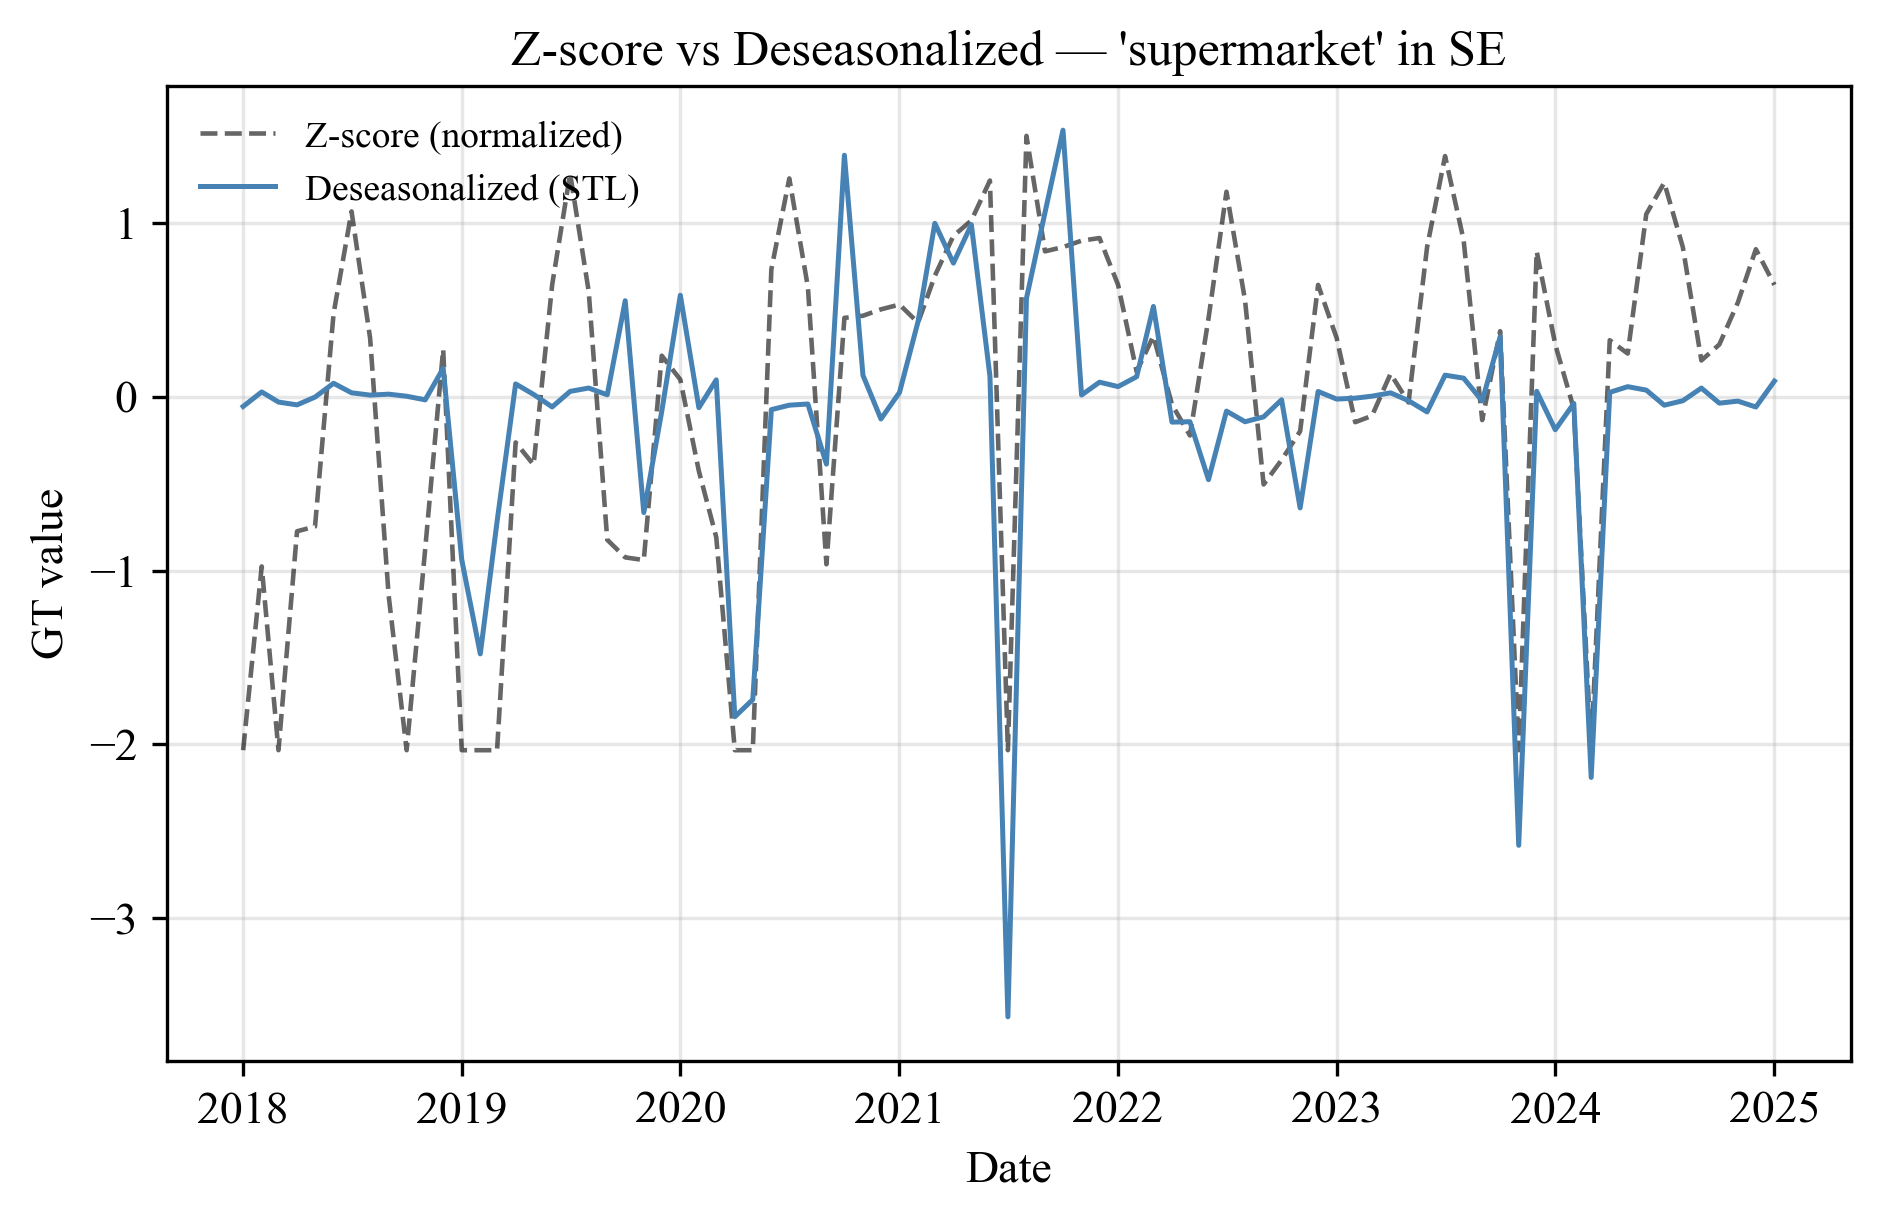

In [13]:
# -------------------- CONFIGURACIÓN ESTILO PLOT --------------------
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 9,
    "figure.dpi": 300,
})

# -------------------- PARÁMETROS -----------------------------------
keyword = "supermarket"
country = "SE"

# -------------------- FILTRAR DATOS ---------------------------------
df_z = df_panel_pivot[df_panel_pivot["country"] == country].copy()
df_deseas = df_deseasonalized[df_deseasonalized["country"] == country].copy()

# -------------------- FIGURA COMPARATIVA ----------------------------
fig, ax = plt.subplots(figsize=(6.4, 4.2))

ax.plot(df_z["date"], df_z[keyword], label="Z-score (normalized)", color="black", linestyle="--", linewidth=1.1, alpha=0.6)
ax.plot(df_deseas["date"], df_deseas[keyword], label="Deseasonalized (STL)", color="steelblue", linestyle="-", linewidth=1.2)

ax.set_title(f"Z-score vs Deseasonalized — '{keyword}' in {country}", pad=5)
ax.set_ylabel("GT value")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left", frameon=False)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_tick_params(rotation=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


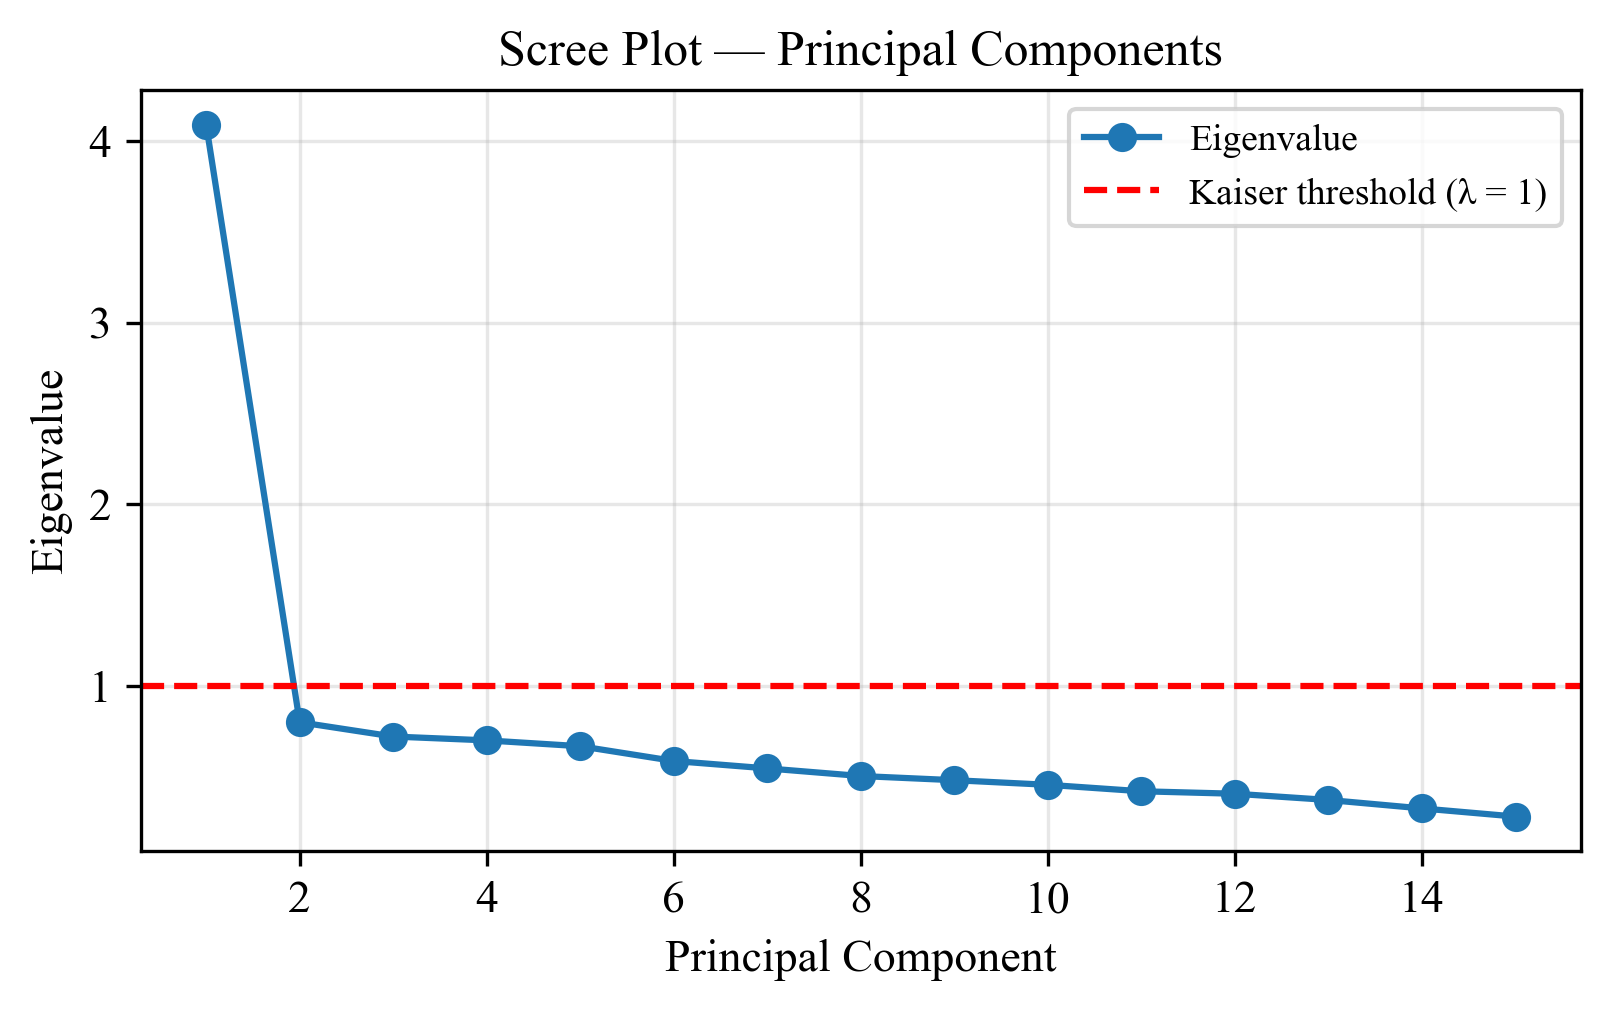

In [14]:

# --- Estética académica ---
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 9,
    "figure.dpi": 300
})

# --- Paso 1: Preparar datos ---
X = df_deseasonalized.drop(columns=["date", "country"])
X_vars = X.copy()

# --- Paso 2: PCA ---
pca = PCA()
X_pca = pca.fit_transform(X)

# --- Paso 3: Scores y loadings ---
df_scores = pd.concat(
    [df_deseasonalized[["date", "country"]].reset_index(drop=True),
     pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])],
    axis=1
)

df_loadings = pd.DataFrame(
    pca.components_,
    columns=X_vars.columns,
    index=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

# --- Paso 4: Scree plot (presentación profesional) ---
eigenvalues = pca.explained_variance_
var_exp = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(5.5, 3.5))
ax.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', label='Eigenvalue')
ax.axhline(y=1, color="red", linestyle="--", label="Kaiser threshold (λ = 1)")

ax.set_title("Scree Plot — Principal Components", pad=6)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Eigenvalue")
ax.set_xticks(range(1, len(eigenvalues) + 1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()



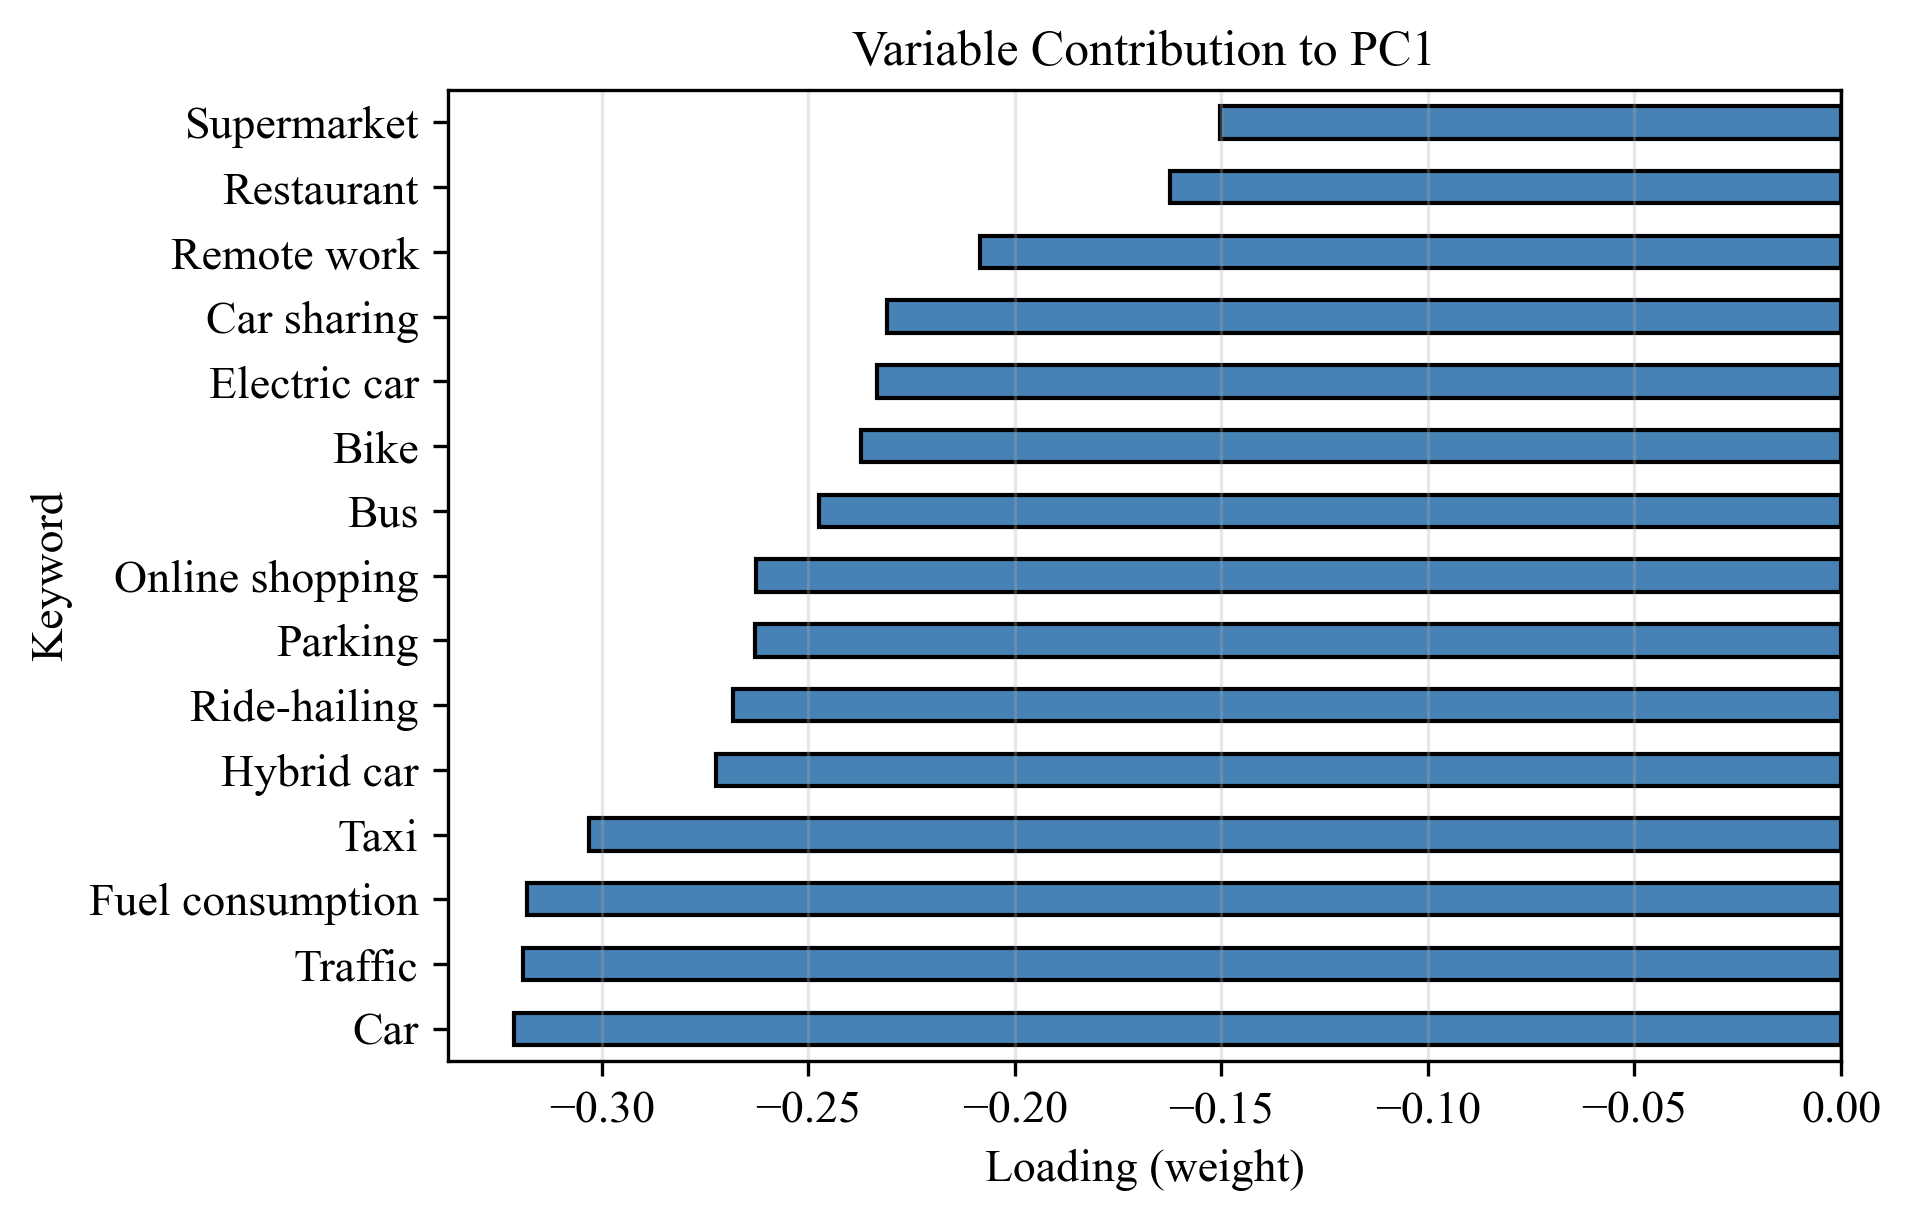

In [15]:

# --- Seleccionar loadings de PC1 (y PC2 si quieres)
loadings_pc1 = df_loadings.loc["PC1"].sort_values()
# loadings_pc2 = df_loadings.loc["PC2"].sort_values()


# Mapeo limpio para presentación
pretty_labels = {
    "car": "Car",
    "traffic": "Traffic",
    "fuel_consumption": "Fuel consumption",
    "taxi": "Taxi",
    "hybrid_car": "Hybrid car",
    "ride_hailing": "Ride-hailing",
    "parking": "Parking",
    "online_shopping": "Online shopping",
    "bus": "Bus",
    "bike": "Bike",
    "electric_car": "Electric car",
    "car_sharing": "Car sharing",
    "remote_work": "Remote work",
    "restaurant": "Restaurant",
    "supermarket": "Supermarket",
}

# Aplicar el renombre a los índices del gráfico
loadings_pc1_named = loadings_pc1.rename(index=pretty_labels)

# Replot
plt.figure(figsize=(6.5, 4.2))
loadings_pc1_named.plot(kind="barh", color="steelblue", edgecolor="black")
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Variable Contribution to PC1", fontsize=12, pad=6)
plt.xlabel("Loading (weight)")
plt.ylabel("Keyword")  # ✅ Aquí se actualiza
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


In [21]:
from sklearn.cluster import KMeans

df_smi = df_scores[["date", "country", "PC1"]].rename(columns={"PC1": "smi"})

df_smi


date country        smi
0    2018-01-01      AT  11.148018
1    2018-01-01      BE   2.943121
2    2018-01-01      DE  10.522492
3    2018-01-01      DK  14.009004
4    2018-01-01      ES   1.480799
...         ...     ...        ...
1270 2025-01-01      NL  -0.554410
1271 2025-01-01      NO  -0.250305
1272 2025-01-01      PT   0.070050
1273 2025-01-01      SE  -0.401653
1274 2025-01-01      US  -0.431360

[1275 rows x 3 columns]

In [23]:
df_smi['country'].unique()

array(['AT', 'BE', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'IE', 'IT', 'NL',
       'NO', 'PT', 'SE', 'US'], dtype=object)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

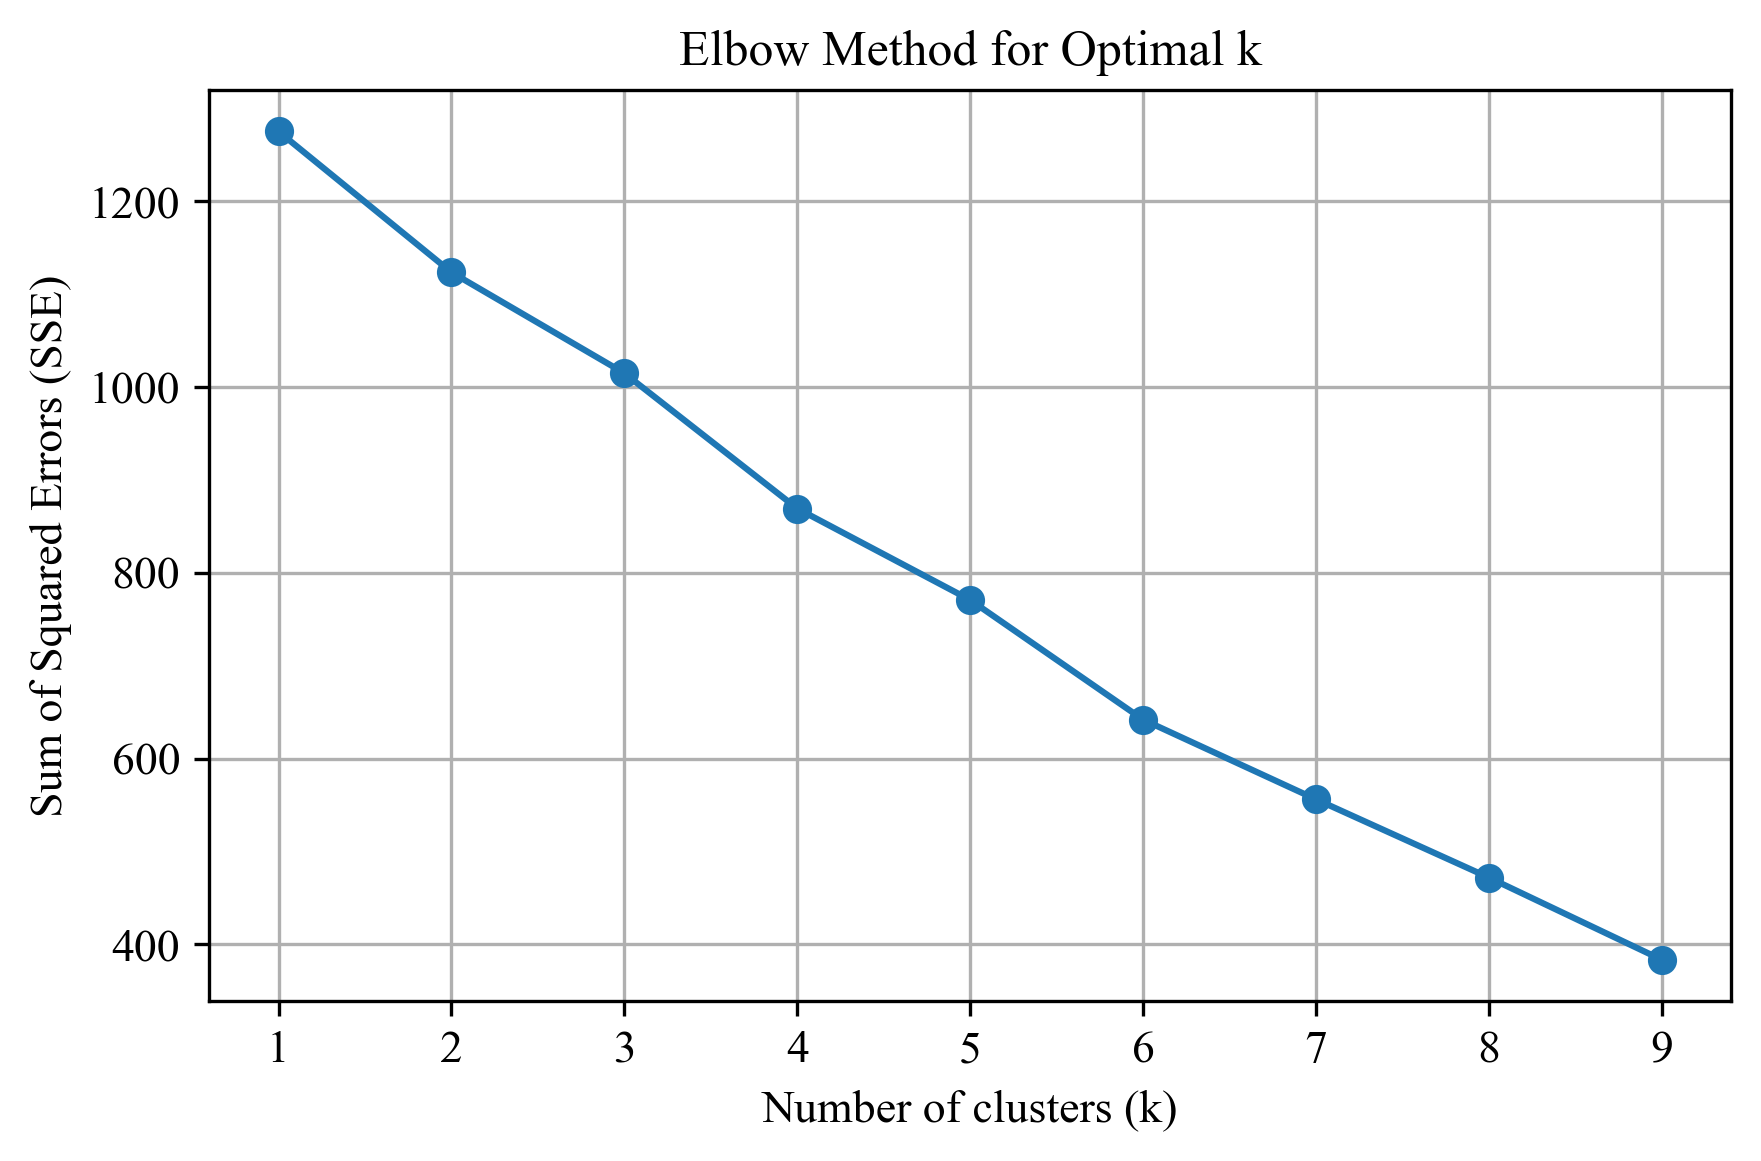

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


date country  cluster
3         DK        0
5         FI        0
11        NO        0
13        SE        0
1         BE        1
4         ES        1
6         FR        1
7         GB        1
8         IE        1
9         IT        1
12        PT        1
14        US        1
0         AT        2
2         DE        2
10        NL        2


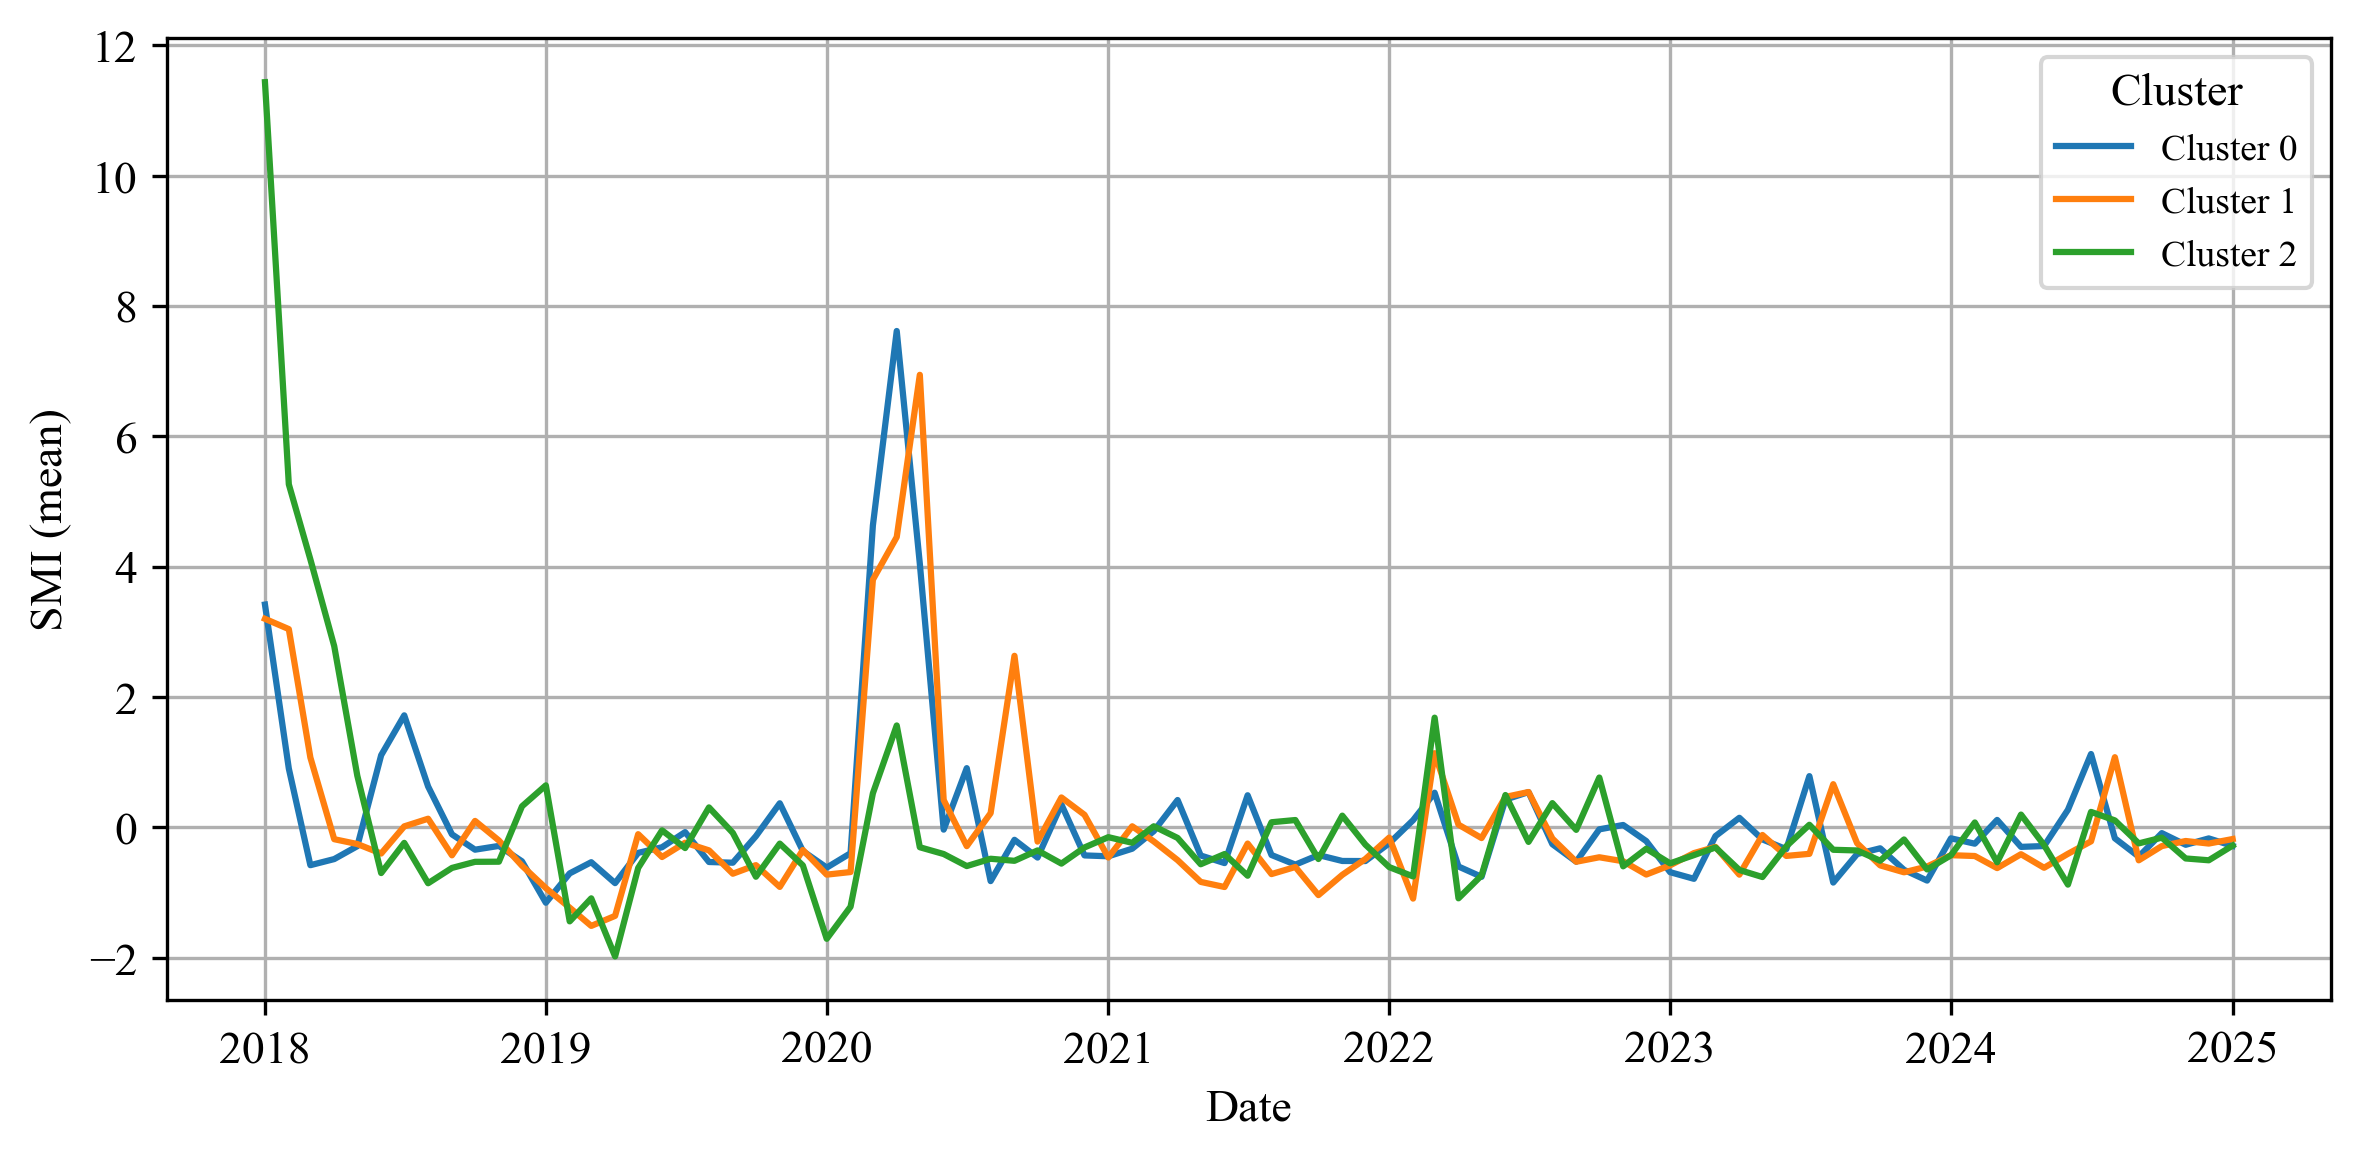

In [34]:
# --- Step 1: PCA on deseasonalized series ---
X = df_deseasonalized.drop(columns=["date", "country"]).values
pca = PCA()
scores = pca.fit_transform(X)

# --- Step 2: Build scores DataFrame ---
df_scores = pd.DataFrame({
    "date": df_deseasonalized["date"].values,
    "country": df_deseasonalized["country"].values,
    "smi": scores[:, 0]
})

# --- Step 3: Pivot for clustering ---
df_pivot = df_scores.pivot(index="country", columns="date", values="smi")

# --- Step 4: Standardize by country ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot)

# --- Step 5: Elbow Method to choose k ---
sse = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 6: Apply K-Means with k=3 ---
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df_pivot["cluster"] = kmeans.fit_predict(X_scaled)

# --- Step 7: Output country-cluster assignments ---
df_clusters = df_pivot[["cluster"]].reset_index().sort_values(["cluster", "country"])
print(df_clusters)

# --- Step 8: Plot mean SMI evolution by cluster ---
df_smi_clustered = df_scores.merge(df_clusters, on="country")
df_mean = df_smi_clustered.groupby(["cluster", "date"])["smi"].mean().unstack("cluster")

plt.figure(figsize=(8, 4))
for cluster in df_mean.columns:
    plt.plot(df_mean.index, df_mean[cluster], label=f'Cluster {cluster}')
plt.xlabel("Date")
plt.ylabel("SMI (mean)")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\34645\AppData\Local\Temp\ipykernel_17524\3660360936.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


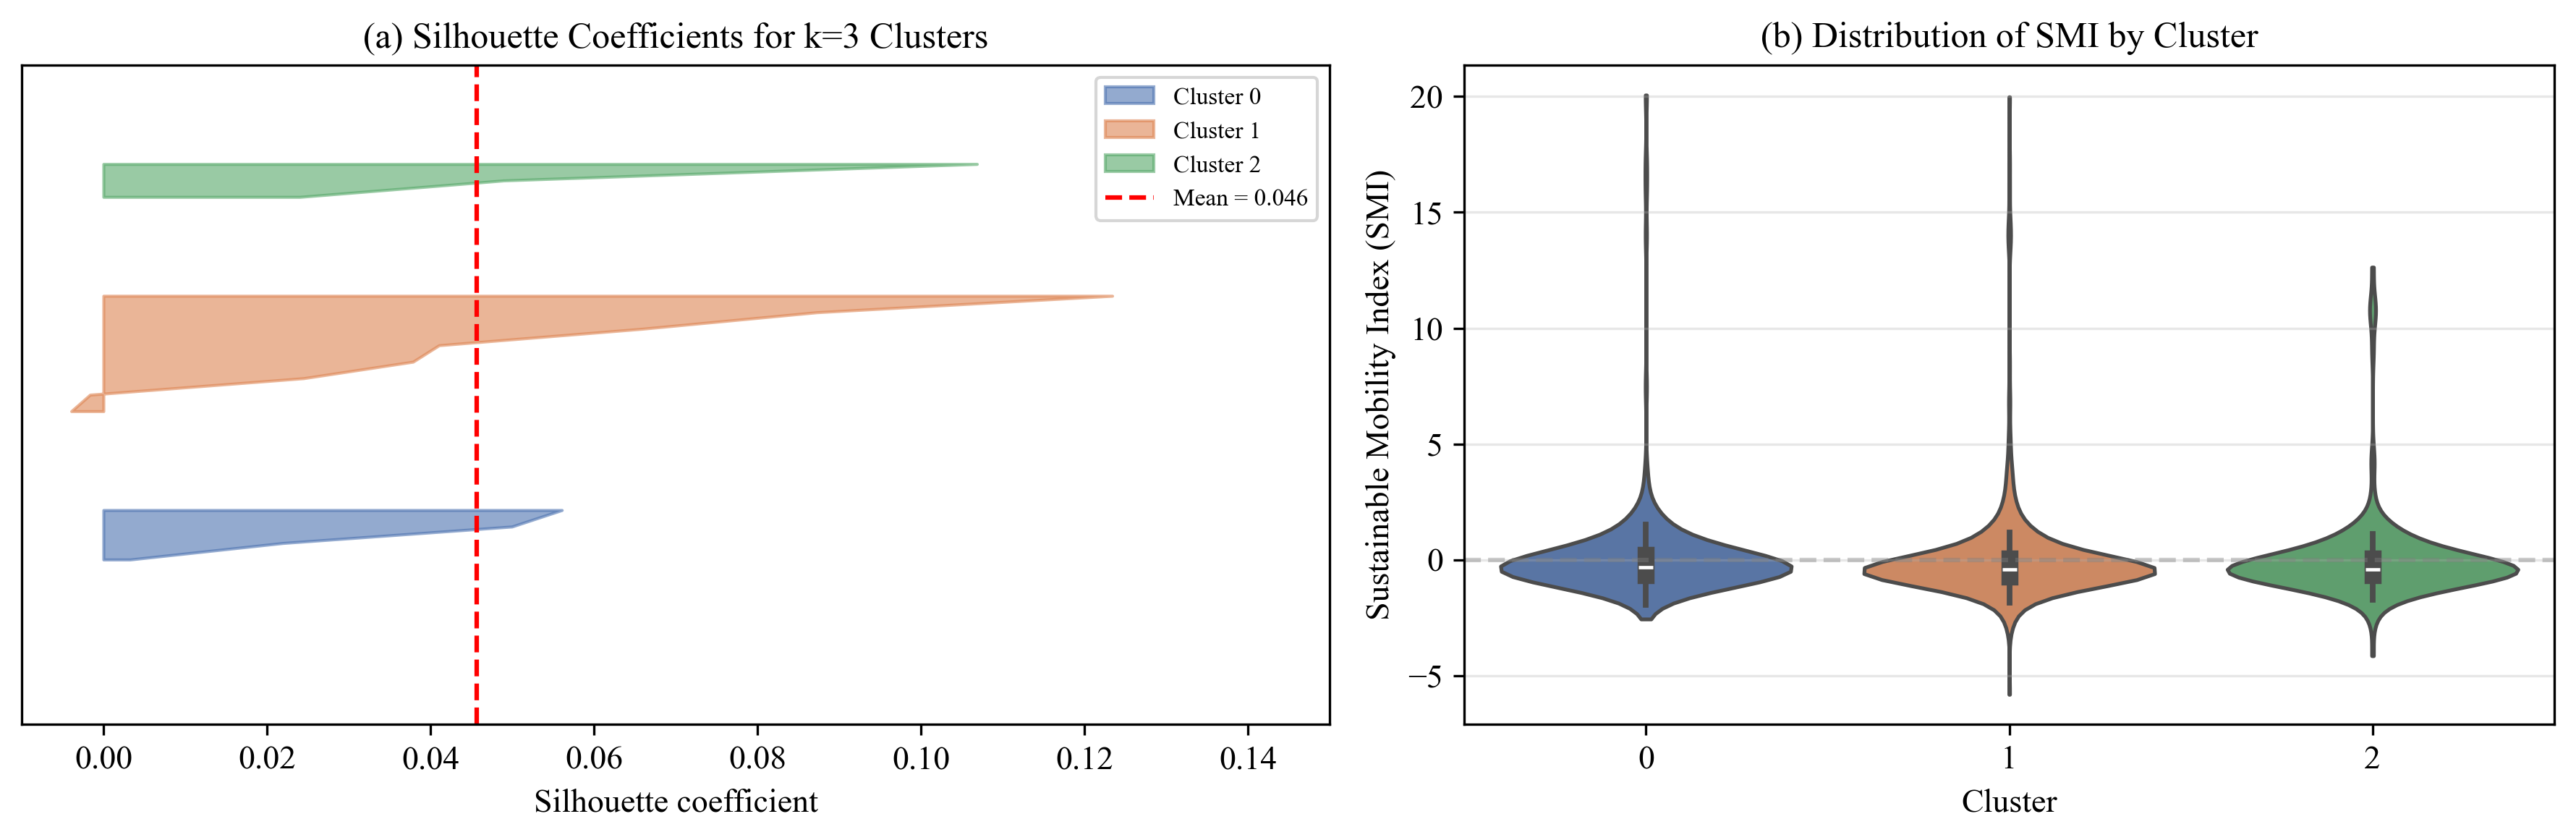

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
import numpy as np

# Asegurar que cluster es entero
df_smi_clustered["cluster"] = df_smi_clustered["cluster"].astype(int)
df_pivot["cluster"] = df_pivot["cluster"].astype(int)

# Convertir a string para evitar error en seaborn
df_smi_clustered["cluster_str"] = df_smi_clustered["cluster"].astype(str)

# Paleta con claves string
palette = {'0': "#4c72b0", '1': "#dd8452", '2': "#55a868"}

# Silhouette
X_scaled = StandardScaler().fit_transform(df_pivot.drop(columns="cluster"))
labels = df_pivot["cluster"].values
sil_values = silhouette_samples(X_scaled, labels)
sil_global = silhouette_score(X_scaled, labels)

# Layout
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1])

# (a) Silhouette plot
ax1 = plt.subplot(gs[0])
y_lower = 10
for c in sorted(np.unique(labels)):
    vals = sil_values[labels == c]
    vals.sort()
    size = len(vals)
    y_upper = y_lower + size
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                      alpha=0.6, color=palette[str(c)], label=f"Cluster {c}")
    y_lower = y_upper + 5
ax1.axvline(sil_global, color='red', linestyle='--', label=f"Mean = {sil_global:.3f}")
ax1.set_xlim(-0.01, 0.15)
ax1.set_ylim(0, y_lower)
ax1.set_yticks([])
ax1.set_xlabel("Silhouette coefficient")
ax1.set_title("(a) Silhouette Coefficients for k=3 Clusters")
ax1.legend(loc="upper right", fontsize=8)

# (b) Violin + Boxplot
ax2 = plt.subplot(gs[1])
sns.violinplot(
    x="cluster_str", y="smi", data=df_smi_clustered,
    inner="box", palette=palette, cut=0, ax=ax2,
    order=['0', '1', '2']
)
ax2.axhline(0, color='grey', linestyle='--', alpha=0.4)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Sustainable Mobility Index (SMI)")
ax2.set_title("(b) Distribution of SMI by Cluster")
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()




In [48]:
df_smi_clustered["cluster"] = df_smi_clustered["cluster"].astype(int)

# Calcular media y desviación estándar por clúster
summary_stats = (
    df_smi_clustered
    .groupby("cluster")["smi"]
    .agg(["median", "std"])
    .round(3)
    .rename(columns={"mean": "SMI Mean", "std": "SMI Std"})
    .reset_index()
)

print(summary_stats)

   cluster  median  SMI Std
0        0  -0.328    2.064
1        1  -0.431    2.050
2        2  -0.407    1.896


Mean silhouette score (k=3): 0.046


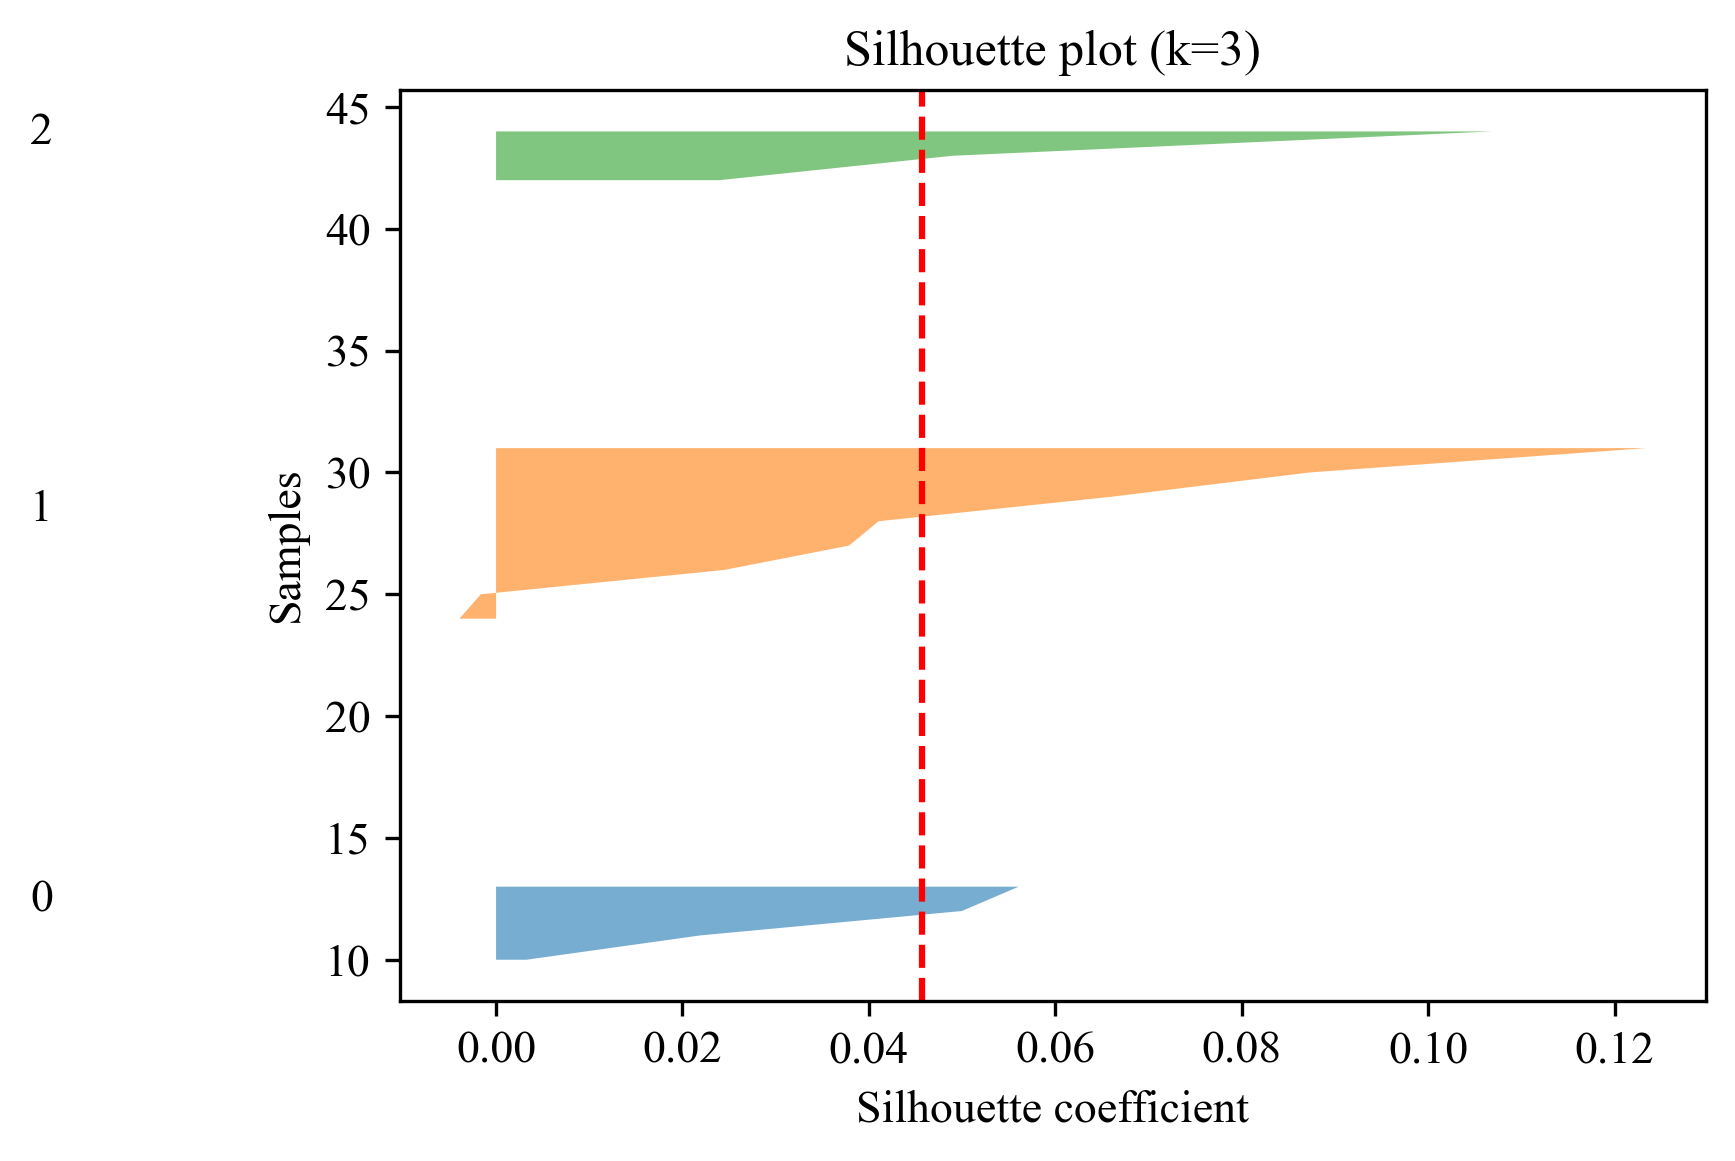

In [35]:
from sklearn.metrics import silhouette_score, silhouette_samples

# ------------------------ VALIDAR SEPARACIÓN (Silhouette) ------------------------
# X_scaled = matriz país × mes ya estandarizada
X_scaled = StandardScaler().fit_transform(df_pivot.drop(columns="cluster"))
labels   = df_pivot["cluster"].values

sil_global  = silhouette_score(X_scaled, labels)
sil_values  = silhouette_samples(X_scaled, labels)
print(f"Mean silhouette score (k=3): {sil_global:.3f}")

fig, ax = plt.subplots(figsize=(6,4))
y_lower = 10
for c in sorted(df_pivot["cluster"].unique()):
    vals = sil_values[labels == c]
    vals.sort()
    size = len(vals)
    y_upper = y_lower + size
    ax.fill_betweenx(range(y_lower, y_upper), 0, vals, alpha=.6, label=f'Cluster {c}')
    ax.text(-0.05,(y_lower+y_upper)/2,str(c))
    y_lower = y_upper + 10
ax.axvline(sil_global, color='red', linestyle='--')
ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Samples")
ax.set_title("Silhouette plot (k=3)")
plt.tight_layout(); plt.show()



C:\Users\34645\AppData\Local\Temp\ipykernel_17524\1671451012.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="cluster", y="smi",


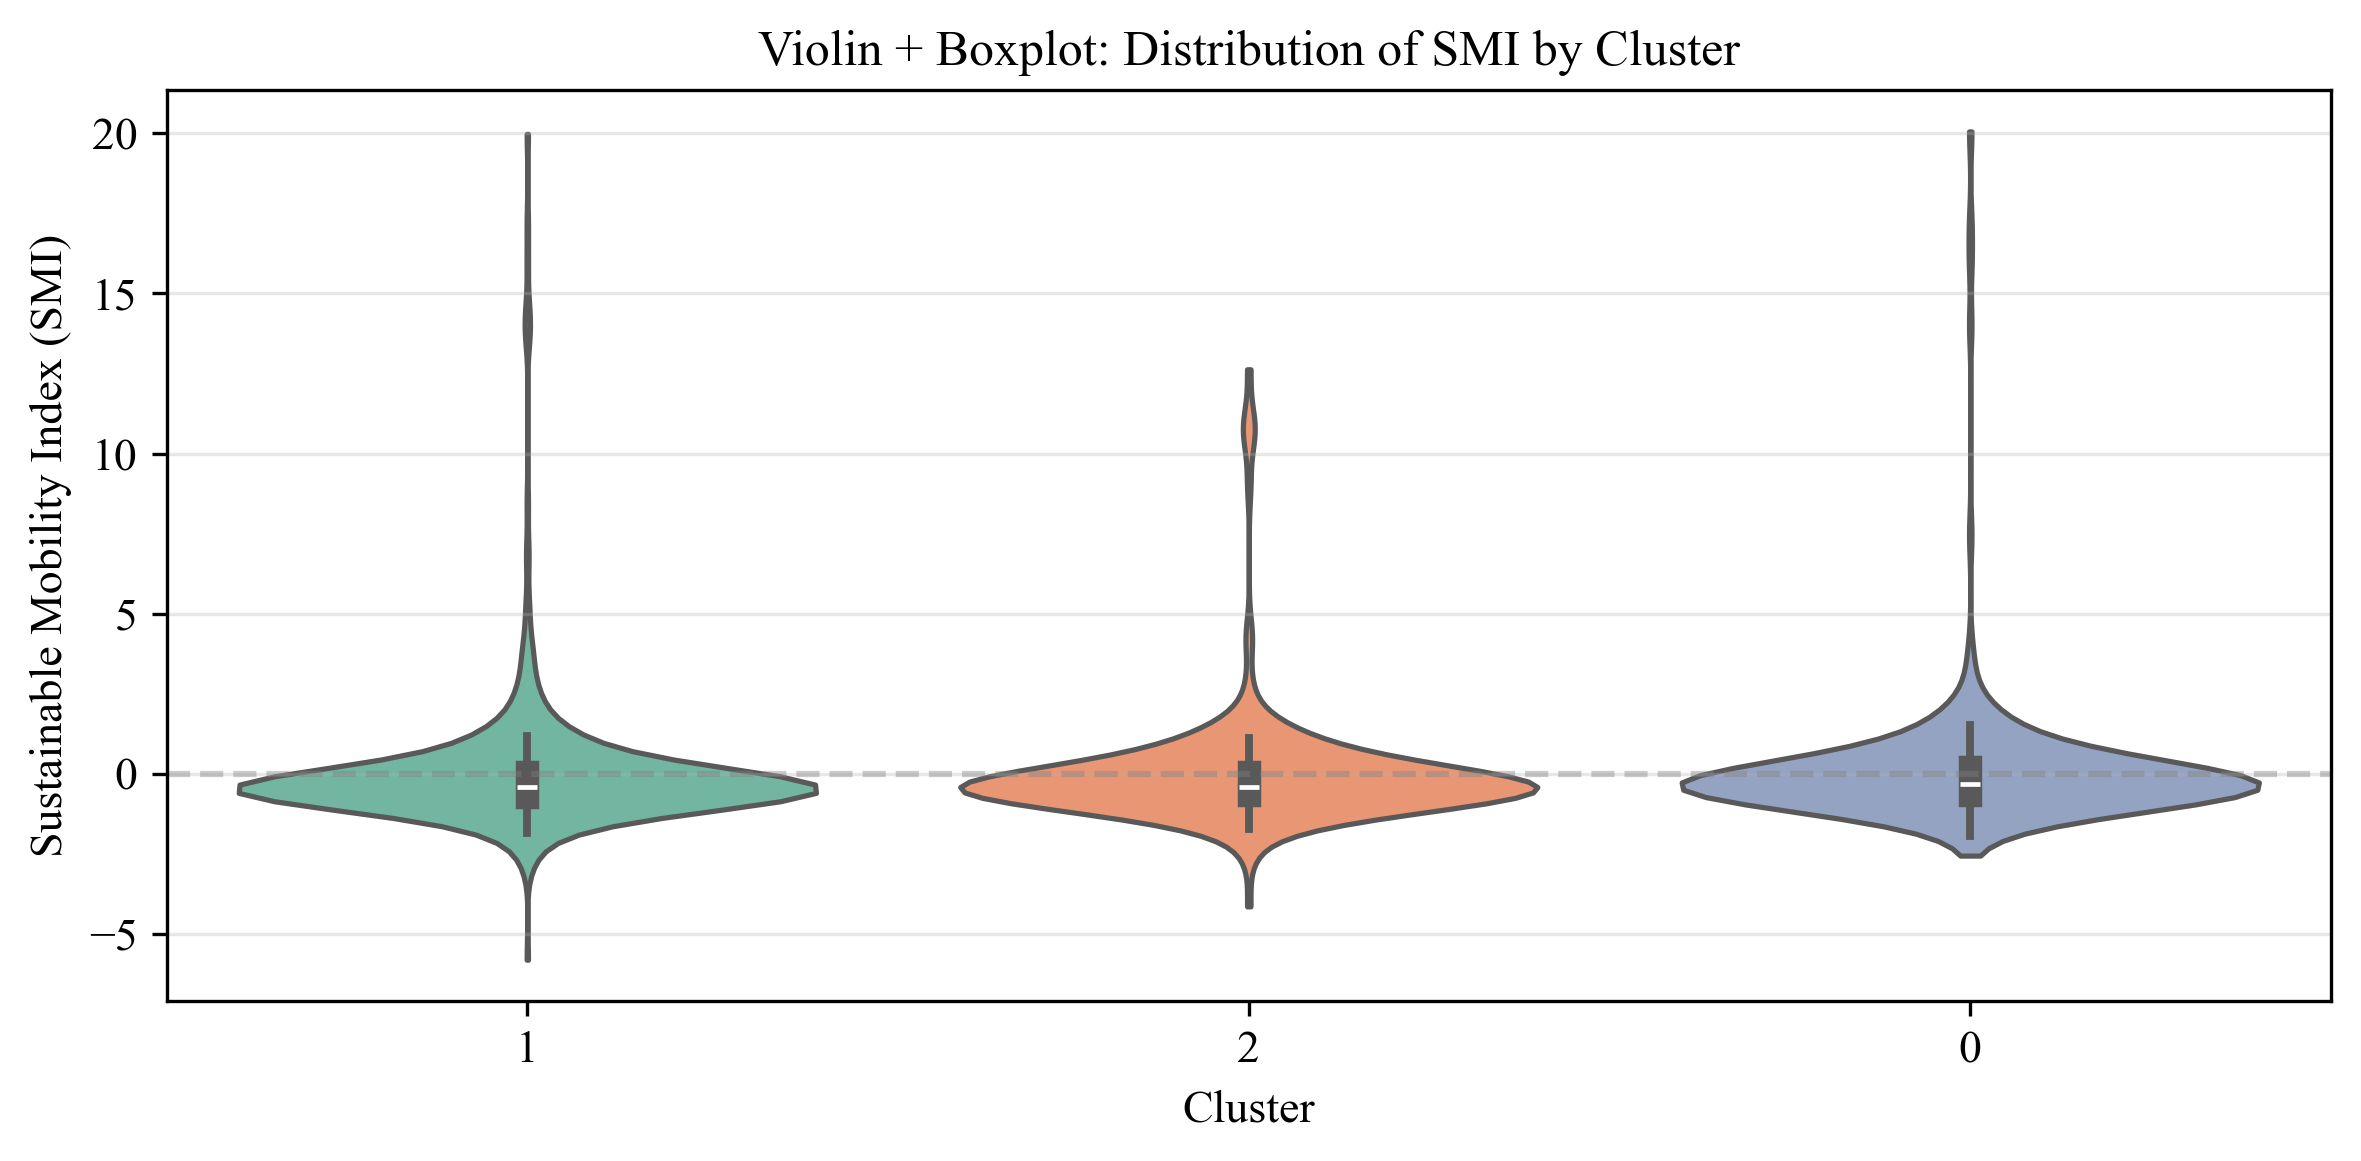

In [33]:
plt.figure(figsize=(8, 4))

# Order clusters by median SMI for visual clarity
order = (df_smi_clustered.groupby("cluster")["smi"]
         .median()
         .sort_values()
         .index)

# Violin plot with internal boxplot
sns.violinplot(x="cluster", y="smi",
               data=df_smi_clustered,
               inner="box", palette="Set2", cut=0,
               order=order)

# Labels and aesthetics
plt.xlabel("Cluster")
plt.ylabel("Sustainable Mobility Index (SMI)")
plt.axhline(0, color='grey', linestyle='--', alpha=0.4)
plt.title("Violin + Boxplot: Distribution of SMI by Cluster")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# --- Step 6: Apply K-Means with chosen k ---
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df_pivot["cluster"] = kmeans.fit_predict(X_scaled)

# --- Step 7: Output country-cluster assignments ---
df_clusters = df_pivot[["cluster"]].reset_index().sort_values("cluster")
print(df_clusters)


(1275, 17)
Index(['country', 'year_month', 'bike', 'bus', 'car', 'car_sharing',
       'electric_car', 'fuel_consumption', 'hybrid_car', 'online_shopping',
       'parking', 'remote_work', 'restaurant', 'ride_hailing', 'supermarket',
       'taxi', 'traffic'],
      dtype='object', name='keyword_common')


In [8]:
df_wide

keyword_common country year_month      bike       bus       car  car_sharing  \
0                   AT    2018-01 -3.189972 -3.824204 -4.368755    -3.323785   
1                   AT    2018-02  0.260807  0.792988  0.275267    -1.358187   
2                   AT    2018-03  0.871406  1.324275  0.195097    -1.325126   
3                   AT    2018-04 -3.189972 -3.824204 -4.368755    -3.323785   
4                   AT    2018-05  1.073766  1.458047 -4.368755    -1.092511   
...                ...        ...       ...       ...       ...          ...   
1270                US    2024-09  0.086569  0.005886  0.418503     0.063460   
1271                US    2024-10  0.088457  0.200398  0.248911    -0.078229   
1272                US    2024-11 -0.999298 -0.480324 -0.178211     0.169362   
1273                US    2024-12  0.643663 -1.128513  0.370349    -0.061795   
1274                US    2025-01 -1.001186  0.005886  0.418503     0.125357   

keyword_common  electric_car  fuel_consumption  hybrid_car  online_shopping  \
0                  -4.215996         -2.451660   -3.628893        -2.912337   
1                  -1.148593         -2.451660   -1.753814         1.580887   
2                  -1.161776          1.143874   -1.278520        -2.912337   
3                  -4.215996         -2.451660   -3.628893        -2.912337   
4                  -0.956240          1.046214   -1.593930         1.340150   
...                      ...               ...         ...              ...   
1270                0.412601          0.252016    0.301002         0.219293   
1271                0.425409          0.265313    0.368415         0.368175   
1272                0.494840          0.551790    0.807740         0.009445   
1273                0.872551          0.201858    0.882724         0.257024   
1274                0.435745          0.395254    0.630496         0.291039   

keyword_common   parking  remote_work  restaurant  ride_hailing  supermarket  \
0              -3.818244    -2.117575   -2.152181     -3.795294    -2.796364   
1               0.447383    -2.072481   -1.939847      2.330981    -2.796364   
2              -0.501141    -2.016909   -1.977294      1.894630    -1.827991   
3              -3.818244    -2.117575   -2.152181     -3.795294    -2.796364   
4               0.217388    -1.898432   -1.667714      1.895724    -1.666559   
...                  ...          ...         ...           ...          ...   
1270            0.303394     0.399509    0.358921      0.092727     0.438302   
1271            0.946957     0.328491    0.639907      0.064971     0.478646   
1272           -0.680720     0.445137   -0.080540     -0.315690     0.493389   
1273            0.250842     0.777229    0.644782     -0.101561     0.779681   
1274           -0.022142     0.457831    0.118772     -0.034160     0.438302   

keyword_common      taxi   traffic  
0              -4.405796 -3.953673  
1               0.609244 -3.953673  
2               0.806717  1.557063  
3              -4.405796 -3.953673  
4               1.274673  1.219611  
...                  ...       ...  
1270           -0.093823 -0.552210  
1271            0.280384  0.391345  
1272           -0.253619 -0.392115  
1273           -0.144388  0.176730  
1274           -0.093823 -0.356345  

[1275 rows x 17 columns]

📈 Varianza explicada por componente:
PC1: 39.054% (λ = 5.86)
PC2: 10.710% (λ = 1.61)
PC3: 6.041% (λ = 0.91)
PC4: 5.085% (λ = 0.76)
PC5: 4.983% (λ = 0.75)
PC6: 4.734% (λ = 0.71)
PC7: 4.362% (λ = 0.65)
PC8: 4.151% (λ = 0.62)
PC9: 3.784% (λ = 0.57)
PC10: 3.594% (λ = 0.54)
PC11: 3.223% (λ = 0.48)
PC12: 3.150% (λ = 0.47)
PC13: 2.880% (λ = 0.43)
PC14: 2.184% (λ = 0.33)
PC15: 2.065% (λ = 0.31)

✅ Componentes con λ > 1 (Regla de Kaiser): 2


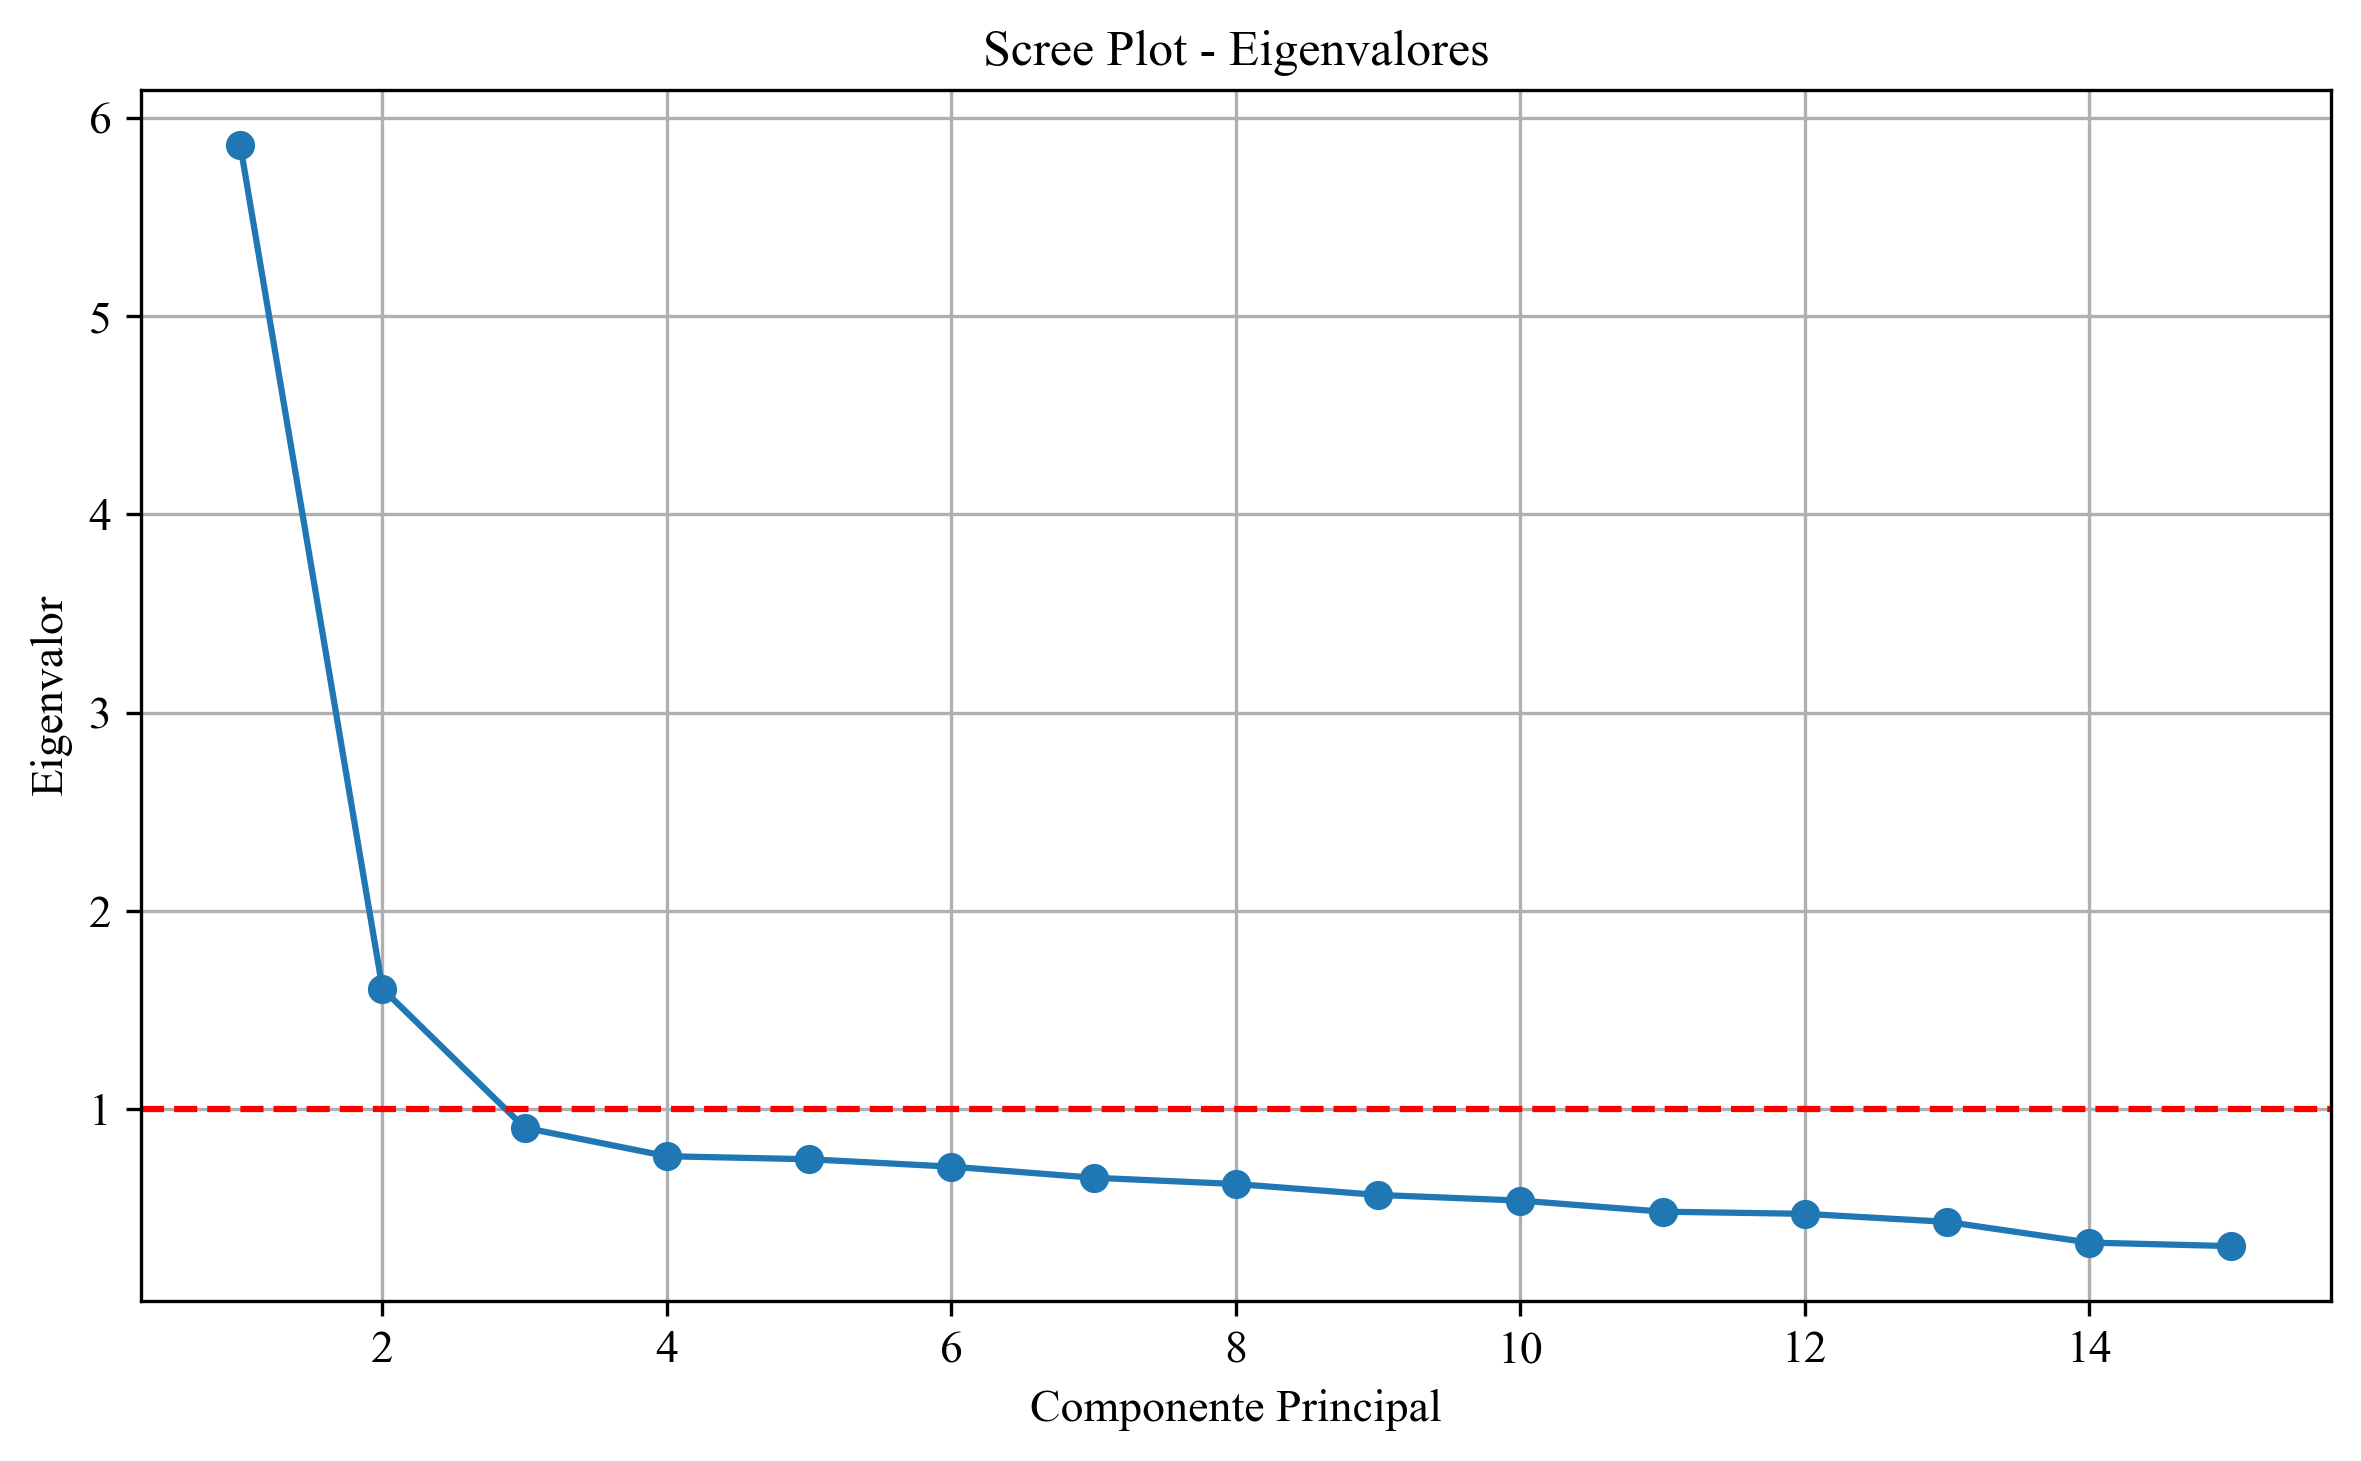

In [18]:
# Paso 1: Transformar y preparar datos (como en tu `preparar_panel_para_pca`)
df_panel_pivot = df_panel.pivot_table(
    index=["date", "country"],
    columns="keyword_common",
    values="zscore"
).reset_index()

# Paso 3: Separar índice y variables
X_vars = df_panel_pivot.drop(columns=["date", "country"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vars)

# Paso 4: Aplicar PCA global
pca_global = PCA()
X_pca = pca_global.fit_transform(X_scaled)

# Paso 5: Extraer resultados
df_scores_global = pd.concat([df_panel_pivot[["date", "country"]].reset_index(drop=True),
                              pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])],
                             axis=1)

df_loadings_global = pd.DataFrame(
    pca_global.components_,
    columns=X_vars.columns,
    index=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

# Paso 6: Scree plot y varianza
eigenvalues = pca_global.explained_variance_
var_exp = pca_global.explained_variance_ratio_

def analizar_componentes(eigenvalues, var_exp):
    print("📈 Varianza explicada por componente:")
    for i, v in enumerate(var_exp):
        print(f"PC{i+1}: {v:.3%} (λ = {eigenvalues[i]:.2f})")
    kaiser_count = np.sum(eigenvalues > 1)
    print(f"\n✅ Componentes con λ > 1 (Regla de Kaiser): {kaiser_count}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
    plt.axhline(y=1, color="red", linestyle="--")
    plt.title("Scree Plot - Eigenvalores")
    plt.xlabel("Componente Principal")
    plt.ylabel("Eigenvalor")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

analizar_componentes(eigenvalues, var_exp)


In [23]:
df_loadings_global.T[["PC1", "PC2", "PC3", "PC4", "PC5"]].sort_values("PC1", ascending=False)


PC1       PC2       PC3       PC4       PC5
keyword_common                                                    
online_shopping   0.216320 -0.032071  0.020327  0.587488 -0.033141
car_sharing       0.201451 -0.071908 -0.128923 -0.447416 -0.446374
traffic           0.170256 -0.445232 -0.167026 -0.028537 -0.045577
fuel_consumption  0.160880 -0.079144 -0.542924  0.238060 -0.187053
taxi             -0.014957 -0.536164 -0.018664 -0.106106  0.009165
bus              -0.026690 -0.507150  0.065654 -0.086900  0.089703
ride_hailing     -0.122364 -0.179896 -0.112523 -0.143418  0.660509
bike             -0.148543 -0.227513  0.245536  0.482516 -0.198008
hybrid_car       -0.156221 -0.019963 -0.616139  0.264993  0.115337
parking          -0.285859 -0.283931  0.115247 -0.039531 -0.198798
car              -0.288661 -0.220351  0.143225  0.094935 -0.143539
charging_station -0.296224  0.083120 -0.309623 -0.180499 -0.358406
remote_work      -0.325828  0.116126  0.206861  0.092585 -0.165122
supermarket      -0.350866  0.094208 -0.082557 -0.053676  0.218493
electric_car     -0.394614  0.010373 -0.104453  0.012616 -0.036509
restaurant       -0.396983  0.039515 -0.113523 -0.000429 -0.027523

C:\Users\34645\AppData\Local\Temp\ipykernel_40936\456157842.py:16: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\34645\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


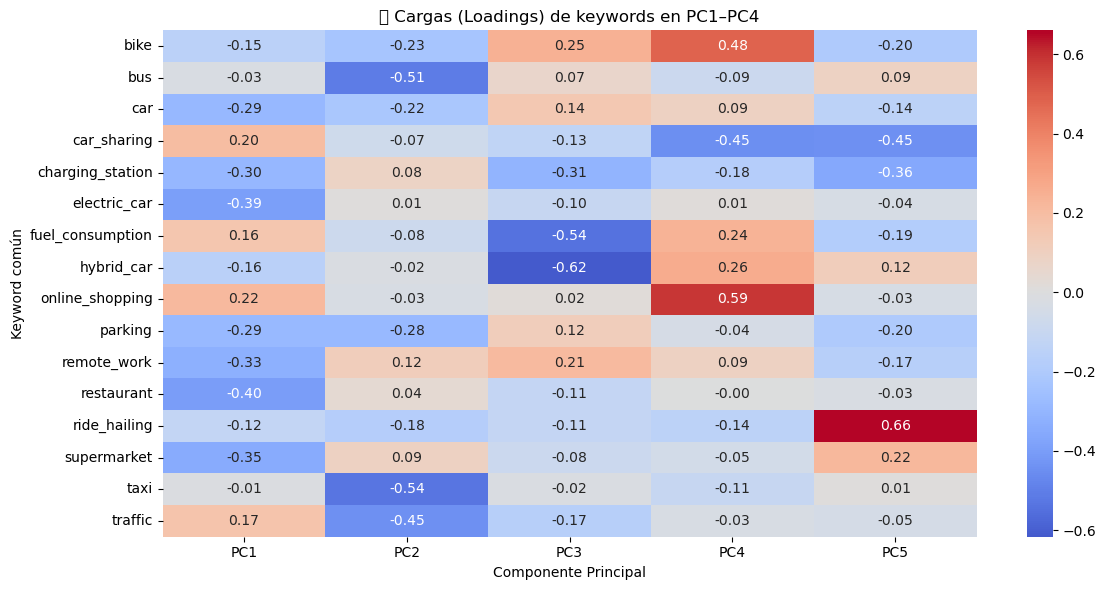

In [25]:
# Suponiendo que ya hiciste un PCA global con esta estructura:
# df_loadings_global = DataFrame con filas PC1, PC2... y columnas = keywords

# 1. Filtrar solo las primeras 4 componentes
loadings_subset = df_loadings_global.loc[["PC1", "PC2", "PC3", "PC4", "PC5"]]

# 2. Transponer para que keywords sean filas y PCs columnas
loadings_plot = loadings_subset.T

# 3. Dibujar heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(loadings_plot, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("🔍 Cargas (Loadings) de keywords en PC1–PC4")
plt.xlabel("Componente Principal")
plt.ylabel("Keyword común")
plt.tight_layout()
plt.show()

C:\Users\34645\AppData\Local\Temp\ipykernel_40936\2134316539.py:13: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.
  plt.tight_layout()
C:\Users\34645\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


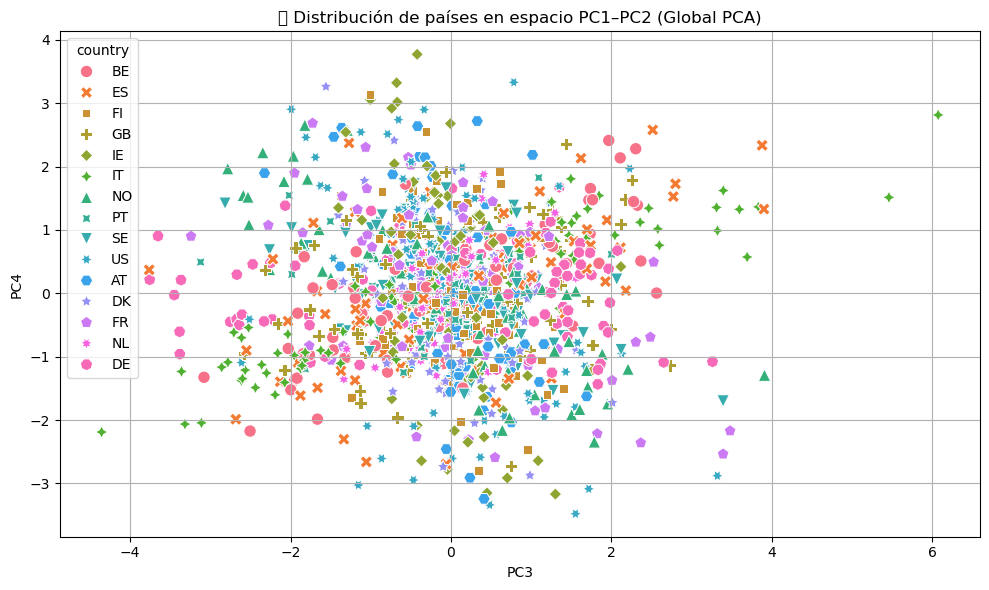

In [29]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_scores_global,
    x="PC3", y="PC4",
    hue="country",
    style="country",
    s=80
)
plt.title("🌍 Distribución de países en espacio PC1–PC2 (Global PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:

# — 1. Si year_month es PeriodDtype, pásalo a Timestamp —
if pd.api.types.is_period_dtype(df_wide['year_month']):
    df_wide['year_month'] = df_wide['year_month'].dt.to_timestamp()

# — 2. Asegúrate de que year_month es datetime64 (opcional verificación) —
df_wide['year_month'] = pd.to_datetime(df_wide['year_month'])
# — 2. Suprimo columnas que no quiero en PCA
cols_to_drop = ['keyword_common', 'country']  # ajusta si aparece otro nombre raro
df_num = df_wide.drop(columns=cols_to_drop, errors='ignore')

# — 3. Preparo el contenedor de resultados
results = []

# — 4. Itero por país
for country, grp in df_wide.groupby('country'):
    # 4.1 saco la serie temporal y filtro solo numéricas
    sub = grp.set_index('year_month')
    X = sub.select_dtypes(include=[np.number]).fillna(0)

    # 4.2 PCA para un solo componente
    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(X)  # devuelve array T×1

    # 4.3 Armo DataFrame con resultados
    df_pc1 = pd.DataFrame({
        'country': country,
        'year_month': X.index,
        'synthetic_index': pc1.ravel(),
        'explained_var': pca.explained_variance_ratio_[0]
    })
    results.append(df_pc1)

# — 5. Concateno todo en un solo DF
df_index = pd.concat(results, ignore_index=True)

# Ya tienes:
# df_index[['country','year_month','synthetic_index','explained_var']]
print(df_index.head())


  country year_month  synthetic_index  explained_var
0      AT 2018-02-01         5.161689       0.651638
1      AT 2018-03-01         7.028441       0.651638
2      AT 2018-05-01         6.657321       0.651638
3      AT 2018-06-01         4.673648       0.651638
4      AT 2018-07-01         4.163748       0.651638


C:\Users\34645\AppData\Local\Temp\ipykernel_40936\2446347854.py:2: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(df_wide['year_month']):


C:\Users\34645\AppData\Local\Temp\ipykernel_40936\3652494626.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\34645\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


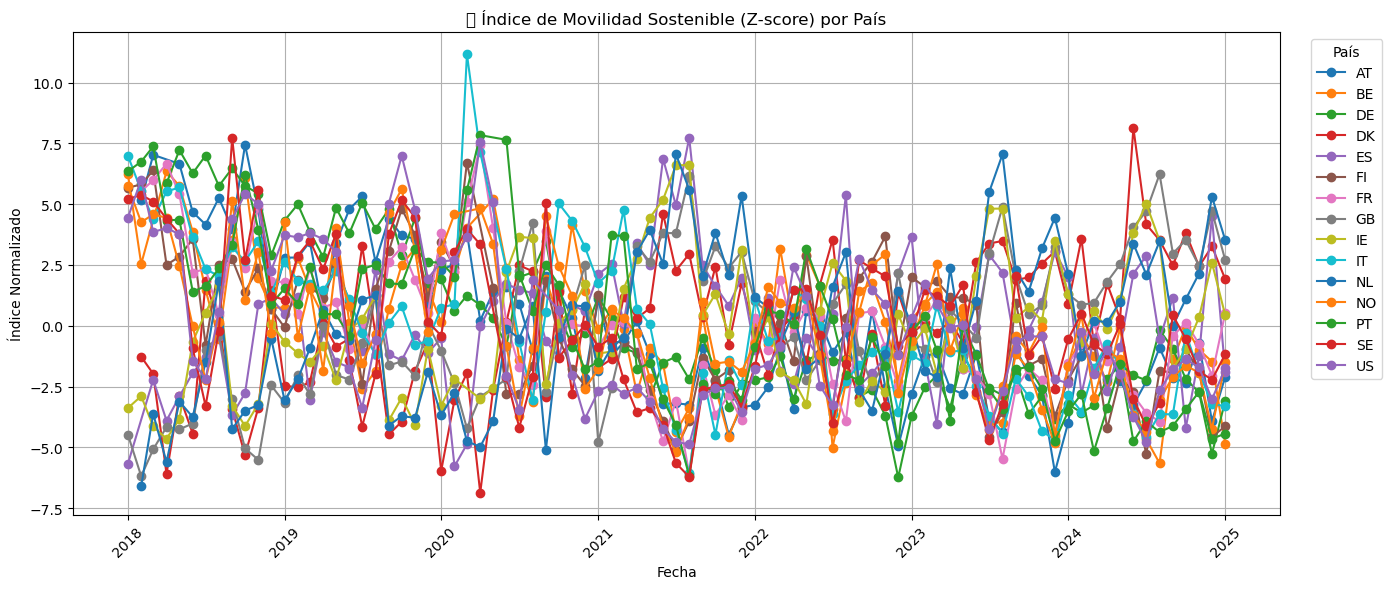

In [31]:
def graficar_indice_por_pais(df_indice, columna="synthetic_index"):
    """
    Grafica la serie temporal del índice de movilidad sostenible por país.

    Parámetros:
        df_indice: DataFrame con columnas 'year_month', 'country' y el índice.
        columna: Nombre de la columna a graficar (por defecto, 'synthetic_index').
    """
    plt.figure(figsize=(14, 6))
    # Recorre cada país y traza su serie
    for country, grupo in df_indice.groupby('country'):
        plt.plot(grupo['year_month'], grupo[columna], marker='o', label=country)

    plt.title("📈 Índice de Movilidad Sostenible (Z-score) por País")
    plt.xlabel("Fecha")
    plt.ylabel("Índice Normalizado")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="País", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

graficar_indice_por_pais(df_index, columna="synthetic_index")


<Axes: xlabel='year_month'>

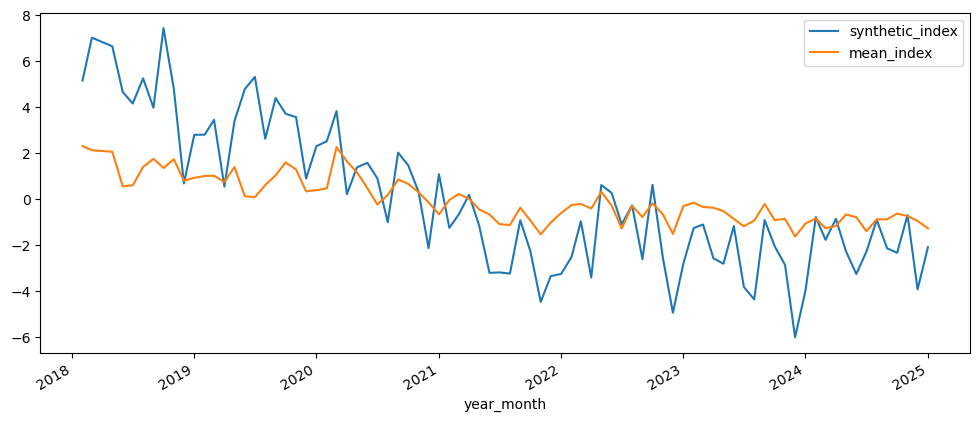

In [32]:
df_avg = df_index.groupby('year_month')['synthetic_index'].mean().reset_index(name='mean_index')
df_at = df_index[df_index['country'] == 'AT'][['year_month', 'synthetic_index']]
df_plot = pd.merge(df_at, df_avg, on='year_month')

df_plot.plot(x='year_month', y=['synthetic_index', 'mean_index'], figsize=(12, 5))


In [33]:
# --- 1. Asegúrate de tener df_wide con columnas: country, year_month, keywords comunes ---
# Si year_month es Period, conviértelo a Timestamp
if pd.api.types.is_period_dtype(df_wide['year_month']):
    df_wide['year_month'] = df_wide['year_month'].dt.to_timestamp()

# Asegura tipo datetime
df_wide['year_month'] = pd.to_datetime(df_wide['year_month'])

# --- 2. Diccionario para guardar las cargas ---
loadings_dict = {}
keywords = [col for col in df_wide.columns if col not in ['country', 'year_month']]

# --- 3. Iterar por país ---
for country, grp in df_wide.groupby('country'):
    sub = grp.set_index('year_month')[keywords].copy()
    X = sub.fillna(0)

    if X.shape[0] < 2:  # saltar si solo hay 1 mes
        continue

    # PCA con 1 componente
    pca = PCA(n_components=1)
    pca.fit(X)

    # Guardar carga (loading) de cada keyword en PC1
    loadings_dict[country] = pca.components_[0]

# --- 4. Crear DataFrame: filas = países, columnas = keywords ---
df_loadings = pd.DataFrame.from_dict(loadings_dict, orient='index', columns=keywords)

# Opcional: mostrar o guardar
print(df_loadings)


        bike       bus       car  car_sharing  charging_station  electric_car  \
AT  0.031490  0.114153 -0.088285    -0.313443         -0.313586     -0.316355   
BE -0.187289 -0.116534 -0.124257    -0.067382         -0.310411     -0.331350   
DE  0.040190  0.106600 -0.209717     0.288139          0.280275     -0.250825   
DK  0.211695  0.088244  0.333836     0.096190          0.320749      0.337315   
ES  0.295562  0.304601  0.183822    -0.319525         -0.141454      0.320476   
FI -0.126941  0.148488 -0.135440     0.010246         -0.352515     -0.351229   
FR -0.288856  0.248636 -0.227786     0.286376         -0.338484     -0.341105   
GB -0.285746 -0.019200  0.111149    -0.245197          0.330024      0.325401   
IE  0.315710 -0.072517  0.108866    -0.202622         -0.048508      0.367093   
IT  0.092350 -0.207339 -0.175137    -0.176451         -0.188891     -0.300942   
NL  0.105755 -0.025164  0.203095    -0.314416          0.318057      0.324426   
NO -0.122829  0.002755 -0.22

C:\Users\34645\AppData\Local\Temp\ipykernel_40936\3398876002.py:3: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(df_wide['year_month']):


In [34]:
df_loadings

bike       bus       car  car_sharing  charging_station  electric_car  \
AT  0.031490  0.114153 -0.088285    -0.313443         -0.313586     -0.316355   
BE -0.187289 -0.116534 -0.124257    -0.067382         -0.310411     -0.331350   
DE  0.040190  0.106600 -0.209717     0.288139          0.280275     -0.250825   
DK  0.211695  0.088244  0.333836     0.096190          0.320749      0.337315   
ES  0.295562  0.304601  0.183822    -0.319525         -0.141454      0.320476   
FI -0.126941  0.148488 -0.135440     0.010246         -0.352515     -0.351229   
FR -0.288856  0.248636 -0.227786     0.286376         -0.338484     -0.341105   
GB -0.285746 -0.019200  0.111149    -0.245197          0.330024      0.325401   
IE  0.315710 -0.072517  0.108866    -0.202622         -0.048508      0.367093   
IT  0.092350 -0.207339 -0.175137    -0.176451         -0.188891     -0.300942   
NL  0.105755 -0.025164  0.203095    -0.314416          0.318057      0.324426   
NO -0.122829  0.002755 -0.225904    -0.022177         -0.348333     -0.119174   
PT -0.113269 -0.260699 -0.268192     0.208979         -0.180653     -0.290007   
SE -0.115999  0.062608 -0.247161     0.264683         -0.317088     -0.269067   
US -0.146216  0.219273 -0.222671     0.281493         -0.304504     -0.313998   

    fuel_consumption  hybrid_car  online_shopping   parking  remote_work  \
AT          0.288158    0.037282         0.294882 -0.149146    -0.313607   
BE          0.009052   -0.338229         0.221333 -0.247909    -0.274540   
DE          0.293802    0.281377         0.119449 -0.259259    -0.294484   
DK          0.051831   -0.327623        -0.335141  0.312755     0.243639   
ES         -0.339436    0.087132         0.173650  0.274760     0.260298   
FI         -0.003771   -0.066995         0.041371 -0.340674    -0.330149   
FR         -0.303972   -0.146835         0.020687 -0.252907    -0.245798   
GB         -0.068544    0.333773        -0.259457  0.034488     0.324625   
IE          0.095666    0.345690         0.158101 -0.025281     0.367257   
IT         -0.299525   -0.303379         0.229736 -0.285995     0.276826   
NL         -0.311366    0.314436        -0.226853  0.102066     0.069070   
NO          0.314724    0.351416         0.340587 -0.226436    -0.354600   
PT          0.273167   -0.181869         0.285507 -0.283634    -0.265999   
SE          0.281128   -0.110301         0.319388 -0.236709    -0.305130   
US         -0.144838   -0.309749        -0.152458 -0.074857    -0.310315   

    restaurant  ride_hailing  supermarket      taxi   traffic  
AT   -0.312561      0.302292    -0.307172  0.136214  0.295907  
BE   -0.321073     -0.322776    -0.308645 -0.119582 -0.328755  
DE   -0.297685     -0.298304    -0.286317  0.221094  0.276387  
DK    0.308706      0.312478     0.054903  0.172151  0.070197  
ES    0.268815      0.012326     0.344773  0.121886 -0.242717  
FI   -0.227211      0.351239     0.307883  0.326209  0.297137  
FR   -0.327828     -0.013439    -0.330495  0.016514  0.184400  
GB    0.320071      0.318011     0.318542 -0.048839 -0.182430  
IE    0.348309      0.188993     0.368868 -0.138633 -0.321812  
IT   -0.296661     -0.305901    -0.289609 -0.288773 -0.136467  
NL    0.318202      0.305774     0.300975 -0.006808 -0.306291  
NO   -0.266243      0.102413    -0.336895 -0.035462  0.293521  
PT   -0.292939      0.189858    -0.241594 -0.294974 -0.281453  
SE   -0.309586     -0.249352    -0.280031  0.066340  0.308797  
US   -0.290797      0.273333    -0.304817  0.243008  0.238950

In [35]:
# — 1. Pivot: países en filas, meses en columnas —
#    df_index debe tener ['country','year_month','synthetic_index']
df_pivot = (
    df_index
    .pivot(index='country', columns='year_month', values='synthetic_index')
    .fillna(0)
)

# — 2. Escalado por mes (para que cada mes pese igual) —
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot)

# — 3. K-Means (elige k = 3 como ejemplo) —
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# — 4. Asignación de cluster por país —
df_clusters = pd.DataFrame({
    'country': df_pivot.index,
    'cluster': labels
}).sort_values('cluster').reset_index(drop=True)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [36]:
df_clusters

country  cluster
0       BE        0
1       FI        0
2       FR        0
3       NO        0
4       SE        0
5       US        0
6       DK        1
7       ES        1
8       GB        1
9       IE        1
10      NL        1
11      AT        2
12      DE        2
13      IT        3
14      PT        3

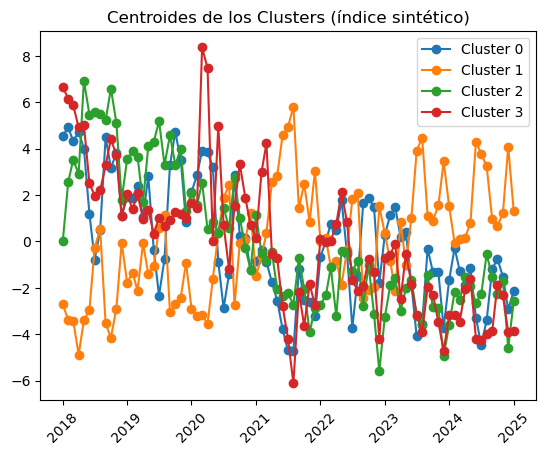

In [37]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
for i, center in enumerate(centers):
    plt.plot(df_pivot.columns, center, marker='o', label=f'Cluster {i}')
plt.xticks(rotation=45)
plt.legend()
plt.title('Centroides de los Clusters (índice sintético)')
plt.show()

In [ ]:
df_indice = calcular_pca_por_pais(df_wide)
df_indice.head() 

keyword_common country year_month  indice_sintetico  var_explicada
0                   AT    2018-11          4.149300       0.619749
1                   AT    2019-01          4.489931       0.619749
2                   AT    2019-09          2.749942       0.619749
3                   AT    2020-01          4.600865       0.619749
4                   AT    2020-08         -0.241218       0.619749

In [ ]:
df_indice

keyword_common country year_month  indice_sintetico  var_explicada
0                   AT    2018-11          4.149300       0.619749
1                   AT    2019-01          4.489931       0.619749
2                   AT    2019-09          2.749942       0.619749
3                   AT    2020-01          4.600865       0.619749
4                   AT    2020-08         -0.241218       0.619749
..                 ...        ...               ...            ...
579                 US    2024-08         -0.969142       0.305584
580                 US    2024-09         -0.739507       0.305584
581                 US    2024-10         -1.060598       0.305584
582                 US    2024-11         -0.907750       0.305584
583                 US    2025-01          1.138661       0.305584

[584 rows x 4 columns]

In [ ]:
import matplotlib.pyplot as plt

# Filtramos la serie: Alemania, electric_car
serie = df_panel[
    (df_panel["country"] == "DE") &
    (df_panel["keyword_common"] == "electric_car")
].sort_values("date")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(serie["date"], serie["zscore"], label="electric_car (DE)")
plt.title("Interés en 'electric_car' en Alemania (z-score)")
plt.xlabel("Fecha")
plt.ylabel("Z-score normalizado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime
from glob import glob
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
COUNTRIES_KEYWORDS = {
    "IT": ["auto", "taxi", "bicicletta", "autobus", "telelavoro",
    "supermercato vicino", "ristorante vicino", "acquisti online",
    "auto elettrica", "colonnina di ricarica", "consumo benzina", "auto ibrida"],
    "FR": [
        "voiture", "taxi", "vélo", "autobus",
        "télétravail", "supermarché proche", "restaurant proche", "achat en ligne",
        "voiture électrique", "borne de recharge", "consommation essence", "voiture hybride"
    ],
    "DE": ["auto", "taxi", "fahrrad", "bus", "homeoffice", "supermarkt in der nähe",
         "restaurant in der nähe", "online einkaufen", "elektroauto",
         "elektroauto aufladen", "benzinverbrauch", "hybridauto"],
    "US": [
        "car", "taxi", "bike", "bus",
        "work from home", "grocery store near me", "restaurant near me", "online shopping",
        "electric car", "charging station", "gas consumption", "hybrid car"
    ],
    "GB": [
        "car", "taxi", "bicycle", "bus",
        "work from home", "supermarket near me", "restaurant near me", "online shopping",
        "electric car", "charging point", "petrol consumption", "hybrid car"
    ],

    "ES": [
        "coche", "taxi", "bicicleta", "autobús",
        "teletrabajo", "supermercado cerca", "restaurante cerca", "compra online",
        "coche eléctrico", "electrolinera", "consumo gasolina", "coche híbrido"
    ],
    "PT": [
        "carro", "táxi", "bicicleta", "autocarro",
        "trabalho remoto", "supermercado perto", "restaurante perto", "compras online",
        "carro elétrico", "posto de carregamento", "consumo gasolina", "carro híbrido"
    ],
    }

In [ ]:

BASE_FOLDER = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_2\x"

# --- Equivalencias comunes ---
COMMON_KEYWORDS = {
    "bicicleta": "bike", "bicycle": "bike", "vélo": "bike", "bicicletta": "bike","fahrrad": "bike",
    "coche": "car", "car": "car", "auto": "car", "voiture": "car", "carro": "car",
    "autobús": "bus", "bus": "bus", "autocarro": "bus", "autobus": "bus",
    "teletrabajo": "remote_work", "work from home": "remote_work", "trabalho remoto": "remote_work", "télétravail": "remote_work", "homeoffice": "remote_work", "telelavoro": "remote_work",
    "supermercado cerca": "supermarket", "supermarket near me": "supermarket", "supermarché proche": "supermarket", "supermercado perto": "supermarket", "supermarkt in der nähe": "supermarket", "supermercato vicino": "supermarket", "grocery store near me": "supermarket",	
    "restaurante cerca": "restaurant", "restaurant near me": "restaurant", "restaurant proche": "restaurant", "restaurante perto": "restaurant", "restaurant in der nähe": "restaurant", "ristorante vicino": "restaurant",
    "compra online": "online_shopping", "online shopping": "online_shopping", "compras online": "online_shopping", "achat en ligne": "online_shopping", "online einkaufen": "online_shopping", "acquisti online": "online_shopping",
    "coche eléctrico": "electric_car", "electric car": "electric_car", "voiture électrique": "electric_car", "auto elettrica": "electric_car", "carro elétrico": "electric_car", "elektroauto": "electric_car",
    "electrolinera": "charging_station", "charging station": "charging_station", "borne de recharge": "charging_station", "posto de carregamento": "charging_station", "charging point": "charging_station", "colonnina di ricarica": "charging_station", "elektroauto aufladen": "charging_station",
    "consumo gasolina": "fuel_consumption", "gas consumption": "fuel_consumption", "consommation essence": "fuel_consumption", "consumo benzina": "fuel_consumption", "petrol consumption": "fuel_consumption", "benzinverbrauch": "fuel_consumption",
    "coche híbrido": "hybrid_car", "hybrid car": "hybrid_car", "voiture hybride": "hybrid_car", "auto ibrida": "hybrid_car", "carro híbrido": "hybrid_car", "hybridauto": "hybrid_car",
    "taxi": "taxi", "táxi": "taxi",
}

# --- Funciones base ---

def rename_value_column(df):
    if "time [UTC]" in df.columns:
        df = df.rename(columns={"time [UTC]": "date"})
    for c in df.columns:
        if c not in ["date", "keywords", "keyword", "country", "muestra_n", "timestamp", "value"]:
            df = df.rename(columns={c: "value"})
            break
    return df

def load_trend_data(base_folder, country, keyword, control_term="wikipedia"):
    def build_path(kw):
        filename = f"x_{country}_{kw.replace(' ', '_')}.csv"
        return os.path.join(base_folder, filename)

    df_x = rename_value_column(pd.read_csv(build_path(keyword)))
    df_comb = rename_value_column(pd.read_csv(build_path(f"{keyword} + {control_term}")))
    df_ctrl = rename_value_column(pd.read_csv(build_path(control_term)))

    return df_x, df_comb, df_ctrl

def get_common_samples(df_x, df_comb, df_ctrl):
    samples_x = set(df_x["muestra_n"])
    samples_comb = set(df_comb["muestra_n"])
    samples_ctrl = set(df_ctrl["muestra_n"])
    return sorted(samples_x & samples_comb & samples_ctrl)

def clean_sample(df, sample_n, value_col="value"):
    df_ = df[df["muestra_n"] == sample_n].copy()
    df_ = df_[~df_[value_col].isin([0, 100])]
    return df_

def imputar_muestra(df_x, df_comb, df_ctrl, sample_n):
    dx = clean_sample(df_x, sample_n)
    dcomb = clean_sample(df_comb, sample_n)
    dctrl = clean_sample(df_ctrl, sample_n)

    df = dx[["date", "value"]].rename(columns={"value": "x"}).copy()
    df = df.merge(dcomb[["date", "value"]].rename(columns={"value": "combined"}), on="date", how="inner")
    df = df.merge(dctrl[["date", "value"]].rename(columns={"value": "control"}), on="date", how="inner")

    if len(df) < 3:
        return None

    X = df[["combined", "control"]]
    y = df["x"]
    model = LinearRegression().fit(X, y)
    df["imputed"] = model.predict(X)
    return df[["date", "imputed"]]

def construir_serie_normalizada_con_imputaciones(base_folder, country, keyword):
    df_x, df_comb, df_ctrl = load_trend_data(base_folder, country, keyword)
    muestras_validas = get_common_samples(df_x, df_comb, df_ctrl)

    imputaciones = []
    for m in muestras_validas:
        df_imp = imputar_muestra(df_x, df_comb, df_ctrl, m)
        if df_imp is not None:
            df_imp["sample_n"] = m
            imputaciones.append(df_imp)

    if not imputaciones:
        return None

    df_all = pd.concat(imputaciones, ignore_index=True)
    df_all["date"] = pd.to_datetime(df_all["date"], format='mixed', errors='coerce')
    df_wide = df_all.pivot(index="date", columns="sample_n", values="imputed")
    df_wide["mean_imputed"] = df_wide.mean(axis=1)

    serie = df_wide["mean_imputed"]
    z = (serie - serie.mean()) / serie.std()

    keyword_common = COMMON_KEYWORDS.get(keyword.lower(), keyword.lower())

    df_z = pd.DataFrame({
        "date": serie.index,
        "keyword": keyword,
        "keyword_common": keyword_common,
        "country": country,
        "imputed": serie.values,
        "zscore": z.values
    }).reset_index(drop=True)

    return df_z

def construir_panel_global(base_folder, country_keywords):
    panel = []
    for country, keywords in country_keywords.items():
        print(f"\n📦 Procesando país: {country}")
        for keyword in keywords:
            print(f"  🔍 Keyword: {keyword}")
            try:
                df_z = construir_serie_normalizada_con_imputaciones(base_folder, country, keyword)
                if df_z is not None:
                    panel.append(df_z)
            except Exception as e:
                print(f"  ⚠️ Error con '{keyword}' en {country}: {e}")
    if panel:
        return pd.concat(panel, ignore_index=True)
    else:
        return None
# --- EJECUTAR PANEL ---
df_panel = construir_panel_global(BASE_FOLDER, COUNTRIES_KEYWORDS)

if df_panel is not None:
    print("✅ Panel generado con éxito. Muestras:", df_panel.shape)


📦 Procesando país: IT
  🔍 Keyword: auto
  🔍 Keyword: taxi
  🔍 Keyword: bicicletta
  🔍 Keyword: autobus
  🔍 Keyword: telelavoro
  🔍 Keyword: supermercato vicino
  🔍 Keyword: ristorante vicino
  🔍 Keyword: acquisti online
  🔍 Keyword: auto elettrica
  🔍 Keyword: colonnina di ricarica
  🔍 Keyword: consumo benzina
  🔍 Keyword: auto ibrida

📦 Procesando país: FR
  🔍 Keyword: voiture
  🔍 Keyword: taxi
  🔍 Keyword: vélo
  🔍 Keyword: autobus
  🔍 Keyword: télétravail
  🔍 Keyword: supermarché proche
  🔍 Keyword: restaurant proche
  🔍 Keyword: achat en ligne
  🔍 Keyword: voiture électrique
  🔍 Keyword: borne de recharge
  🔍 Keyword: consommation essence
  🔍 Keyword: voiture hybride

📦 Procesando país: DE
  🔍 Keyword: auto
  🔍 Keyword: taxi
  🔍 Keyword: fahrrad
  🔍 Keyword: bus
  🔍 Keyword: homeoffice
  🔍 Keyword: supermarkt in der nähe
  🔍 Keyword: restaurant in der nähe
  🔍 Keyword: online einkaufen
  🔍 Keyword: elektroauto
  🔍 Keyword: elektroauto aufladen
  🔍 Keyword: benzinverbrauch
  🔍 Keyw

In [ ]:
# Ruta donde tienes el panel generado
# df_panel ya está construido en tu script previo
# BASE_FOLDER = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_2\x"

# 1. Crear tabla resumen: número de muestras por país y keyword
tabla_resumen = (
    df_panel.groupby(["country", "keyword_common"])
    .agg(
        total_observations=("zscore", "count"),  # Total puntos de datos
        start_date=("date", "min"),              # Primer mes disponible
        end_date=("date", "max")                  # Último mes disponible
    )
    .reset_index()
)

# 2. Opcional: ordenar tabla para que quede más limpia
tabla_resumen = tabla_resumen.sort_values(by=["country", "keyword_common"]).reset_index(drop=True)

# 3. Mostrar pequeña preview
print("📊 Tabla resumen de muestras:")
print(tabla_resumen.head(10))

# 4. Guardar en CSV para apéndice del paper
output_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\result"
os.makedirs(output_path, exist_ok=True)

tabla_resumen.to_csv(os.path.join(output_path, "appendix_trends_samples.csv"), index=False, float_format="%.0f")

print(f"✅ Archivo de apéndice guardado correctamente en {output_path}\\appendix_trends_samples.csv")


📊 Tabla resumen de muestras:
  country    keyword_common  total_observations start_date   end_date
0      DE              bike                  83 2018-01-01 2025-01-01
1      DE               bus                  83 2018-01-01 2025-01-01
2      DE               car                  84 2018-01-01 2025-01-01
3      DE  charging_station                  84 2018-01-01 2025-01-01
4      DE      electric_car                  83 2018-01-01 2025-01-01
5      DE  fuel_consumption                  83 2018-01-01 2025-01-01
6      DE        hybrid_car                  83 2018-01-01 2025-01-01
7      DE   online_shopping                  83 2018-01-01 2025-01-01
8      DE       remote_work                  83 2018-01-01 2025-01-01
9      DE        restaurant                  83 2018-01-01 2025-01-01
✅ Archivo de apéndice guardado correctamente en C:\Users\34645\Desktop\projects\GoogleTrends\result\appendix_trends_samples.csv


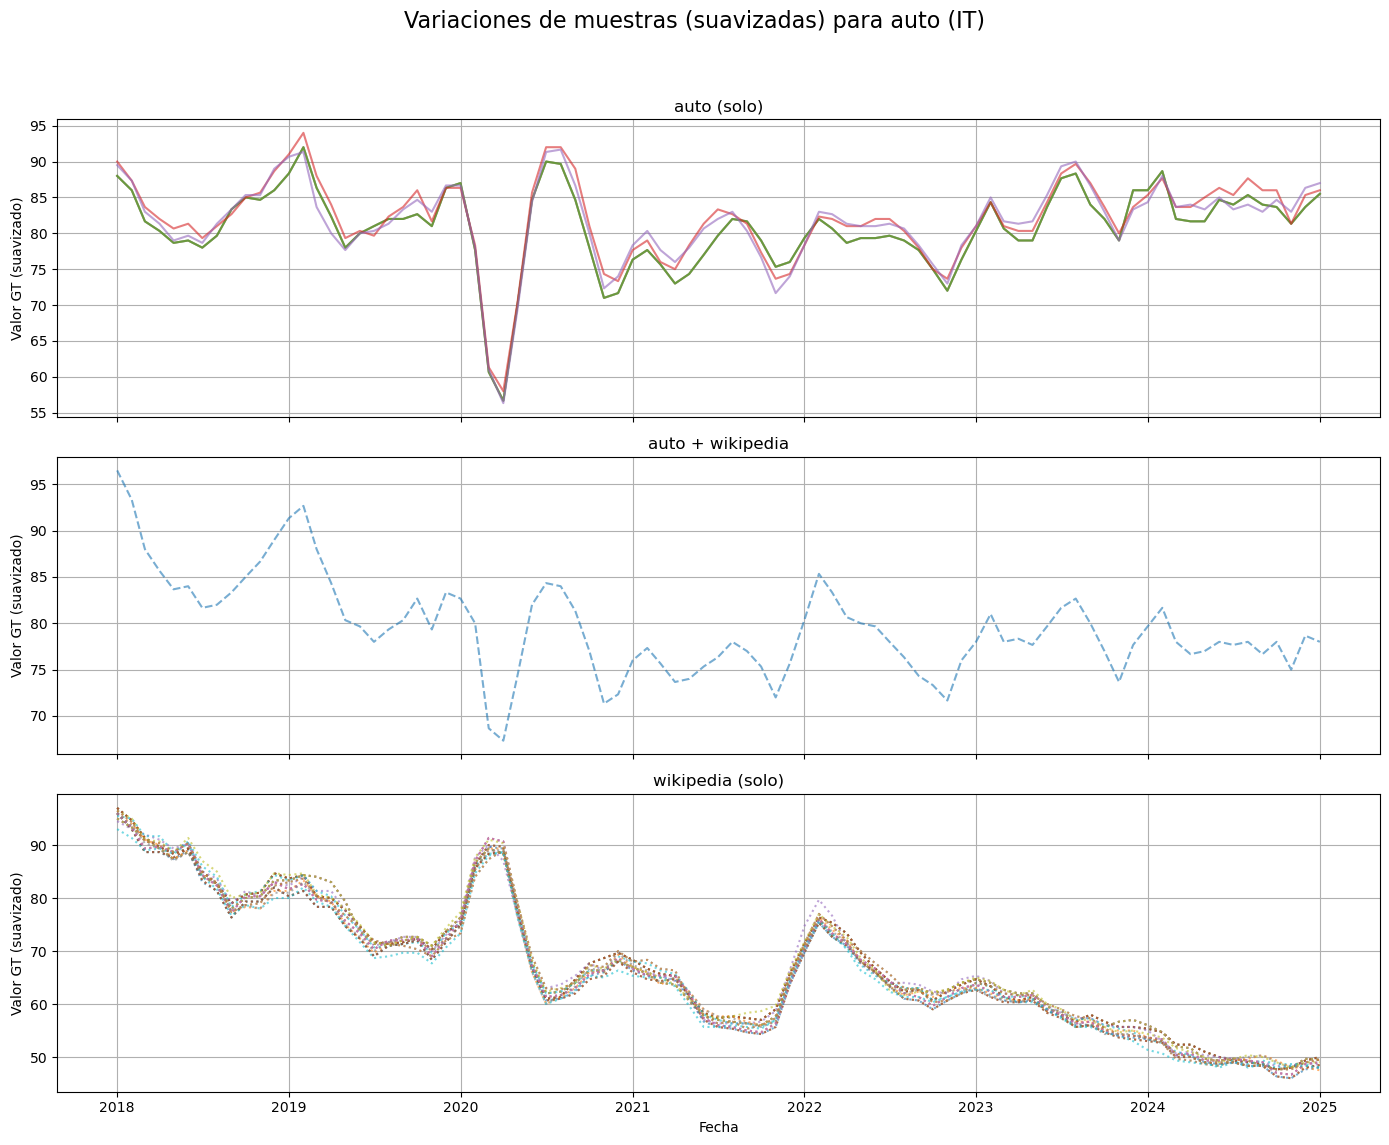

In [ ]:
# --- Configuración ---
BASE_FOLDER = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_2\x"

# --- Funciones auxiliares ---
def rename_value_column(df):
    if "time [UTC]" in df.columns:
        df = df.rename(columns={"time [UTC]": "date"})
    for c in df.columns:
        if c not in ["date", "keywords", "keyword", "country", "muestra_n", "timestamp", "value"]:
            df = df.rename(columns={c: "value"})
            break
    return df

def load_trend_file(country, keyword):
    filename = f"x_{country}_{keyword.replace(' ', '_')}.csv"
    filepath = os.path.join(BASE_FOLDER, filename)
    if not os.path.exists(filepath):
        print(f"❌ Archivo no encontrado: {filepath}")
        return None
    df = pd.read_csv(filepath)
    return rename_value_column(df)

def plot_superpuestas_subplots_suavizado(country, keyword, control="wikipedia", smooth_window=3):
    # Cargar los tres archivos
    df_keyword = load_trend_file(country, keyword)
    df_combined = load_trend_file(country, f"{keyword} + {control}")
    df_control = load_trend_file(country, control)

    if df_keyword is None or df_combined is None or df_control is None:
        print("⚠️ Alguno de los archivos falta, no se puede graficar.")
        return

    # --- Crear figura y subplots ---
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # --- Subplot 1: Keyword solo ---
    axes[0].set_title(f"{keyword} (solo)")
    for sample in sorted(df_keyword["muestra_n"].unique()):
        df_s = df_keyword[df_keyword["muestra_n"] == sample]
        df_s = df_s.sort_values("date")
        dates = pd.to_datetime(df_s["date"], errors="coerce")
        values = df_s["value"].rolling(window=smooth_window, center=True, min_periods=1).mean()
        axes[0].plot(dates, values, alpha=0.6)
    axes[0].grid(True)
    axes[0].set_ylabel("Valor GT (suavizado)")

    # --- Subplot 2: Keyword + Control ---
    axes[1].set_title(f"{keyword} + {control}")
    for sample in sorted(df_combined["muestra_n"].unique()):
        df_s = df_combined[df_combined["muestra_n"] == sample]
        df_s = df_s.sort_values("date")
        dates = pd.to_datetime(df_s["date"], errors="coerce")
        values = df_s["value"].rolling(window=smooth_window, center=True, min_periods=1).mean()
        axes[1].plot(dates, values, linestyle="--", alpha=0.6)
    axes[1].grid(True)
    axes[1].set_ylabel("Valor GT (suavizado)")

    # --- Subplot 3: Control solo ---
    axes[2].set_title(f"{control} (solo)")
    for sample in sorted(df_control["muestra_n"].unique()):
        df_s = df_control[df_control["muestra_n"] == sample]
        df_s = df_s.sort_values("date")
        dates = pd.to_datetime(df_s["date"], errors="coerce")
        values = df_s["value"].rolling(window=smooth_window, center=True, min_periods=1).mean()
        axes[2].plot(dates, values, linestyle=":", alpha=0.6)
    axes[2].grid(True)
    axes[2].set_ylabel("Valor GT (suavizado)")
    axes[2].set_xlabel("Fecha")

    plt.suptitle(f"Variaciones de muestras (suavizadas) para {keyword} ({country})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- USO ---
# Cambias solo país y keyword si quieres otro ejemplo:
plot_superpuestas_subplots_suavizado(country="IT", keyword="auto", control="wikipedia")



In [ ]:
def revisar_keywords_it(base_folder, keywords, country="IT"):
    for kw in keywords:
        files = [
            f"x_{country}_{kw.replace(' ', '_')}.csv",
            f"x_{country}_{kw.replace(' ', '_')}_+_wikipedia.csv",
            f"x_{country}_wikipedia.csv"
        ]
        print(f"🔍 Keyword: {kw}")
        for file in files:
            path = os.path.join(base_folder, file)
            exists = os.path.exists(path)
            print(f"   - {'✅' if exists else '❌'} {file}")

# Lista original de keywords de IT
keywords_it = [
    "auto", "taxi", "bicicletta", "autobus", "telelavoro",
    "supermercato vicino", "ristorante vicino", "acquisti online",
    "auto elettrica", "colonnina di ricarica", "consumo benzina", "auto ibrida"
]

# Cambia esto a tu ruta de datos reales
carpeta_datos = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_2\x"

revisar_keywords_it(carpeta_datos, keywords_it)


🔍 Keyword: auto
   - ✅ x_IT_auto.csv
   - ✅ x_IT_auto_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: taxi
   - ✅ x_IT_taxi.csv
   - ✅ x_IT_taxi_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: bicicletta
   - ✅ x_IT_bicicletta.csv
   - ✅ x_IT_bicicletta_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: autobus
   - ✅ x_IT_autobus.csv
   - ✅ x_IT_autobus_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: telelavoro
   - ✅ x_IT_telelavoro.csv
   - ✅ x_IT_telelavoro_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: supermercato vicino
   - ✅ x_IT_supermercato_vicino.csv
   - ✅ x_IT_supermercato_vicino_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: ristorante vicino
   - ✅ x_IT_ristorante_vicino.csv
   - ✅ x_IT_ristorante_vicino_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: acquisti online
   - ✅ x_IT_acquisti_online.csv
   - ✅ x_IT_acquisti_online_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: auto elettrica
   - ✅ x_IT_auto_elettrica.csv
   - ✅ x_IT_a

In [ ]:
df_panel

date        keyword keyword_common country    imputed    zscore
0    2018-01-01           taxi           taxi      IT  45.146895 -0.527706
1    2018-02-01           taxi           taxi      IT  32.615882 -1.367146
2    2018-03-01           taxi           taxi      IT  50.112674 -0.195053
3    2018-04-01           taxi           taxi      IT  54.031010  0.067432
4    2018-06-01           taxi           taxi      IT  56.172523  0.210890
...         ...            ...            ...     ...        ...       ...
6794 2024-09-01  carro híbrido     hybrid_car      PT  64.692173  1.442934
6795 2024-10-01  carro híbrido     hybrid_car      PT  65.063214  1.483347
6796 2024-11-01  carro híbrido     hybrid_car      PT  65.733456  1.556348
6797 2024-12-01  carro híbrido     hybrid_car      PT  64.352786  1.405969
6798 2025-01-01  carro híbrido     hybrid_car      PT  67.833892  1.785122

[6799 rows x 6 columns]

In [ ]:
def verificar_keywords_por_pais(df_panel):
    conteo = df_panel.groupby("country")["keyword_common"].nunique().sort_values()
    print("🔎 Número de keywords comunes por país:\n")
    print(conteo)
    return conteo

In [ ]:
verificar_keywords_por_pais(df_panel)


🔎 Número de keywords comunes por país:

country
IT    10
DE    12
ES    12
FR    12
GB    12
PT    12
US    12
Name: keyword_common, dtype: int64


country
IT    10
DE    12
ES    12
FR    12
GB    12
PT    12
US    12
Name: keyword_common, dtype: int64

In [ ]:
def filtrar_keywords_comunes(df_panel):
    # Paso 1: obtener cuántos países hay
    total_paises = df_panel["country"].nunique()

    # Paso 2: contar en cuántos países aparece cada keyword_common
    cobertura = df_panel.groupby("keyword_common")["country"].nunique()

    # Paso 3: seleccionar solo las que aparecen en todos los países
    keywords_validas = cobertura[cobertura == total_paises].index.tolist()

    # Paso 4: filtrar el panel
    df_filtrado = df_panel[df_panel["keyword_common"].isin(keywords_validas)].copy()

    return df_filtrado, keywords_validas

In [ ]:
df_panel_filtrado, keywords_comunes_usadas = filtrar_keywords_comunes(df_panel)

print("✅ Keywords comunes retenidas:", keywords_comunes_usadas)

✅ Keywords comunes retenidas: ['bike', 'bus', 'charging_station', 'electric_car', 'fuel_consumption', 'online_shopping', 'remote_work', 'restaurant', 'supermarket', 'taxi']


📈 Varianza explicada por componente:
PC1: 32.653% (λ = 3.60)
PC2: 17.790% (λ = 1.96)
PC3: 13.141% (λ = 1.45)
PC4: 10.064% (λ = 1.11)
PC5: 6.841% (λ = 0.75)
PC6: 5.981% (λ = 0.66)
PC7: 4.656% (λ = 0.51)
PC8: 3.293% (λ = 0.36)
PC9: 2.633% (λ = 0.29)
PC10: 1.771% (λ = 0.20)
PC11: 1.177% (λ = 0.13)

✅ Componentes con λ > 1 (Regla de Kaiser): 4


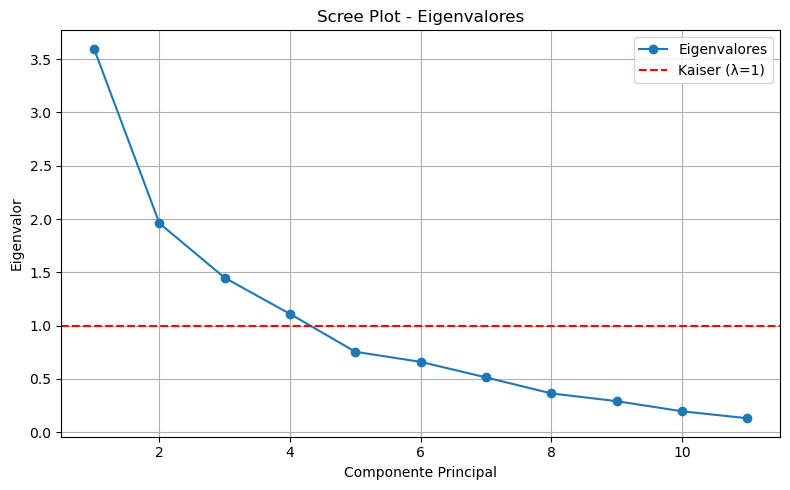


📊 Primeras filas de los scores:
        date country       PC1       PC2       PC3       PC4       PC5  \
0 2018-01-01      DE  1.444438  1.102064  3.845481 -1.991804  1.271960   
1 2018-01-01      FR  2.593970 -2.014625  0.333891 -2.050841  1.588621   
2 2018-01-01      GB  2.950085 -2.111610  0.429483  1.097741 -0.781662   
3 2018-01-01      IT  2.006420 -1.126010 -3.544272 -1.769741  1.674838   
4 2018-01-01      PT  4.184212  0.910749  2.077935 -0.706454 -0.899688   

        PC6       PC7       PC8       PC9      PC10      PC11  
0  0.254909 -0.322654 -0.489380  0.522602 -0.152536  0.268533  
1  1.112446  0.154077 -0.842454 -0.437352 -0.536336 -0.063313  
2 -0.495601  1.677293 -0.221114  0.663287  0.202284 -0.673546  
3 -0.245527 -0.111685 -0.435397  0.755247 -0.660602  0.344949  
4 -1.258501  0.070515 -1.152092 -0.694265 -0.366034  0.611287  

🔍 Cargas (loadings):
keyword_common      bike       bus       car  electric_car  fuel_consumption  \
PC1            -0.085379 -0.161762 -

In [ ]:

# ---------------------
# 1. Preparar el panel
# ---------------------
def preparar_panel_para_pca(df_panel, eliminar_columnas=None, metodo_imputacion="media"):
    df_pivot = df_panel.pivot_table(
        index=["date", "country"],
        columns="keyword_common",
        values="zscore"
    ).reset_index()

    if eliminar_columnas:
        df_pivot = df_pivot.drop(columns=eliminar_columnas, errors="ignore")

    if metodo_imputacion == "media":
        df_pivot_imputado = df_pivot.fillna(df_pivot.mean(numeric_only=True))
    elif metodo_imputacion == "mediana":
        df_pivot_imputado = df_pivot.fillna(df_pivot.median(numeric_only=True))
    else:
        raise ValueError("Método de imputación no reconocido")

    return df_pivot_imputado

# ---------------------
# 2. Aplicar PCA
# ---------------------
def aplicar_pca(df_pivot, n_components=None):
    df_index = df_pivot[["date", "country"]]
    df_vars = df_pivot.drop(columns=["date", "country"])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_vars)

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X_scaled)

    df_scores = pd.DataFrame(components, columns=[f"PC{i+1}" for i in range(components.shape[1])])
    df_scores = pd.concat([df_index.reset_index(drop=True), df_scores], axis=1)

    df_loadings = pd.DataFrame(
        pca.components_, 
        columns=df_vars.columns, 
        index=[f"PC{i+1}" for i in range(pca.n_components_)]
    )

    var_exp = pca.explained_variance_ratio_
    eigenvalues = pca.explained_variance_

    return df_scores, df_loadings, var_exp, eigenvalues

# ---------------------
# 3. Regla de Kaiser + Scree Plot
# ---------------------
def analizar_componentes(eigenvalues, var_exp):
    print("📈 Varianza explicada por componente:")
    for i, v in enumerate(var_exp):
        print(f"PC{i+1}: {v:.3%} (λ = {eigenvalues[i]:.2f})")

    kaiser_count = np.sum(eigenvalues > 1)
    print(f"\n✅ Componentes con λ > 1 (Regla de Kaiser): {kaiser_count}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', label="Eigenvalores")
    plt.axhline(y=1, color="red", linestyle="--", label="Kaiser (λ=1)")
    plt.title("Scree Plot - Eigenvalores")
    plt.xlabel("Componente Principal")
    plt.ylabel("Eigenvalor")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------
# 4. EJECUTAR TODO
# ---------------------
# Tus datos originales: df_panel
# Preparar el panel
df_pivot_pca = preparar_panel_para_pca(
    df_panel,
    eliminar_columnas=["charging_station"],  # quita variables si hace falta
    metodo_imputacion="media"                # o "mediana"
)

# Aplicar PCA
df_scores, df_loadings, var_exp, eigenvalues = aplicar_pca(df_pivot_pca)

# Analizar varianza
analizar_componentes(eigenvalues, var_exp)

# Mostrar resultados (opcionales)
print("\n📊 Primeras filas de los scores:")
print(df_scores.head())

print("\n🔍 Cargas (loadings):")
print(df_loadings)

In [ ]:
def construir_indice_sostenible(df_scores, var_exp, eigenvalues):
    """
    Construye un índice de movilidad sostenible a partir de los componentes con λ > 1,
    ponderados por su varianza explicada.
    """
    # 1. Seleccionar componentes válidas (λ > 1)
    indices_kaiser = np.where(eigenvalues > 1)[0]
    pcs_validas = [f"PC{i+1}" for i in indices_kaiser]

    if not pcs_validas:
        raise ValueError("No hay componentes con eigenvalor > 1 (Kaiser)")

    # 2. Ponderaciones normalizadas
    pesos = var_exp[indices_kaiser]
    pesos_normalizados = pesos / pesos.sum()

    # 3. Calcular índice ponderado
    matriz_componentes = df_scores[pcs_validas].values
    indice = np.dot(matriz_componentes, pesos_normalizados)

    df_indice = df_scores[["date", "country"]].copy()
    df_indice["movilidad_sostenible"] = indice

    # 4. Normalizar (Z-score global)
    z = (df_indice["movilidad_sostenible"] - df_indice["movilidad_sostenible"].mean()) / df_indice["movilidad_sostenible"].std()
    df_indice["indice_normalizado"] = z

    return df_indice


In [ ]:
df_indice = construir_indice_sostenible(df_scores, var_exp, eigenvalues)

print("📊 Índice de movilidad sostenible por país y fecha:")
print(df_indice.head())

📊 Índice de movilidad sostenible por país y fecha:
        date country  movilidad_sostenible  indice_normalizado
0 2018-01-01      DE              1.320575            1.401042
1 2018-01-01      FR              0.442751            0.469729
2 2018-01-01      GB              1.024528            1.086956
3 2018-01-01      IT             -0.256650           -0.272288
4 2018-01-01      PT              2.349350            2.492503


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def graficar_indice_por_pais(df_indice, columna="indice_normalizado"):
    """
    Grafica la serie temporal del índice de movilidad sostenible por país.
    
    Parámetros:
        df_indice: DataFrame con columnas 'date', 'country' y el índice.
        columna: Nombre de la columna a graficar (por defecto, índice normalizado).
    """
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df_indice, x="date", y=columna, hue="country", marker="o")
    
    plt.title("📈 Índice de Movilidad Sostenible (Z-score) por País")
    plt.xlabel("Fecha")
    plt.ylabel("Índice Normalizado")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title="País", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.show()


C:\Users\34645\AppData\Local\Temp\ipykernel_20972\1769368297.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\34645\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


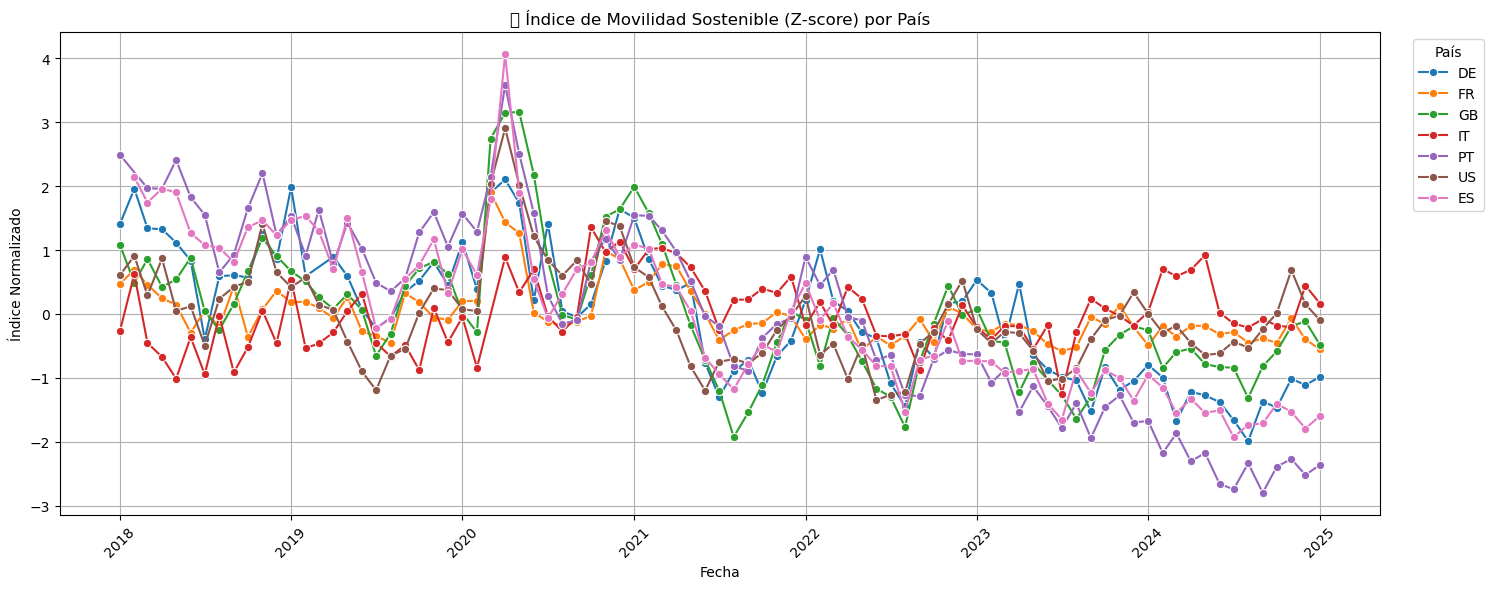

In [ ]:
graficar_indice_por_pais(df_indice)


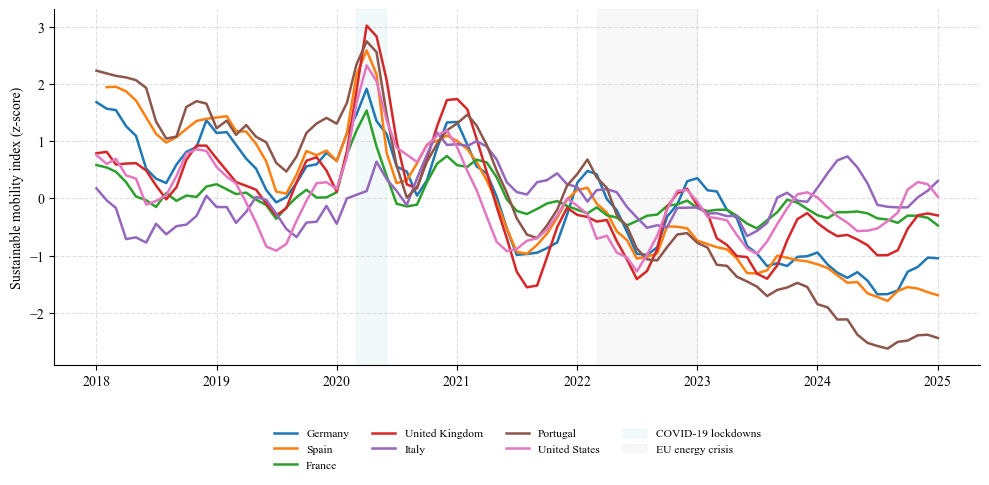

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "font.family": "Times new roman",
    "font.size": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.4,
    "legend.frameon": False
})

# Suponiendo que ya tienes `df_indice` procesado como antes:
df_plot = (
    df_indice
      .sort_values("date")
      .assign(IDMS_smooth=lambda d: d.groupby("country")["indice_normalizado"]
                                      .transform(lambda s: s.rolling(3, center=True, min_periods=1).mean()))
)

# Etiquetas país en orden deseado
country_labels = {
    "DE": "Germany", "FR": "France", "GB": "United Kingdom",
    "IT": "Italy", "PT": "Portugal", "US": "United States", "ES": "Spain"
}

fig, ax = plt.subplots()

for country, g in df_plot.groupby("country"):
    label = country_labels.get(country, country)
    ax.plot(g["date"], g["IDMS_smooth"], label=label, linewidth=1.8)

# Eventos globales
ax.axvspan(pd.Timestamp("2020-03-01"), pd.Timestamp("2020-05-31"),
           alpha=.15, color="lightblue", label="COVID-19 lockdowns")
ax.axvspan(pd.Timestamp("2022-03-01"), pd.Timestamp("2022-12-31"),
           alpha=.15, color="lightgrey", label="EU energy crisis")

# Ejes
ax.set_ylabel("Sustainable mobility index (z-score)")

# Leyenda abajo, centrada
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    fontsize="small"
)

plt.tight_layout()
plt.show()


In [ ]:
df_indice['country'].unique()

array(['DE', 'FR', 'GB', 'IT', 'PT', 'US', 'ES'], dtype=object)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\34645\AppData\Local\Temp\ipykernel_20972\3370676903.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last["cluster"] = model.labels_


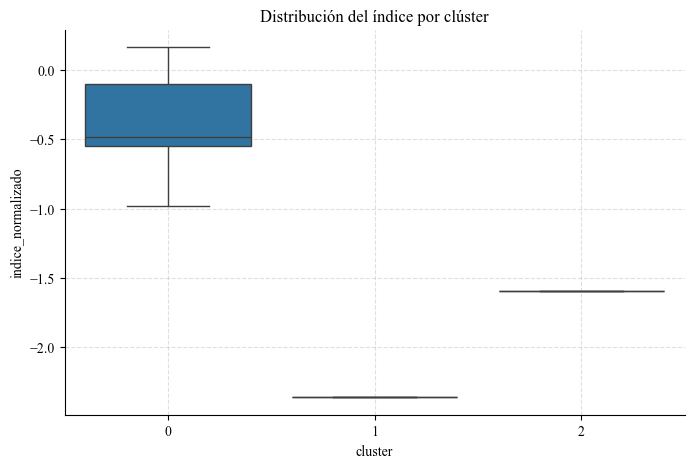

In [ ]:
from sklearn.cluster import KMeans

def clustering_preliminar(df_indice, k=3):
    df_last = df_indice[df_indice["date"] == df_indice["date"].max()]
    model = KMeans(n_clusters=k, random_state=0).fit(df_last[["indice_normalizado"]])
    df_last["cluster"] = model.labels_
    return df_last

df_clusters = clustering_preliminar(df_indice)

# Visualizar
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_clusters, x="cluster", y="indice_normalizado")
plt.title("Distribución del índice por clúster")
plt.grid(True)
plt.show()

In [ ]:
df_clusters = clustering_preliminar(df_indice, k=3)

# Agrupar por país y clúster asignado
asignacion_clusters = df_clusters[["country", "cluster"]].sort_values("cluster")
print(asignacion_clusters)

    country  cluster
584      DE        0
586      FR        0
587      GB        0
588      IT        0
590      US        0
589      PT        1
585      ES        2


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\34645\AppData\Local\Temp\ipykernel_20972\3370676903.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last["cluster"] = model.labels_


In [ ]:
print("📌 Asignación de países a clústeres:")
for c in sorted(df_clusters["cluster"].unique()):
    paises = df_clusters[df_clusters["cluster"] == c]["country"].tolist()
    print(f"🔹 Cluster {c}: {', '.join(paises)}")


📌 Asignación de países a clústeres:
🔹 Cluster 0: DE, FR, GB, IT, US
🔹 Cluster 1: PT
🔹 Cluster 2: ES


In [ ]:
import pandas as pd

# --- 1. Leer archivos de CPI desde OCDE
path_base = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory"

df_all = pd.read_csv(f"{path_base}\\cpi_all.csv")
df_transport = pd.read_csv(f"{path_base}\\cpi_transport.csv")
df_energy = pd.read_csv(f"{path_base}\\cpi_energy.csv")

# --- 2. Función de limpieza
def limpiar_cpi(df, value_name):
    df = df[["REF_AREA", "TIME_PERIOD", "OBS_VALUE"]].copy()
    df.columns = ["country", "month", value_name]
    df["month"] = pd.to_datetime(df["month"]).dt.to_period("M").astype(str)
    df[value_name] = pd.to_numeric(df[value_name], errors="coerce")
    return df

# --- 3. Limpiar datasets OCDE
df_all = limpiar_cpi(df_all, "cpi_all")
df_transport = limpiar_cpi(df_transport, "cpi_transport")
df_energy = limpiar_cpi(df_energy, "cpi_energy")

# --- 4. Homogeneizar códigos ISO (ISO3 → ISO2)
iso_map = {
    "DEU": "DE", "FRA": "FR", "GBR": "GB",
    "ITA": "IT", "PRT": "PT", "USA": "US", "ESP": "ES"
}

for df in [df_all, df_transport, df_energy]:
    df["country"] = df["country"].map(iso_map)

# --- 5. Cargar CPI energético desde FRED (solo para USA)
df_us_energy = pd.read_csv(f"{path_base}\\cpi_us.csv")

# --- 6. Limpiar CPI energético USA
df_us_energy["month"] = pd.to_datetime(df_us_energy["observation_date"]).dt.to_period("M").astype(str)
df_us_energy["country"] = "US"
df_us_energy = df_us_energy.rename(columns={"CPGREN01USM659N": "cpi_energy"})
df_us_energy = df_us_energy[["country", "month", "cpi_energy"]]

# --- 7. Reemplazar o añadir CPI energético de USA en df_energy
#     Elimina filas anteriores de USA y concatena las nuevas
df_energy = df_energy[df_energy["country"] != "US"]
df_energy = pd.concat([df_energy, df_us_energy], ignore_index=True)

# --- 8. Combinar los tres CPI en un único DataFrame
df_cpi_combined = df_all.merge(df_transport, on=["country", "month"], how="outer")
df_cpi_combined = df_cpi_combined.merge(df_energy, on=["country", "month"], how="outer")

# --- 9. Crear columna 'month' en df_indice si no existe
df_indice["month"] = df_indice["date"].dt.to_period("M").astype(str)

# --- 10. Merge final con el panel
df_model = pd.merge(df_indice, df_cpi_combined, on=["country", "month"], how="left")


In [ ]:
# Ruta al archivo original del boletín
file_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\Weekly_Oil_Bulletin_Prices_History.xlsx"

def load_fuel_prices(file_path, countries=['DE', 'FR', 'UK', 'IT', 'PT', 'ES']):
    df = pd.read_excel(file_path, sheet_name="Prices with taxes", header=[0, 1, 2])

    # Detectar la columna de fechas (triple nivel)
    date_col = [col for col in df.columns if isinstance(col, tuple) and 'Date' in col[2]][0]
    df['Date'] = pd.to_datetime(df[date_col], errors='coerce')
    df = df[df['Date'].notna()]

    tidy = []

    for iso2 in countries:
        # Buscar columnas de gasolina y diésel
        petrol_cols = [col for col in df.columns if col[0] == f"{iso2}_price_with_tax_euro95"]
        diesel_cols = [col for col in df.columns if col[0] == f"{iso2}_price_with_tax_diesel"]

        if petrol_cols:
            tmp = pd.DataFrame({
                'country': iso2,
                'date_daily': df['Date'],
                'variable': 'fuel_price_euro95',
                'value': pd.to_numeric(df[petrol_cols[0]], errors='coerce')
            })
            tidy.append(tmp)

        if diesel_cols:
            tmp = pd.DataFrame({
                'country': iso2,
                'date_daily': df['Date'],
                'variable': 'fuel_price_diesel',
                'value': pd.to_numeric(df[diesel_cols[0]], errors='coerce')
            })
            tidy.append(tmp)

    # Unir todos los países
    fuel_long = pd.concat(tidy, ignore_index=True)
    fuel_long['value'] = fuel_long['value'] / 1000  # €/1000L → €/L
    fuel_long['date'] = fuel_long['date_daily'].dt.to_period('M')

    # Agregar promedio mensual por país y tipo
    fuel_month = (
        fuel_long
        .groupby(['country', 'date', 'variable'], as_index=False)['value']
        .mean()
    )

    # Normalizar códigos país: UK → GB
    fuel_month['country'] = fuel_month['country'].replace({'UK': 'GB'})

    # Filtrar ventana del panel
    fuel_month = fuel_month[
        (fuel_month['date'] >= '2018-01') & (fuel_month['date'] <= '2025-03')
    ]

    return fuel_month

# Ejecutar función con 'UK' y luego mapear a 'GB'
fuel_df = load_fuel_prices(file_path)

# Pivotear a formato ancho
fuel_wide = (
    fuel_df.pivot(index=['country', 'date'], columns='variable', values='value')
           .reset_index()
)

# Asegurar tipo Period[M] para merge
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

# Merge con el panel principal
df_model = df_model.merge(fuel_wide, how='left', on=['country', 'date'])

# Vista rápida
df_model[df_model['country'] == 'GB'][['date', 'fuel_price_diesel', 'fuel_price_euro95']].dropna().head()



C:\Users\34645\AppData\Local\Temp\ipykernel_20972\2540306633.py:69: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


date  fuel_price_diesel  fuel_price_euro95
2   2018-01           1.407658           1.367884
9   2018-02           1.407462           1.367095
15  2018-03           1.394727           1.352677
22  2018-04           1.429962           1.386757
29  2018-05           1.471450           1.426235

In [ ]:
# Ruta a tus archivos locales
path_gas = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\GASREGW.csv"
path_diesel = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\GASDESW.csv"

# 1. Leer archivos semanales
df_gas = pd.read_csv(path_gas, parse_dates=['observation_date'])
df_diesel = pd.read_csv(path_diesel, parse_dates=['observation_date'])

# 2. Definir parámetros de conversión
GALLON_TO_LITRE = 3.78541
eurusd = 0.92  # tipo de cambio USD→EUR, ajustalo con valor real si querés mayor precisión

# 3. Procesar gasolina (GASREGW)
df_gas['value'] = (df_gas['GASREGW'] / GALLON_TO_LITRE) * eurusd
df_gas['country'] = 'US'
df_gas['variable'] = 'fuel_price_euro95'
df_gas['date'] = df_gas['observation_date'].dt.to_period('M')

# 4. Procesar diésel (GASDESW)
df_diesel['value'] = (df_diesel['GASDESW'] / GALLON_TO_LITRE) * eurusd
df_diesel['country'] = 'US'
df_diesel['variable'] = 'fuel_price_diesel'
df_diesel['date'] = df_diesel['observation_date'].dt.to_period('M')

# 5. Agregar por mes
df_gas_month = df_gas.groupby(['country', 'date', 'variable'])['value'].mean().reset_index()
df_diesel_month = df_diesel.groupby(['country', 'date', 'variable'])['value'].mean().reset_index()

# 6. Unir y pivotear
fuel_us = pd.concat([df_gas_month, df_diesel_month], ignore_index=True)

fuel_us_wide = (
    fuel_us.pivot(index=['country', 'date'], columns='variable', values='value')
           .reset_index()
)

# 🔧 Asegurar que columnas sean planas
fuel_us_wide.columns.name = None
fuel_us_wide.columns = [str(col) for col in fuel_us_wide.columns]

# 7. Asegurar que date sea Period[M]
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

# 8. Merge
df_model = df_model.merge(fuel_us_wide, how='left', on=['country', 'date'])

# ✅ Verificación: mostrar US con precios
df_model[df_model['country'] == 'US'][['date', 'fuel_price_diesel', 'fuel_price_euro95']].dropna().head()


C:\Users\34645\AppData\Local\Temp\ipykernel_20972\1144494342.py:42: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


date  fuel_price_diesel  fuel_price_euro95
5   2018-01           0.733587           0.620866
11  2018-02           0.740234           0.628801
18  2018-03           0.726077           0.629773
25  2018-04           0.752398           0.670057
32  2018-05           0.788356           0.704994

In [ ]:
df_model['fuel_price_diesel'] = df_model['fuel_price_diesel_x'].combine_first(df_model['fuel_price_diesel'])
df_model['fuel_price_euro95'] = df_model['fuel_price_euro95_x'].combine_first(df_model['fuel_price_euro95'])

df_model.drop(columns=[
    'fuel_price_diesel_x', 'fuel_price_diesel_y',
    'fuel_price_euro95_x', 'fuel_price_euro95_y'
], inplace=True)


In [ ]:

# 1. Leer el archivo Excel
ev_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\EV_panel.xlsx"
df_ev = pd.read_excel(ev_path)

# 2. Asegurar formato de fecha y país
df_ev['date'] = pd.to_datetime(df_ev['date']).dt.to_period('M')
df_ev['country'] = df_ev['country'].str.upper()

# 3. Calcular total de registros EV (BEV + PHEV)
df_ev['ev_sales_total'] = df_ev['BEV'] + df_ev['PHEV']

# 4. Seleccionar columnas útiles
df_ev_clean = df_ev[['country', 'date', 'ev_sales_total']]

# 5. Merge con df_model
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_ev_clean, how='left', on=['country', 'date'])

# 6. Vista rápida para verificar
df_model[df_model['country'] == 'FR'][['date', 'ev_sales_total']].dropna().head()

C:\Users\34645\AppData\Local\Temp\ipykernel_20972\25625894.py:16: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


date  ev_sales_total
1   2018-01          2331.0
8   2018-02          3138.0
14  2018-03          5411.0
21  2018-04          2833.0
28  2018-05          3098.0

In [ ]:
# 1. Leer el archivo de ventas EV USA
path_ev_us = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\ev_sales_US_2018_2025.csv"  # o usa el path en /mnt/data si lo descargaste aquí
df_ev_us = pd.read_csv(path_ev_us)

# 2. Asegurar formato
df_ev_us['date'] = pd.to_datetime(df_ev_us['date']).dt.to_period('M')
df_ev_us['country'] = 'US'  # por si viene en minúscula

# 3. Merge con df_model
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_ev_us, how='left', on=['country', 'date'])

# 4. Verificar integración
df_model[df_model['country'] == 'US'][['date', 'ev_sales_total']].dropna().head()


C:\Users\34645\AppData\Local\Temp\ipykernel_20972\2604569783.py:10: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


date  ev_sales_total
5   2018-01         15395.0
11  2018-02         15436.0
18  2018-03         22661.0
25  2018-04         22725.0
32  2018-05         23635.0

In [ ]:
# 1. Combinar las columnas: tomar primero la europea, luego US si falta
df_model['ev_sales_total'] = df_model['ev_sales_total_x'].combine_first(df_model['ev_sales_total_y'])

# 2. Eliminar columnas intermedias duplicadas
df_model.drop(columns=['ev_sales_total_x', 'ev_sales_total_y'], inplace=True)

# 3. Verificar resultado
df_model[df_model['ev_sales_total'].notna()][['country', 'date', 'ev_sales_total']].head()


country     date  ev_sales_total
0      DE  2018-01          5612.0
1      FR  2018-01          2331.0
2      GB  2018-01          3284.0
3      IT  2018-01           574.0
4      PT  2018-01           482.0

In [ ]:
# Ruta al CSV
csv_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\Global_Mobility_Report.csv"
countries_iso2 = ['DE', 'FR', 'GB', 'IT', 'PT', 'US', 'ES']

# Columnas de interés
usecols = [
    'country_region_code', 'date',
    'workplaces_percent_change_from_baseline',
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline'
]

# Leer por chunks
chunks = []
for chunk in pd.read_csv(csv_path, usecols=usecols, parse_dates=['date'], chunksize=200_000):
    chunk = chunk[chunk['country_region_code'].isin(countries_iso2)]
    chunks.append(chunk)

df_mob = pd.concat(chunks, ignore_index=True)

# Renombrar
df_mob.rename(columns={
    'country_region_code': 'country',
    'workplaces_percent_change_from_baseline': 'workplace_mobility',
    'retail_and_recreation_percent_change_from_baseline': 'retail_mobility',
    'grocery_and_pharmacy_percent_change_from_baseline': 'grocery_mobility',
    'transit_stations_percent_change_from_baseline': 'transit_mobility'
}, inplace=True)

# Formato
df_mob['country'] = df_mob['country'].str.upper()
df_mob['date'] = df_mob['date'].dt.to_period('M')

# Promedio mensual por país
df_mob_month = (
    df_mob.groupby(['country', 'date'], as_index=False)[[
        'workplace_mobility',
        'retail_mobility',
        'grocery_mobility',
        'transit_mobility'
    ]].mean()
)

# Merge con df_model
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_mob_month, how='left', on=['country', 'date'])

# Opcional: imputar baseline 0 pre-2020
for col in ['workplace_mobility', 'retail_mobility', 'grocery_mobility', 'transit_mobility']:
    df_model[col] = df_model[col].fillna(0)

# Vista rápida
df_model[df_model['country'] == 'DE'][['date', 'workplace_mobility', 'retail_mobility', 'transit_mobility']].head()


C:\Users\34645\AppData\Local\Temp\ipykernel_20972\1567505721.py:46: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


date  workplace_mobility  retail_mobility  transit_mobility
0   2018-01                 0.0              0.0               0.0
6   2018-02                 0.0              0.0               0.0
12  2018-03                 0.0              0.0               0.0
19  2018-04                 0.0              0.0               0.0
26  2018-05                 0.0              0.0               0.0

In [ ]:
import pandas as pd
import glob
import os

# 1. Ruta local a la carpeta con los archivos OECD
folder = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory"
pattern = os.path.join(folder, "LRHUTTTT*.csv")

# 2. Mapeo ISO2 (porque los archivos terminan en IT, DE, etc.)
iso_code_map = {
    'DE': 'DE',
    'ES': 'ES',
    'FR': 'FR',
    'GB': 'GB',
    'IT': 'IT',
    'PT': 'PT',
    'US': 'US'
}

# 3. Leer y preparar todos los archivos
dfs = []

for filepath in glob.glob(pattern):
    filename = os.path.basename(filepath)
    iso2 = filename.replace("LRHUTTTT", "").replace("M156S.csv", "")
    
    print(f"Procesando archivo: {filename} | ISO2 detectado: {iso2}")

    if iso2 in iso_code_map:
        try:
            df = pd.read_csv(filepath)
            # Renombrar columnas dinámicamente
            date_col, value_col = df.columns[:2]
            df = df.rename(columns={
                date_col: 'date',
                value_col: 'unemployment_rate'
            })
            df['date'] = pd.to_datetime(df['date']).dt.to_period('M')
            df['country'] = iso_code_map[iso2]
            dfs.append(df[['country', 'date', 'unemployment_rate']])
        except Exception as e:
            print(f"⚠️ Error procesando {filename}: {e}")

# 4. Concatenar todos los países
if dfs:
    df_unemp = pd.concat(dfs, ignore_index=True)

    # 5. Asegurar Period[M] en df_model
    if not pd.api.types.is_period_dtype(df_model['date']):
        df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

    # 6. Merge por país y mes
    df_model = df_model.merge(df_unemp, how='left', on=['country', 'date'])

    # 7. Vista rápida
    print("✅ Integración completa. Ejemplo para IT:")
    print(df_model[df_model['country'] == 'IT'][['date', 'unemployment_rate']].dropna().head())

else:
    print("🚫 No se cargó ningún archivo. Verificá nombres y extensión .csv")


Procesando archivo: LRHUTTTTDEM156S.csv | ISO2 detectado: DE
Procesando archivo: LRHUTTTTESM156S.csv | ISO2 detectado: ES
Procesando archivo: LRHUTTTTFRM156S.csv | ISO2 detectado: FR
Procesando archivo: LRHUTTTTGBM156S.csv | ISO2 detectado: GB
Procesando archivo: LRHUTTTTITM156S.csv | ISO2 detectado: IT
Procesando archivo: LRHUTTTTPTM156S.csv | ISO2 detectado: PT
Procesando archivo: LRHUTTTTUSM156S.csv | ISO2 detectado: US
✅ Integración completa. Ejemplo para IT:
       date  unemployment_rate
3   2018-01               11.0
10  2018-02               10.8
16  2018-03               10.9
23  2018-04               11.0
30  2018-05               10.6


C:\Users\34645\AppData\Local\Temp\ipykernel_20972\287687234.py:49: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


In [ ]:
df_model

date country  movilidad_sostenible  indice_normalizado    month  \
0    2018-01      DE              1.320575            1.401042  2018-01   
1    2018-01      FR              0.442751            0.469729  2018-01   
2    2018-01      GB              1.024528            1.086956  2018-01   
3    2018-01      IT             -0.256650           -0.272288  2018-01   
4    2018-01      PT              2.349350            2.492503  2018-01   
..       ...     ...                   ...                 ...      ...   
586  2025-01      FR             -0.520417           -0.552127  2025-01   
587  2025-01      GB             -0.456790           -0.484624  2025-01   
588  2025-01      IT              0.154179            0.163574  2025-01   
589  2025-01      PT             -2.224745           -2.360306  2025-01   
590  2025-01      US             -0.093116           -0.098790  2025-01   

     cpi_all  cpi_transport  cpi_energy  fuel_price_diesel  fuel_price_euro95  \
0        1.5            1.5    0.700000           1.199600           1.366600   
1        2.6            1.5    5.100000           1.374224           1.461024   
2        3.4            3.0    4.300000           1.407658           1.367884   
3        1.6            1.2    4.600000           1.439560           1.565374   
4        3.3            1.1    2.300000           1.328000           1.520200   
..       ...            ...         ...                ...                ...   
586      1.0            1.8    2.600000           1.699970           1.802305   
587      1.7            3.0   -6.600000                NaN                NaN   
588      1.0            1.7   -0.700000           1.707667           1.805000   
589      2.2            2.7    2.700000           1.657250           1.760500   
590      NaN            NaN    2.208416           0.883262           0.747465   

     ev_sales_total  workplace_mobility  retail_mobility  grocery_mobility  \
0            5612.0                 0.0              0.0               0.0   
1            2331.0                 0.0              0.0               0.0   
2            3284.0                 0.0              0.0               0.0   
3             574.0                 0.0              0.0               0.0   
4             482.0                 0.0              0.0               0.0   
..              ...                 ...              ...               ...   
586         24777.0                 0.0              0.0               0.0   
587         42318.0                 0.0              0.0               0.0   
588         11579.0                 0.0              0.0               0.0   
589          5217.0                 0.0              0.0               0.0   
590        112008.0                 0.0              0.0               0.0   

     transit_mobility  unemployment_rate  
0                 0.0                3.3  
1                 0.0                9.2  
2                 0.0                4.2  
3                 0.0               11.0  
4                 0.0                7.9  
..                ...                ...  
586               0.0                7.3  
587               0.0                NaN  
588               0.0                6.2  
589               0.0                6.3  
590               0.0                4.0  

[591 rows x 16 columns]

In [ ]:
# 1. Leer tipo de cambio diario
fx_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\DEXUSEU.csv"
df_fx = pd.read_csv(fx_path)

# 2. Convertir a Period[M] y calcular promedio mensual
df_fx.rename(columns={'observation_date': 'date', 'DEXUSEU': 'exchange_rate_usdeur'}, inplace=True)
df_fx['date'] = pd.to_datetime(df_fx['date']).dt.to_period('M')
df_fx_month = df_fx.groupby('date', as_index=False)['exchange_rate_usdeur'].mean()

# 3. Merge directo con todos los países
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_fx_month, how='left', on='date')

# Verificar
df_model[['country', 'date', 'exchange_rate_usdeur']].dropna().head()



C:\Users\34645\AppData\Local\Temp\ipykernel_20972\970010928.py:11: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


country     date  exchange_rate_usdeur
0      DE  2018-01              1.219652
1      FR  2018-01              1.219652
2      GB  2018-01              1.219652
3      IT  2018-01              1.219652
4      PT  2018-01              1.219652

In [ ]:
# 1. Ruta local del archivo
file_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\OECD.SDD.STES,DSD_STES@DF_CLI,+PRT+USA+GBR+ESP+ITA+DEU+FRA.M.CCICP...AA...H.csv"

# 2. Leer el CSV completo
df_cci = pd.read_csv(file_path)

# 3. Filtrar solo filas con observaciones (fila empieza con "DATAFLOW")
df_cci = df_cci[df_cci['STRUCTURE'] == 'DATAFLOW']

# 4. Seleccionar columnas clave
df_cci_clean = df_cci[['REF_AREA', 'TIME_PERIOD', 'OBS_VALUE']].copy()
df_cci_clean.columns = ['country', 'date', 'consumer_confidence_index']

# 5. Convertir fecha y tipo
df_cci_clean['date'] = pd.to_datetime(df_cci_clean['date']).dt.to_period('M')
df_cci_clean['consumer_confidence_index'] = pd.to_numeric(df_cci_clean['consumer_confidence_index'], errors='coerce')

# 6. Convertir código ISO3 → ISO2
iso3_to_iso2 = {
    'DEU': 'DE',
    'FRA': 'FR',
    'ITA': 'IT',
    'PRT': 'PT',
    'ESP': 'ES',
    'GBR': 'GB',
    'USA': 'US'
}
df_cci_clean['country'] = df_cci_clean['country'].map(iso3_to_iso2)

# 7. Merge con tu df_model
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_cci_clean, how='left', on=['country', 'date'])

# 8. Verificación rápida
df_model[df_model['country'] == 'PT'][['date', 'consumer_confidence_index']].dropna().head()

C:\Users\34645\AppData\Local\Temp\ipykernel_20972\3985214736.py:31: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


date  consumer_confidence_index
4   2018-01                   102.0789
17  2018-03                   102.1752
24  2018-04                   102.1641
31  2018-05                   102.0984
38  2018-06                   101.9692

In [ ]:
df_model

date country  movilidad_sostenible  indice_normalizado    month  \
0    2018-01      DE              1.320575            1.401042  2018-01   
1    2018-01      FR              0.442751            0.469729  2018-01   
2    2018-01      GB              1.024528            1.086956  2018-01   
3    2018-01      IT             -0.256650           -0.272288  2018-01   
4    2018-01      PT              2.349350            2.492503  2018-01   
..       ...     ...                   ...                 ...      ...   
586  2025-01      FR             -0.520417           -0.552127  2025-01   
587  2025-01      GB             -0.456790           -0.484624  2025-01   
588  2025-01      IT              0.154179            0.163574  2025-01   
589  2025-01      PT             -2.224745           -2.360306  2025-01   
590  2025-01      US             -0.093116           -0.098790  2025-01   

     cpi_all  cpi_transport  cpi_energy  fuel_price_diesel  fuel_price_euro95  \
0        1.5            1.5    0.700000           1.199600           1.366600   
1        2.6            1.5    5.100000           1.374224           1.461024   
2        3.4            3.0    4.300000           1.407658           1.367884   
3        1.6            1.2    4.600000           1.439560           1.565374   
4        3.3            1.1    2.300000           1.328000           1.520200   
..       ...            ...         ...                ...                ...   
586      1.0            1.8    2.600000           1.699970           1.802305   
587      1.7            3.0   -6.600000                NaN                NaN   
588      1.0            1.7   -0.700000           1.707667           1.805000   
589      2.2            2.7    2.700000           1.657250           1.760500   
590      NaN            NaN    2.208416           0.883262           0.747465   

     ev_sales_total  workplace_mobility  retail_mobility  grocery_mobility  \
0            5612.0                 0.0              0.0               0.0   
1            2331.0                 0.0              0.0               0.0   
2            3284.0                 0.0              0.0               0.0   
3             574.0                 0.0              0.0               0.0   
4             482.0                 0.0              0.0               0.0   
..              ...                 ...              ...               ...   
586         24777.0                 0.0              0.0               0.0   
587         42318.0                 0.0              0.0               0.0   
588         11579.0                 0.0              0.0               0.0   
589          5217.0                 0.0              0.0               0.0   
590        112008.0                 0.0              0.0               0.0   

     transit_mobility  unemployment_rate  exchange_rate_usdeur  \
0                 0.0                3.3              1.219652   
1                 0.0                9.2              1.219652   
2                 0.0                4.2              1.219652   
3                 0.0               11.0              1.219652   
4                 0.0                7.9              1.219652   
..                ...                ...                   ...   
586               0.0                7.3              1.035590   
587               0.0                NaN              1.035590   
588               0.0                6.2              1.035590   
589               0.0                6.3              1.035590   
590               0.0                4.0              1.035590   

     consumer_confidence_index  
0                    102.03790  
1                    101.09800  
2                    100.66040  
3                    101.37390  
4                    102.07890  
..                         ...  
586                   98.47190  
587                   98.91624  
588                  100.02980  
589                   99.89841  
590                   98.19357  

[591 ro

In [ ]:
# 1. Ruta a la carpeta con los archivos
base_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory"

# 2. Mapeo nombre archivo → ISO2
country_files = {
    'italy.csv': 'IT',
    'spain.csv': 'ES',
    'france.csv': 'FR',
    'portugal.csv': 'PT',
    'germany.csv': 'DE',
    'united-kingdom.csv': 'GB',
    'united-states.csv': 'US'
}

# 3. Lista para almacenar resultados
dfs = []

# 4. Leer e integrar cada archivo
for file_name, iso2 in country_files.items():
    file_path = os.path.join(base_path, file_name)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, comment='#')  # ignora líneas con "#"
        df['country'] = iso2
        df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=15)).dt.to_period('M')
        df.rename(columns={'temperature_C': 'temperature_mean'}, inplace=True)
        dfs.append(df[['country', 'date', 'temperature_mean']])
    else:
        print(f"Archivo no encontrado: {file_name}")

# 5. Concatenar todo
df_temp = pd.concat(dfs, ignore_index=True)

# 6. Filtrar periodo de interés
df_temp = df_temp[(df_temp['date'] >= '2018-01') & (df_temp['date'] <= '2025-03')]

# 7. Unir con df_model
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_temp, how='left', on=['country', 'date'])


C:\Users\34645\AppData\Local\Temp\ipykernel_20972\3221129068.py:37: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


In [ ]:
df_model

date country  movilidad_sostenible  indice_normalizado    month  \
0    2018-01      DE              1.320575            1.401042  2018-01   
1    2018-01      FR              0.442751            0.469729  2018-01   
2    2018-01      GB              1.024528            1.086956  2018-01   
3    2018-01      IT             -0.256650           -0.272288  2018-01   
4    2018-01      PT              2.349350            2.492503  2018-01   
..       ...     ...                   ...                 ...      ...   
586  2025-01      FR             -0.520417           -0.552127  2025-01   
587  2025-01      GB             -0.456790           -0.484624  2025-01   
588  2025-01      IT              0.154179            0.163574  2025-01   
589  2025-01      PT             -2.224745           -2.360306  2025-01   
590  2025-01      US             -0.093116           -0.098790  2025-01   

     cpi_all  cpi_transport  cpi_energy  fuel_price_diesel  fuel_price_euro95  \
0        1.5            1.5    0.700000           1.199600           1.366600   
1        2.6            1.5    5.100000           1.374224           1.461024   
2        3.4            3.0    4.300000           1.407658           1.367884   
3        1.6            1.2    4.600000           1.439560           1.565374   
4        3.3            1.1    2.300000           1.328000           1.520200   
..       ...            ...         ...                ...                ...   
586      1.0            1.8    2.600000           1.699970           1.802305   
587      1.7            3.0   -6.600000                NaN                NaN   
588      1.0            1.7   -0.700000           1.707667           1.805000   
589      2.2            2.7    2.700000           1.657250           1.760500   
590      NaN            NaN    2.208416           0.883262           0.747465   

     ev_sales_total  workplace_mobility  retail_mobility  grocery_mobility  \
0            5612.0                 0.0              0.0               0.0   
1            2331.0                 0.0              0.0               0.0   
2            3284.0                 0.0              0.0               0.0   
3             574.0                 0.0              0.0               0.0   
4             482.0                 0.0              0.0               0.0   
..              ...                 ...              ...               ...   
586         24777.0                 0.0              0.0               0.0   
587         42318.0                 0.0              0.0               0.0   
588         11579.0                 0.0              0.0               0.0   
589          5217.0                 0.0              0.0               0.0   
590        112008.0                 0.0              0.0               0.0   

     transit_mobility  unemployment_rate  exchange_rate_usdeur  \
0                 0.0                3.3              1.219652   
1                 0.0                9.2              1.219652   
2                 0.0                4.2              1.219652   
3                 0.0               11.0              1.219652   
4                 0.0                7.9              1.219652   
..                ...                ...                   ...   
586               0.0                7.3              1.035590   
587               0.0                NaN              1.035590   
588               0.0                6.2              1.035590   
589               0.0                6.3              1.035590   
590               0.0                4.0              1.035590   

     consumer_confidence_index  temperature_mean  
0                    102.03790            12.423  
1                    101.09800            14.397  
2                    100.66040            10.009  
3                    101.37390            15.564  
4                    102.07890            15.233  
..                         ...               ...  
586                   98.47190               Na

In [ ]:
import pandas as pd
import os

# --------- CONFIGURACIÓN ---------
base_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory"
archivos = {
    'PT': 'charging_points_PT.csv',
    'ES': 'charging_points_ES.csv',
    'GB': 'charging_points_GB.csv',
    'FR': 'charging_points_FR.csv',
    'DE': 'charging_points_DE.csv',
    'IT': 'charging_points_IT.csv',
}

# --------- FUNCIONES ---------
def quarter_to_date(qstr):
    year, quarter = qstr.split(' Q')
    month = {'1': '01', '2': '04', '3': '07', '4': '10'}[str(quarter)]
    return pd.to_datetime(f"{year}-{month}-01")

# --------- LECTURA Y PROCESAMIENTO ---------
df_list = []
for pais, archivo in archivos.items():
    df = pd.read_csv(os.path.join(base_path, archivo))
    df.columns = df.columns.str.strip()  # Limpieza de columnas
    df['country'] = pais
    df['date'] = df['Category'].apply(quarter_to_date)
    df['charging_total'] = df['AC'] + df['DC']
    df_list.append(df[['country', 'date', 'charging_total']])

df_chargers = pd.concat(df_list).sort_values(['country', 'date']).reset_index(drop=True)

# --------- INTERPOLACIÓN MENSUAL ---------
df_chargers['date'] = pd.to_datetime(df_chargers['date'])  # asegurar timestamps
df_monthly = (
    df_chargers
    .set_index('date')
    .groupby('country')['charging_total']
    .resample('MS')  # primer día del mes
    .interpolate('linear')
    .reset_index()
)

# --------- NORMALIZACIÓN DE df_model ---------
df_model['date'] = df_model['date'].dt.to_timestamp()  # convertir Period → Timestamp
df_monthly['date'] = df_monthly['date'].dt.to_period('M').dt.to_timestamp()

# --------- OPCIONAL: eliminar US si no hay datos ---------
df_model = df_model[df_model['country'].isin(df_monthly['country'].unique())]

# --------- MERGE ---------
df_model = df_model.merge(df_monthly, on=['country', 'date'], how='left')

# --------- VERIFICACIÓN ---------
print("Valores no nulos en charging_total:", df_model['charging_total'].notna().sum())
print(df_model[df_model['charging_total'].notna()][['country', 'date', 'charging_total']].head())


Valores no nulos en charging_total: 365
    country       date  charging_total
141      DE 2020-01-01    33394.000000
142      ES 2020-01-01     2345.000000
143      FR 2020-01-01    45146.285714
144      GB 2020-01-01    17373.000000
145      IT 2020-01-01     7702.000000


In [ ]:
df_model['country'].unique()

array(['DE', 'FR', 'GB', 'IT', 'PT', 'ES'], dtype=object)

In [ ]:
# Ruta al archivo
us_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\charging_points_US.csv"

# Leer y limpiar
df_us = pd.read_csv(us_path, sep=";")

# Renombrar columnas (por si hay espacios raros o unicode)
df_us.columns = df_us.columns.str.strip().str.replace('–', '-').str.replace(' ', '_')

# Convertir fecha y sumar cargadores
df_us['date'] = pd.to_datetime(df_us['DateTime']).dt.to_period('M').dt.to_timestamp()
df_us['charging_total'] = df_us['Available_-_Level_2'] + df_us['Available_-_DC_Fast']
df_us['country'] = 'US'

# Seleccionar columnas relevantes
df_us = df_us[['country', 'date', 'charging_total']]

# Opcional: añadir al df_model existente
# Actualizar charging_total de US en df_model EXISTENTE
df_model.set_index(['country', 'date'], inplace=True)
df_us.set_index(['country', 'date'], inplace=True)

# Solo actualiza la columna charging_total donde coinciden country+date
df_model.update(df_us)

# Volver a resetear índice
df_model.reset_index(inplace=True)
# (Opcional) Añadir Δ mensual
df_model['delta_charging_total'] = (
    df_model
    .sort_values(['country', 'date'])
    .groupby('country')['charging_total']
    .diff()
)

# Verificar
print(df_model[df_model['country'] == 'US'][['date', 'charging_total']].head())

Empty DataFrame
Columns: [date, charging_total]
Index: []


In [ ]:
print(df_us.columns.tolist())


['charging_total']


In [ ]:
df_model

country       date  movilidad_sostenible  indice_normalizado    month  \
0        DE 2018-01-01              1.320575            1.401042  2018-01   
1        FR 2018-01-01              0.442751            0.469729  2018-01   
2        GB 2018-01-01              1.024528            1.086956  2018-01   
3        IT 2018-01-01             -0.256650           -0.272288  2018-01   
4        PT 2018-01-01              2.349350            2.492503  2018-01   
..      ...        ...                   ...                 ...      ...   
501      ES 2025-01-01             -1.500877           -1.592330  2025-01   
502      FR 2025-01-01             -0.520417           -0.552127  2025-01   
503      GB 2025-01-01             -0.456790           -0.484624  2025-01   
504      IT 2025-01-01              0.154179            0.163574  2025-01   
505      PT 2025-01-01             -2.224745           -2.360306  2025-01   

     cpi_all  cpi_transport  cpi_energy  fuel_price_diesel  fuel_price_euro95  \
0        1.5            1.5         0.7           1.199600           1.366600   
1        2.6            1.5         5.1           1.374224           1.461024   
2        3.4            3.0         4.3           1.407658           1.367884   
3        1.6            1.2         4.6           1.439560           1.565374   
4        3.3            1.1         2.3           1.328000           1.520200   
..       ...            ...         ...                ...                ...   
501      1.3            2.9         7.8           1.483450           1.559775   
502      1.0            1.8         2.6           1.699970           1.802305   
503      1.7            3.0        -6.6                NaN                NaN   
504      1.0            1.7        -0.7           1.707667           1.805000   
505      2.2            2.7         2.7           1.657250           1.760500   

     ...  workplace_mobility  retail_mobility  grocery_mobility  \
0    ...                 0.0              0.0               0.0   
1    ...                 0.0              0.0               0.0   
2    ...                 0.0              0.0               0.0   
3    ...                 0.0              0.0               0.0   
4    ...                 0.0              0.0               0.0   
..   ...                 ...              ...               ...   
501  ...                 0.0              0.0               0.0   
502  ...                 0.0              0.0               0.0   
503  ...                 0.0              0.0               0.0   
504  ...                 0.0              0.0               0.0   
505  ...                 0.0              0.0               0.0   

     transit_mobility  unemployment_rate  exchange_rate_usdeur  \
0                 0.0                3.3              1.219652   
1                 0.0                9.2              1.219652   
2                 0.0                4.2              1.219652   
3                 0.0               11.0              1.219652   
4                 0.0                7.9              1.219652   
..                ...                ...                   ...   
501               0.0               10.5              1.035590   
502               0.0                7.3              1.035590   
503               0.0                NaN              1.035590   
504               0.0                6.2              1.035590   
505               0.0                6.3              1.035590   

     consumer_confidence_index  temperature_mean  charging_total  \
0                    102.03790            12.423             NaN   
1                    101.09800            14.397             NaN   
2                    100.66040            10.009             NaN   
3                    101.37390            15.564             NaN   
4                    102.07890            15.233             NaN   
..                         ...               ...             ...   
501                  100.51290  

In [ ]:
import wbdata
import pandas as pd
import datetime

# --- Países ---
paises_iso2 = ['DE', 'FR', 'GB', 'IT', 'PT', 'US', 'ES']

# --- Indicadores (agrupados y homogéneos) ---
indicadores = {
    # Emisiones transporte
    "EN.GHG.N2O.TR.MT.CE.AR5": "n2o_transport_emissions_mtco2e",
    "EN.GHG.CO2.TR.MT.CE.AR5": "co2_transport_emissions_mtco2e",

    # Educación
    "SE.TER.ENRR": "tertiary_enrollment_pct",

    # Desigualdad
    "SI.POV.GINI": "gini_index",

    # Demografía (rangos grandes)
    "SP.POP.0014.TO.ZS": "population_0_14_pct",
    "SP.POP.1564.TO.ZS": "population_15_64_pct",
    "SP.POP.65UP.TO.ZS": "population_65_plus_pct",
    "SP.POP.TOTL.FE.ZS": "female_population_pct",
    "SP.POP.BRTH.MF": "sex_ratio_birth",

    # Estructurales / ambientales / acceso
    "NY.GDP.PCAP.PP.KD": "gdp_per_capita",
    "SP.POP.TOTL": "population_total",
    "SP.URB.TOTL.IN.ZS": "urban_population_share",
    "EN.POP.DNST": "population_density",
    "EN.URB.MCTY.TL.ZS": "urban_population_largecities",
    "EN.ATM.PM25.MC.M3": "pm25_pollution",
    "EG.USE.PCAP.KG.OE": "electricity_use_per_capita",
    "EG.ELC.ACCS.ZS": "access_to_electricity",
    "IT.NET.USER.ZS": "internet_access_pct",
    "SP.POP.DPND": "dependency_ratio"
}

# --- Rango de años ---
inicio = datetime.datetime(2018, 1, 1)
fin = datetime.datetime(2025, 1, 1)

# --- Descarga segura ---
dataframes = []
exitosos = []
fallidos = []

print("📦 Descargando indicadores uno por uno...\n")

for code, nombre in indicadores.items():
    try:
        df_temp = wbdata.get_dataframe(indicators={code: nombre}, country=paises_iso2)
        df_temp = df_temp.reset_index()
        df_temp['date'] = pd.to_datetime(df_temp['date'], format='%Y')
        df_temp = df_temp[(df_temp['date'] >= inicio) & (df_temp['date'] <= fin)]
        dataframes.append(df_temp)
        exitosos.append((code, nombre))
        print(f"✅ {nombre} ({code}) descargado correctamente.")
    except Exception as e:
        fallidos.append((code, nombre))
        print(f"❌ ERROR en {nombre} ({code}): {str(e)}")

# --- Unión e integración ---
if dataframes:
    df_merged = dataframes[0]
    for df in dataframes[1:]:
        df_merged = pd.merge(df_merged, df, on=["country", "date"], how="outer")

    df_merged['year'] = df_merged['date'].dt.year
    df_cross_section = df_merged.drop(columns='date').sort_values(['country', 'year'])

    # Guardar resultado
    #df_cross_section.to_csv("cross_section_enriched.csv", index=False)
    #print("\n💾 Archivo guardado como 'cross_section_enriched.csv'.")
    #print("\n🔍 Vista previa:")
    #print(df_cross_section.head())
else:
    print("\n⚠️ No se pudo descargar ningún indicador.")

# --- Resumen final ---
print("\n📊 RESUMEN FINAL:")
print(f"Indicadores descargados: {len(exitosos)}")
for code, name in exitosos:
    print(f"  ✅ {name} ({code})")

if fallidos:
    print(f"\n❌ Indicadores con error ({len(fallidos)}):")
    for code, name in fallidos:
        print(f"  - {name} ({code})")

📦 Descargando indicadores uno por uno...

✅ n2o_transport_emissions_mtco2e (EN.GHG.N2O.TR.MT.CE.AR5) descargado correctamente.
✅ co2_transport_emissions_mtco2e (EN.GHG.CO2.TR.MT.CE.AR5) descargado correctamente.
✅ tertiary_enrollment_pct (SE.TER.ENRR) descargado correctamente.
✅ gini_index (SI.POV.GINI) descargado correctamente.
✅ population_0_14_pct (SP.POP.0014.TO.ZS) descargado correctamente.
✅ population_15_64_pct (SP.POP.1564.TO.ZS) descargado correctamente.
✅ population_65_plus_pct (SP.POP.65UP.TO.ZS) descargado correctamente.
✅ female_population_pct (SP.POP.TOTL.FE.ZS) descargado correctamente.
✅ sex_ratio_birth (SP.POP.BRTH.MF) descargado correctamente.
✅ gdp_per_capita (NY.GDP.PCAP.PP.KD) descargado correctamente.
✅ population_total (SP.POP.TOTL) descargado correctamente.
✅ urban_population_share (SP.URB.TOTL.IN.ZS) descargado correctamente.
✅ population_density (EN.POP.DNST) descargado correctamente.
✅ urban_population_largecities (EN.URB.MCTY.TL.ZS) descargado correctamente.

In [ ]:
print(df_model['date'].head())
print(df_cross_section_expanded['date'].head())
print(df_model['country'].unique())
print(df_cross_section_expanded['country'].unique())


0   2018-01-01
1   2018-01-01
2   2018-01-01
3   2018-01-01
4   2018-01-01
Name: date, dtype: datetime64[ns]
0   2018-01-01
0   2018-02-01
0   2018-03-01
0   2018-04-01
0   2018-05-01
Name: date, dtype: datetime64[ns]
['DE', 'FR', 'GB', 'IT', 'PT', 'ES']
Categories (6, object): ['DE', 'ES', 'FR', 'GB', 'IT', 'PT']
['France' 'Germany' 'Italy' 'Portugal' 'Spain' 'United Kingdom'
 'United States']


In [ ]:
# 1. Homogeneizar formato de fechas
df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M').dt.to_timestamp()

# 2. Convertir nombres a códigos ISO-2
pais_to_iso2 = {
    'Germany': 'DE',
    'France': 'FR',
    'United Kingdom': 'GB',
    'Italy': 'IT',
    'Portugal': 'PT',
    'Spain': 'ES',
    'United States': 'US'
}
df_cross_section_expanded['country'] = df_cross_section_expanded['country'].map(pais_to_iso2)

# 3. Ahora sí, merge
df_panel_final = pd.merge(df_model, df_cross_section_expanded, on=["country", "date"], how="left")


In [ ]:
df_panel_final

country       date  movilidad_sostenible  indice_normalizado    month_x  \
0        DE 2018-01-01              1.320575            1.401042 2018-01-01   
1        FR 2018-01-01              0.442751            0.469729 2018-01-01   
2        GB 2018-01-01              1.024528            1.086956 2018-01-01   
3        IT 2018-01-01             -0.256650           -0.272288 2018-01-01   
4        PT 2018-01-01              2.349350            2.492503 2018-01-01   
..      ...        ...                   ...                 ...        ...   
501      ES 2025-01-01             -1.500877           -1.592330 2025-01-01   
502      FR 2025-01-01             -0.520417           -0.552127 2025-01-01   
503      GB 2025-01-01             -0.456790           -0.484624 2025-01-01   
504      IT 2025-01-01              0.154179            0.163574 2025-01-01   
505      PT 2025-01-01             -2.224745           -2.360306 2025-01-01   

     cpi_all  cpi_transport  cpi_energy  fuel_price_diesel  fuel_price_euro95  \
0        1.5            1.5         0.7           1.199600           1.366600   
1        2.6            1.5         5.1           1.374224           1.461024   
2        3.4            3.0         4.3           1.407658           1.367884   
3        1.6            1.2         4.6           1.439560           1.565374   
4        3.3            1.1         2.3           1.328000           1.520200   
..       ...            ...         ...                ...                ...   
501      1.3            2.9         7.8           1.483450           1.559775   
502      1.0            1.8         2.6           1.699970           1.802305   
503      1.7            3.0        -6.6                NaN                NaN   
504      1.0            1.7        -0.7           1.707667           1.805000   
505      2.2            2.7         2.7           1.657250           1.760500   

     ...  urban_population_share  population_density  \
0    ...                  77.312          237.294012   
1    ...                  80.444          122.650880   
2    ...                  83.398          274.708982   
3    ...                  70.438          204.322226   
4    ...                  65.211          112.261936   
..   ...                     ...                 ...   
501  ...                     NaN                 NaN   
502  ...                     NaN                 NaN   
503  ...                     NaN                 NaN   
504  ...                     NaN                 NaN   
505  ...                     NaN                 NaN   

     urban_population_largecities  pm25_pollution  electricity_use_per_capita  \
0                        9.583031       11.652603                 3659.229245   
1                       22.699104       10.459945                 3665.535730   
2                       26.830458       10.239785                 2625.364622   
3                       18.744154       16.335436                 2492.034900   
4                       41.173894        9.026015                 2140.975589   
..                            ...             ...                         ...   
501                           NaN             NaN                         NaN   
502                           NaN             NaN                         NaN   
503                           NaN             NaN                         NaN   
504                           NaN             NaN                         NaN   
505                           NaN             NaN                         NaN   

     access_to_electricity  internet_access_pct  dependency_ratio  year_y  \
0                    100.0                 87.0         53.875455  2018.0   
1                    100.0                 82.0         60.824979  2018.0   
2                    100.0                 90.7         57.004444  2018.0   
3                    100.0                 74.4         56.307901  2018.0   
4                    100.0                 74.7    

🔎 Analizando missing values...

📊 % de Missing por Variable:

temperature_mean                  58.102767
pm25_pollution                    58.102767
gini_index                        46.245059
tertiary_enrollment_pct           29.644269
population_density                29.644269
delta_charging_total              29.051383
charging_total                    27.865613
n2o_transport_emissions_mtco2e    15.415020
population_total                  15.415020
co2_transport_emissions_mtco2e    15.415020
population_65_plus_pct            15.415020
female_population_pct             15.415020
sex_ratio_birth                   15.415020
gdp_per_capita                    15.415020
urban_population_share            15.415020
population_15_64_pct              15.415020
electricity_use_per_capita        15.415020
access_to_electricity             15.415020
dependency_ratio                  15.415020
population_0_14_pct               15.415020
internet_access_pct               13.043478
fuel_price_eur

C:\Users\34645\AppData\Local\Temp\ipykernel_20972\2510287852.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pivot_missing = df.groupby([country_col, 'year']).apply(lambda x: x.isnull().mean().mean()).reset_index()


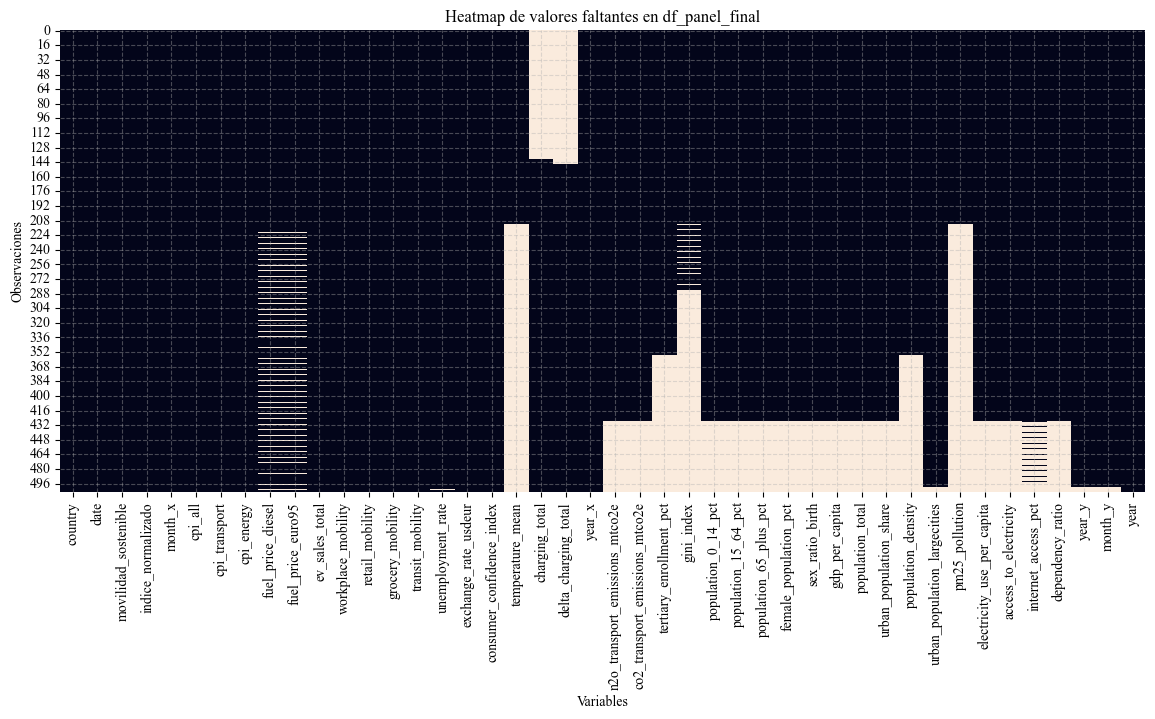

🧮 Total de filas: 506
✅ Filas completas (sin NaN): 65 (12.85%)
⚠️ Filas con al menos un NaN: 441 (87.15%)

📝 Notas clave:
- Variables estructurales anuales replicadas suelen tener pocos missing, salvo si falta año entero.
- Variables económicas/mensuales pueden tener missing en meses concretos (p.ej., precios o charging data en early periods).
- Missing concentrado en ciertos países/años puede requerir imputación, exclusión o tratamiento especial.
- Muchos missing en una variable -> considerar si eliminarla del modelo o imputarla.
- Panel puede seguir siendo usable si los missing son aleatorios y no sistemáticos.
- Si el % de filas completas es muy bajo (<70%), imputar missing puede ser mejor que eliminar filas.



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Análisis de Missing Values ---

def analizar_missing_panel(df, country_col='country', date_col='date'):
    print("🔎 Analizando missing values...\n")
    
    # 1. % de missing por columna
    missing_pct = df.isnull().mean().sort_values(ascending=False) * 100
    print("📊 % de Missing por Variable:\n")
    print(missing_pct)
    
    print("\n" + "="*50 + "\n")
    
    # 2. % de missing por país y año
    df['year'] = pd.to_datetime(df[date_col]).dt.year
    pivot_missing = df.groupby([country_col, 'year']).apply(lambda x: x.isnull().mean().mean()).reset_index()
    pivot_missing.columns = [country_col, 'year', 'missing_pct_avg']
    
    print("📊 % de Missing promedio por País y Año:\n")
    print(pivot_missing.sort_values('missing_pct_avg', ascending=False))
    
    print("\n" + "="*50 + "\n")
    
    # 3. Heatmap general de missing
    print("📈 Mostrando heatmap general de missing values...\n")
    plt.figure(figsize=(14,6))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title('Heatmap de valores faltantes en df_panel_final')
    plt.xlabel('Variables')
    plt.ylabel('Observaciones')
    plt.show()
    
    # 4. Conteo de filas completas vs incompletas
    total_rows = len(df)
    complete_rows = len(df.dropna())
    missing_rows = total_rows - complete_rows
    print(f"🧮 Total de filas: {total_rows}")
    print(f"✅ Filas completas (sin NaN): {complete_rows} ({(complete_rows/total_rows)*100:.2f}%)")
    print(f"⚠️ Filas con al menos un NaN: {missing_rows} ({(missing_rows/total_rows)*100:.2f}%)")
    
    # 5. Notas interpretativas
    notas = """
📝 Notas clave:
- Variables estructurales anuales replicadas suelen tener pocos missing, salvo si falta año entero.
- Variables económicas/mensuales pueden tener missing en meses concretos (p.ej., precios o charging data en early periods).
- Missing concentrado en ciertos países/años puede requerir imputación, exclusión o tratamiento especial.
- Muchos missing en una variable -> considerar si eliminarla del modelo o imputarla.
- Panel puede seguir siendo usable si los missing son aleatorios y no sistemáticos.
- Si el % de filas completas es muy bajo (<70%), imputar missing puede ser mejor que eliminar filas.
"""
    print(notas)

# --- Ejecutar ---
analizar_missing_panel(df_panel_final)


In [ ]:
# Exportar el panel completo original
df_panel_final.to_csv(r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\panel_mobility_sostenible_original.csv", index=False)

print("✅ Archivo exportado como 'panel_mobility_sostenible_original.csv'")



✅ Archivo exportado como 'panel_mobility_sostenible_original.csv'
